# Pleiothropy all tasks

#### Data Preprocessing:
- merge all pedgree ID's 
- build a unique Pedigree
- merge all pheno files according the unique pedgree

#### Pleiothropy estimate:
- loop over pheno and estimate pleiothropy between each pair of pheno
- collect results in a dictionary of matrix:
    - pleio Matrix rhoG
    - P-value Matrix of rhoG different from 0
    - P-value Matrix of rhoG d
    ifferent from 1
    - pleio Matrix RhoE
    - P-value Matrix of RhoE different from 0
    - P-value Matrix of RhoE different from 1

#### Clutering Rho Matrices :
- cluster pleio Matrix rhoG
- plot clustered pleio Matrix rhoG
- plot clustered P-value Matrix of rhoG different from 0
- plot clustered P-value Matrix of rhoG different from 1
- cluster pleio Matrix RhoE
- plot clustered pleio Matrix RhoE
- plot clustered P-value Matrix of RhoE different from 0
- plot clustered P-value Matrix of RhoE different from 1

In [21]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns
import functools
import subprocess as subp
from nilearn import plotting as nlp
from scipy import cluster as scl
from scipy import io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec as gs
import itertools
import datetime
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import json

In [5]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [6]:
%matplotlib inline

In [45]:
# Set path 
#path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_root = '/scratch/yassinebha/pleio/pleio_all_tasks/'
pedig_file_ptrn = 'solar_{}_spm_pedigre.csv'
pheno_file_ptrn = 'solar_{}_spm_{}_pheno.csv'

In [46]:
# Set task and trials
task_names = ['emotion','social','relational','motor','gambling','wm','language']
nb_sbt= 5

### Data preprocessing

#### Merge all pheno files and create cov variable stack

In [47]:
# create FD covariate for each task
cov_stack_FD = [pd.read_csv(os.path.join(path_root,pheno_file_ptrn.format(x.upper(),nb_sbt))).filter(regex = r'(ID|FD)') for x in task_names ]
cov_stack_FD_df  = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), cov_stack_FD)

# creat standard covariate that aplly to all tasks
cov_stack_stand = [pd.read_csv(os.path.join(path_root,pheno_file_ptrn.format(x.upper(),nb_sbt)))[['ID','Age_in_Yrs',
                                                                                            'Gender',
                                                                                            'BMI']] for x in task_names ]
cov_stack_stand_df = pd.merge(cov_stack_FD_df[['ID']],cov_stack_stand[0],how='left',on='ID')

# create pheno stack
pheno_stack = [pd.read_csv(os.path.join(path_root,pheno_file_ptrn.format(x.upper(),nb_sbt))).filter(regex ='^(?!.*FD)').drop(['Age_in_Yrs',
                                                                                                                              'Gender',
                                                                                                                              'BMI'],axis =1) for x in task_names]
pheno_stack_df  = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), pheno_stack)

# Merge all pheno cov in one file
dfs  = [cov_stack_stand_df,cov_stack_FD_df,pheno_stack_df]
all_pheno_cov = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), dfs)
# save to file
all_pheno_cov.to_csv(os.path.join(path_root,'pleio_all_pheno.csv'),index=False)
## regular expression tutorial https://stackoverflow.com/questions/1687620/regex-match-everything-but

#### Merge all Pedigree based on Pheno file

In [48]:
# create pedgree stack
pedigs_stack = [pd.read_csv(os.path.join(path_root,pedig_file_ptrn.format(x.upper()))) for x in task_names ]
pedigs_stack_df = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), pedigs_stack)

# Build a unique pedigree based on Pheno file
IDs= cov_stack_stand_df[['ID']]
df_pedig = IDs.merge(pedigs_stack[0],on='ID',how='left')
df_pedig.count()

ID        726
fa        726
mo        726
sex       726
mztwin    174
hhID      726
dtype: int64

In [49]:
pedigs_stack[5].count()

ID        859
fa        859
mo        859
sex       859
mztwin    238
hhID      859
dtype: int64

In [50]:
for ii in range(len(pedigs_stack)):
    pedigs_stack[ii].count()

In [51]:
# Look for MZ twins missing their co-twin
uniques = list(df_pedig.mztwin.unique())
uniques.pop(0)
twin_counts = [np.sum(df_pedig.mztwin==twin) for twin in uniques]
# for idx, twin in enumerate(uniques):
#     print("{} occurs {} times".format(twin, twin_counts[idx]))

In [52]:
# create a mask that will kepp only MZ twins missing their co-twin
singles = [True if np.sum(df_pedig.mztwin==row.mztwin)==1 else False for ind, row in df_pedig.iterrows()]

In [53]:
# Make a copy of the pedigre to avoid missing up with the original data
copy_df_pedig = df_pedig.copy()

In [54]:
# Select only MZ twins missing their co-twin
df_single_pedig = copy_df_pedig[singles]

# Add "M_" (for missing) to a the single MZ twins
for i, row in df_single_pedig.iterrows():
    df_single_pedig.set_value(i,"ID","M_{}".format(row.ID))
df_single_pedig.count()

/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


ID        48
fa        48
mo        48
sex       48
mztwin    48
hhID      48
dtype: int64

In [55]:
# Append pedgree with fake co-twin for the missing one
df_pedig_final = copy_df_pedig.append(df_single_pedig)
#df_pedig_final = pedigs_stack[5]
df_pedig_final.count()

ID        774
fa        774
mo        774
sex       774
mztwin    222
hhID      774
dtype: int64

In [56]:
# save to file
df_pedig_final.to_csv(os.path.join(path_root,'pleio_all_pheno_pedig.csv'),index=False)

### Pleiothropy estimate:

In [57]:
import collections
import multiprocessing 
import datetime

In [58]:
#initiate empty dictionary
Pleio_RhoG = collections.namedtuple('Pleio_RhoG', [
    'out_dir',
    'pedig_f',
    'pheno_f',
    'var_1',
    'var_2',
    'covar_1',
    'covar_2'
])
pleio_RhoGs = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}'.format(str(datetime.date.today())))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_pheno_1, pheno_1 in enumerate(pheno_stack_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_stack_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        print(pheno_1,pheno_2)
        
        # output result folder 
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        if not os.path.exists(path_pleio_contrast):
            os.makedirs(path_pleio_contrast)
            
        # copy needed files to output folder
        if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
            subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_run.sh')):
            subp.run(['cp',os.path.join(path_root,'pleio_run.sh'),path_pleio_contrast])
        
        # pedegree
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')):
            subp.run(['cp',os.path.join(path_root,'pleio_all_pheno_pedig.csv'),path_pleio_contrast]) 
        
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        
        # pheno cov stack
        df_pheno = pheno_stack_df[['ID',pheno_1,pheno_2]]
        cov_1 = '{}_FD_scrubbed_mean'.format(pheno_1.split('_')[0])
        cov_2 = '{}_FD_scrubbed_mean'.format(pheno_2.split('_')[0])
        df_cov = cov_stack_FD_df[['ID',cov_1,cov_2]]
        pheno_cov_stack = [df_pheno,df_cov,cov_stack_stand_df]
        
        # merge pheno cov
        pheno_cov_df = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), 
                                        pheno_cov_stack)
        # save pheno cov to file
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        if not os.path.isfile(pheno_f):
            pheno_cov_df.to_csv(pheno_f,index=False)   
        
        # collect all pleio contrasts in dictionary
        pleio_RhoGs.append(Pleio_RhoG(out_dir = path_pleio_contrast,
                                      pedig_f = pedig_f,
                                      pheno_f = pheno_f,
                                      var_1 = pheno_1,
                                      var_2 = pheno_2,
                                      covar_1 = cov_1,
                                      covar_2 = cov_2)) 

EMO_contrast_fear_vs_neut_sub1 EMO_contrast_fear_vs_neut_sub2
EMO_contrast_fear_vs_neut_sub1 EMO_contrast_fear_vs_neut_sub3
EMO_contrast_fear_vs_neut_sub1 EMO_contrast_fear_vs_neut_sub4
EMO_contrast_fear_vs_neut_sub1 EMO_contrast_fear_vs_neut_sub5
EMO_contrast_fear_vs_neut_sub1 SOC_mental_sub1
EMO_contrast_fear_vs_neut_sub1 SOC_mental_sub2
EMO_contrast_fear_vs_neut_sub1 SOC_mental_sub3
EMO_contrast_fear_vs_neut_sub1 SOC_mental_sub4
EMO_contrast_fear_vs_neut_sub1 SOC_mental_sub5
EMO_contrast_fear_vs_neut_sub1 SOC_contrast_mental_vs_rnd_sub1
EMO_contrast_fear_vs_neut_sub1 SOC_contrast_mental_vs_rnd_sub2
EMO_contrast_fear_vs_neut_sub1 SOC_contrast_mental_vs_rnd_sub3
EMO_contrast_fear_vs_neut_sub1 SOC_contrast_mental_vs_rnd_sub4
EMO_contrast_fear_vs_neut_sub1 SOC_contrast_mental_vs_rnd_sub5
EMO_contrast_fear_vs_neut_sub1 REL_match_sub1
EMO_contrast_fear_vs_neut_sub1 REL_match_sub2
EMO_contrast_fear_vs_neut_sub1 REL_match_sub3
EMO_contrast_fear_vs_neut_sub1 REL_match_sub4
EMO_contrast_fear_

EMO_contrast_fear_vs_neut_sub2 GAM_contrast_win_vs_loss_sub3
EMO_contrast_fear_vs_neut_sub2 GAM_contrast_win_vs_loss_sub4
EMO_contrast_fear_vs_neut_sub2 GAM_contrast_win_vs_loss_sub5
EMO_contrast_fear_vs_neut_sub2 GAM_loss_sub1
EMO_contrast_fear_vs_neut_sub2 GAM_loss_sub2
EMO_contrast_fear_vs_neut_sub2 GAM_loss_sub3
EMO_contrast_fear_vs_neut_sub2 GAM_loss_sub4
EMO_contrast_fear_vs_neut_sub2 GAM_loss_sub5
EMO_contrast_fear_vs_neut_sub2 GAM_win_sub1
EMO_contrast_fear_vs_neut_sub2 GAM_win_sub2
EMO_contrast_fear_vs_neut_sub2 GAM_win_sub3
EMO_contrast_fear_vs_neut_sub2 GAM_win_sub4
EMO_contrast_fear_vs_neut_sub2 GAM_win_sub5
EMO_contrast_fear_vs_neut_sub2 WM_contrast_body_vs_other_body_sub1
EMO_contrast_fear_vs_neut_sub2 WM_contrast_body_vs_other_body_sub2
EMO_contrast_fear_vs_neut_sub2 WM_contrast_body_vs_other_body_sub3
EMO_contrast_fear_vs_neut_sub2 WM_contrast_body_vs_other_body_sub4
EMO_contrast_fear_vs_neut_sub2 WM_contrast_body_vs_other_body_sub5
EMO_contrast_fear_vs_neut_sub2 WM_con

EMO_contrast_fear_vs_neut_sub3 WM_contrast_faces_vs_other_faces_sub5
EMO_contrast_fear_vs_neut_sub3 LAN_story_sub1
EMO_contrast_fear_vs_neut_sub3 LAN_story_sub2
EMO_contrast_fear_vs_neut_sub3 LAN_story_sub3
EMO_contrast_fear_vs_neut_sub3 LAN_story_sub4
EMO_contrast_fear_vs_neut_sub3 LAN_story_sub5
EMO_contrast_fear_vs_neut_sub4 EMO_contrast_fear_vs_neut_sub1
EMO_contrast_fear_vs_neut_sub4 EMO_contrast_fear_vs_neut_sub2
EMO_contrast_fear_vs_neut_sub4 EMO_contrast_fear_vs_neut_sub3
EMO_contrast_fear_vs_neut_sub4 EMO_contrast_fear_vs_neut_sub5
EMO_contrast_fear_vs_neut_sub4 SOC_mental_sub1
EMO_contrast_fear_vs_neut_sub4 SOC_mental_sub2
EMO_contrast_fear_vs_neut_sub4 SOC_mental_sub3
EMO_contrast_fear_vs_neut_sub4 SOC_mental_sub4
EMO_contrast_fear_vs_neut_sub4 SOC_mental_sub5
EMO_contrast_fear_vs_neut_sub4 SOC_contrast_mental_vs_rnd_sub1
EMO_contrast_fear_vs_neut_sub4 SOC_contrast_mental_vs_rnd_sub2
EMO_contrast_fear_vs_neut_sub4 SOC_contrast_mental_vs_rnd_sub3
EMO_contrast_fear_vs_neut_sub

EMO_contrast_fear_vs_neut_sub5 MOT_lf_sub1
EMO_contrast_fear_vs_neut_sub5 MOT_lf_sub2
EMO_contrast_fear_vs_neut_sub5 MOT_lf_sub3
EMO_contrast_fear_vs_neut_sub5 MOT_lf_sub4
EMO_contrast_fear_vs_neut_sub5 MOT_lf_sub5
EMO_contrast_fear_vs_neut_sub5 MOT_lh_sub1
EMO_contrast_fear_vs_neut_sub5 MOT_lh_sub2
EMO_contrast_fear_vs_neut_sub5 MOT_lh_sub3
EMO_contrast_fear_vs_neut_sub5 MOT_lh_sub4
EMO_contrast_fear_vs_neut_sub5 MOT_lh_sub5
EMO_contrast_fear_vs_neut_sub5 GAM_contrast_win_vs_loss_sub1
EMO_contrast_fear_vs_neut_sub5 GAM_contrast_win_vs_loss_sub2
EMO_contrast_fear_vs_neut_sub5 GAM_contrast_win_vs_loss_sub3
EMO_contrast_fear_vs_neut_sub5 GAM_contrast_win_vs_loss_sub4
EMO_contrast_fear_vs_neut_sub5 GAM_contrast_win_vs_loss_sub5
EMO_contrast_fear_vs_neut_sub5 GAM_loss_sub1
EMO_contrast_fear_vs_neut_sub5 GAM_loss_sub2
EMO_contrast_fear_vs_neut_sub5 GAM_loss_sub3
EMO_contrast_fear_vs_neut_sub5 GAM_loss_sub4
EMO_contrast_fear_vs_neut_sub5 GAM_loss_sub5
EMO_contrast_fear_vs_neut_sub5 GAM_win_s

SOC_mental_sub2 REL_match_sub1
SOC_mental_sub2 REL_match_sub2
SOC_mental_sub2 REL_match_sub3
SOC_mental_sub2 REL_match_sub4
SOC_mental_sub2 REL_match_sub5
SOC_mental_sub2 REL_relation_sub1
SOC_mental_sub2 REL_relation_sub2
SOC_mental_sub2 REL_relation_sub3
SOC_mental_sub2 REL_relation_sub4
SOC_mental_sub2 REL_relation_sub5
SOC_mental_sub2 REL_contrast_relation_vs_match_sub1
SOC_mental_sub2 REL_contrast_relation_vs_match_sub2
SOC_mental_sub2 REL_contrast_relation_vs_match_sub3
SOC_mental_sub2 REL_contrast_relation_vs_match_sub4
SOC_mental_sub2 REL_contrast_relation_vs_match_sub5
SOC_mental_sub2 MOT_rh_sub1
SOC_mental_sub2 MOT_rh_sub2
SOC_mental_sub2 MOT_rh_sub3
SOC_mental_sub2 MOT_rh_sub4
SOC_mental_sub2 MOT_rh_sub5
SOC_mental_sub2 MOT_rf_sub1
SOC_mental_sub2 MOT_rf_sub2
SOC_mental_sub2 MOT_rf_sub3
SOC_mental_sub2 MOT_rf_sub4
SOC_mental_sub2 MOT_rf_sub5
SOC_mental_sub2 MOT_t_sub1
SOC_mental_sub2 MOT_t_sub2
SOC_mental_sub2 MOT_t_sub3
SOC_mental_sub2 MOT_t_sub4
SOC_mental_sub2 MOT_t_sub5


SOC_mental_sub4 REL_match_sub3
SOC_mental_sub4 REL_match_sub4
SOC_mental_sub4 REL_match_sub5
SOC_mental_sub4 REL_relation_sub1
SOC_mental_sub4 REL_relation_sub2
SOC_mental_sub4 REL_relation_sub3
SOC_mental_sub4 REL_relation_sub4
SOC_mental_sub4 REL_relation_sub5
SOC_mental_sub4 REL_contrast_relation_vs_match_sub1
SOC_mental_sub4 REL_contrast_relation_vs_match_sub2
SOC_mental_sub4 REL_contrast_relation_vs_match_sub3
SOC_mental_sub4 REL_contrast_relation_vs_match_sub4
SOC_mental_sub4 REL_contrast_relation_vs_match_sub5
SOC_mental_sub4 MOT_rh_sub1
SOC_mental_sub4 MOT_rh_sub2
SOC_mental_sub4 MOT_rh_sub3
SOC_mental_sub4 MOT_rh_sub4
SOC_mental_sub4 MOT_rh_sub5
SOC_mental_sub4 MOT_rf_sub1
SOC_mental_sub4 MOT_rf_sub2
SOC_mental_sub4 MOT_rf_sub3
SOC_mental_sub4 MOT_rf_sub4
SOC_mental_sub4 MOT_rf_sub5
SOC_mental_sub4 MOT_t_sub1
SOC_mental_sub4 MOT_t_sub2
SOC_mental_sub4 MOT_t_sub3
SOC_mental_sub4 MOT_t_sub4
SOC_mental_sub4 MOT_t_sub5
SOC_mental_sub4 MOT_lf_sub1
SOC_mental_sub4 MOT_lf_sub2
SOC_me

SOC_contrast_mental_vs_rnd_sub1 REL_match_sub2
SOC_contrast_mental_vs_rnd_sub1 REL_match_sub3
SOC_contrast_mental_vs_rnd_sub1 REL_match_sub4
SOC_contrast_mental_vs_rnd_sub1 REL_match_sub5
SOC_contrast_mental_vs_rnd_sub1 REL_relation_sub1
SOC_contrast_mental_vs_rnd_sub1 REL_relation_sub2
SOC_contrast_mental_vs_rnd_sub1 REL_relation_sub3
SOC_contrast_mental_vs_rnd_sub1 REL_relation_sub4
SOC_contrast_mental_vs_rnd_sub1 REL_relation_sub5
SOC_contrast_mental_vs_rnd_sub1 REL_contrast_relation_vs_match_sub1
SOC_contrast_mental_vs_rnd_sub1 REL_contrast_relation_vs_match_sub2
SOC_contrast_mental_vs_rnd_sub1 REL_contrast_relation_vs_match_sub3
SOC_contrast_mental_vs_rnd_sub1 REL_contrast_relation_vs_match_sub4
SOC_contrast_mental_vs_rnd_sub1 REL_contrast_relation_vs_match_sub5
SOC_contrast_mental_vs_rnd_sub1 MOT_rh_sub1
SOC_contrast_mental_vs_rnd_sub1 MOT_rh_sub2
SOC_contrast_mental_vs_rnd_sub1 MOT_rh_sub3
SOC_contrast_mental_vs_rnd_sub1 MOT_rh_sub4
SOC_contrast_mental_vs_rnd_sub1 MOT_rh_sub5
SO

SOC_contrast_mental_vs_rnd_sub2 GAM_win_sub4
SOC_contrast_mental_vs_rnd_sub2 GAM_win_sub5
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_body_vs_other_body_sub1
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_body_vs_other_body_sub2
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_body_vs_other_body_sub3
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_body_vs_other_body_sub4
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_body_vs_other_body_sub5
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_tools_vs_other_tools_sub1
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_tools_vs_other_tools_sub2
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_tools_vs_other_tools_sub3
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_tools_vs_other_tools_sub4
SOC_contrast_mental_vs_rnd_sub2 WM_contrast_tools_vs_other_tools_sub5
SOC_contrast_mental_vs_rnd_sub2 WM_2bk_sub1
SOC_contrast_mental_vs_rnd_sub2 WM_2bk_sub2
SOC_contrast_mental_vs_rnd_sub2 WM_2bk_sub3
SOC_contrast_mental_vs_rnd_sub2 WM_2bk_sub4
SOC_contrast_mental_vs_rnd_sub2 WM_2bk_sub5


SOC_contrast_mental_vs_rnd_sub4 EMO_contrast_fear_vs_neut_sub4
SOC_contrast_mental_vs_rnd_sub4 EMO_contrast_fear_vs_neut_sub5
SOC_contrast_mental_vs_rnd_sub4 SOC_mental_sub1
SOC_contrast_mental_vs_rnd_sub4 SOC_mental_sub2
SOC_contrast_mental_vs_rnd_sub4 SOC_mental_sub3
SOC_contrast_mental_vs_rnd_sub4 SOC_mental_sub4
SOC_contrast_mental_vs_rnd_sub4 SOC_mental_sub5
SOC_contrast_mental_vs_rnd_sub4 SOC_contrast_mental_vs_rnd_sub1
SOC_contrast_mental_vs_rnd_sub4 SOC_contrast_mental_vs_rnd_sub2
SOC_contrast_mental_vs_rnd_sub4 SOC_contrast_mental_vs_rnd_sub3
SOC_contrast_mental_vs_rnd_sub4 SOC_contrast_mental_vs_rnd_sub5
SOC_contrast_mental_vs_rnd_sub4 REL_match_sub1
SOC_contrast_mental_vs_rnd_sub4 REL_match_sub2
SOC_contrast_mental_vs_rnd_sub4 REL_match_sub3
SOC_contrast_mental_vs_rnd_sub4 REL_match_sub4
SOC_contrast_mental_vs_rnd_sub4 REL_match_sub5
SOC_contrast_mental_vs_rnd_sub4 REL_relation_sub1
SOC_contrast_mental_vs_rnd_sub4 REL_relation_sub2
SOC_contrast_mental_vs_rnd_sub4 REL_relatio

SOC_contrast_mental_vs_rnd_sub5 MOT_lh_sub5
SOC_contrast_mental_vs_rnd_sub5 GAM_contrast_win_vs_loss_sub1
SOC_contrast_mental_vs_rnd_sub5 GAM_contrast_win_vs_loss_sub2
SOC_contrast_mental_vs_rnd_sub5 GAM_contrast_win_vs_loss_sub3
SOC_contrast_mental_vs_rnd_sub5 GAM_contrast_win_vs_loss_sub4
SOC_contrast_mental_vs_rnd_sub5 GAM_contrast_win_vs_loss_sub5
SOC_contrast_mental_vs_rnd_sub5 GAM_loss_sub1
SOC_contrast_mental_vs_rnd_sub5 GAM_loss_sub2
SOC_contrast_mental_vs_rnd_sub5 GAM_loss_sub3
SOC_contrast_mental_vs_rnd_sub5 GAM_loss_sub4
SOC_contrast_mental_vs_rnd_sub5 GAM_loss_sub5
SOC_contrast_mental_vs_rnd_sub5 GAM_win_sub1
SOC_contrast_mental_vs_rnd_sub5 GAM_win_sub2
SOC_contrast_mental_vs_rnd_sub5 GAM_win_sub3
SOC_contrast_mental_vs_rnd_sub5 GAM_win_sub4
SOC_contrast_mental_vs_rnd_sub5 GAM_win_sub5
SOC_contrast_mental_vs_rnd_sub5 WM_contrast_body_vs_other_body_sub1
SOC_contrast_mental_vs_rnd_sub5 WM_contrast_body_vs_other_body_sub2
SOC_contrast_mental_vs_rnd_sub5 WM_contrast_body_vs_oth

REL_match_sub2 REL_contrast_relation_vs_match_sub5
REL_match_sub2 MOT_rh_sub1
REL_match_sub2 MOT_rh_sub2
REL_match_sub2 MOT_rh_sub3
REL_match_sub2 MOT_rh_sub4
REL_match_sub2 MOT_rh_sub5
REL_match_sub2 MOT_rf_sub1
REL_match_sub2 MOT_rf_sub2
REL_match_sub2 MOT_rf_sub3
REL_match_sub2 MOT_rf_sub4
REL_match_sub2 MOT_rf_sub5
REL_match_sub2 MOT_t_sub1
REL_match_sub2 MOT_t_sub2
REL_match_sub2 MOT_t_sub3
REL_match_sub2 MOT_t_sub4
REL_match_sub2 MOT_t_sub5
REL_match_sub2 MOT_lf_sub1
REL_match_sub2 MOT_lf_sub2
REL_match_sub2 MOT_lf_sub3
REL_match_sub2 MOT_lf_sub4
REL_match_sub2 MOT_lf_sub5
REL_match_sub2 MOT_lh_sub1
REL_match_sub2 MOT_lh_sub2
REL_match_sub2 MOT_lh_sub3
REL_match_sub2 MOT_lh_sub4
REL_match_sub2 MOT_lh_sub5
REL_match_sub2 GAM_contrast_win_vs_loss_sub1
REL_match_sub2 GAM_contrast_win_vs_loss_sub2
REL_match_sub2 GAM_contrast_win_vs_loss_sub3
REL_match_sub2 GAM_contrast_win_vs_loss_sub4
REL_match_sub2 GAM_contrast_win_vs_loss_sub5
REL_match_sub2 GAM_loss_sub1
REL_match_sub2 GAM_loss_s

REL_match_sub4 MOT_rf_sub4
REL_match_sub4 MOT_rf_sub5
REL_match_sub4 MOT_t_sub1
REL_match_sub4 MOT_t_sub2
REL_match_sub4 MOT_t_sub3
REL_match_sub4 MOT_t_sub4
REL_match_sub4 MOT_t_sub5
REL_match_sub4 MOT_lf_sub1
REL_match_sub4 MOT_lf_sub2
REL_match_sub4 MOT_lf_sub3
REL_match_sub4 MOT_lf_sub4
REL_match_sub4 MOT_lf_sub5
REL_match_sub4 MOT_lh_sub1
REL_match_sub4 MOT_lh_sub2
REL_match_sub4 MOT_lh_sub3
REL_match_sub4 MOT_lh_sub4
REL_match_sub4 MOT_lh_sub5
REL_match_sub4 GAM_contrast_win_vs_loss_sub1
REL_match_sub4 GAM_contrast_win_vs_loss_sub2
REL_match_sub4 GAM_contrast_win_vs_loss_sub3
REL_match_sub4 GAM_contrast_win_vs_loss_sub4
REL_match_sub4 GAM_contrast_win_vs_loss_sub5
REL_match_sub4 GAM_loss_sub1
REL_match_sub4 GAM_loss_sub2
REL_match_sub4 GAM_loss_sub3
REL_match_sub4 GAM_loss_sub4
REL_match_sub4 GAM_loss_sub5
REL_match_sub4 GAM_win_sub1
REL_match_sub4 GAM_win_sub2
REL_match_sub4 GAM_win_sub3
REL_match_sub4 GAM_win_sub4
REL_match_sub4 GAM_win_sub5
REL_match_sub4 WM_contrast_body_vs_o

REL_relation_sub1 MOT_lf_sub1
REL_relation_sub1 MOT_lf_sub2
REL_relation_sub1 MOT_lf_sub3
REL_relation_sub1 MOT_lf_sub4
REL_relation_sub1 MOT_lf_sub5
REL_relation_sub1 MOT_lh_sub1
REL_relation_sub1 MOT_lh_sub2
REL_relation_sub1 MOT_lh_sub3
REL_relation_sub1 MOT_lh_sub4
REL_relation_sub1 MOT_lh_sub5
REL_relation_sub1 GAM_contrast_win_vs_loss_sub1
REL_relation_sub1 GAM_contrast_win_vs_loss_sub2
REL_relation_sub1 GAM_contrast_win_vs_loss_sub3
REL_relation_sub1 GAM_contrast_win_vs_loss_sub4
REL_relation_sub1 GAM_contrast_win_vs_loss_sub5
REL_relation_sub1 GAM_loss_sub1
REL_relation_sub1 GAM_loss_sub2
REL_relation_sub1 GAM_loss_sub3
REL_relation_sub1 GAM_loss_sub4
REL_relation_sub1 GAM_loss_sub5
REL_relation_sub1 GAM_win_sub1
REL_relation_sub1 GAM_win_sub2
REL_relation_sub1 GAM_win_sub3
REL_relation_sub1 GAM_win_sub4
REL_relation_sub1 GAM_win_sub5
REL_relation_sub1 WM_contrast_body_vs_other_body_sub1
REL_relation_sub1 WM_contrast_body_vs_other_body_sub2
REL_relation_sub1 WM_contrast_body_vs

REL_relation_sub3 MOT_rh_sub5
REL_relation_sub3 MOT_rf_sub1
REL_relation_sub3 MOT_rf_sub2
REL_relation_sub3 MOT_rf_sub3
REL_relation_sub3 MOT_rf_sub4
REL_relation_sub3 MOT_rf_sub5
REL_relation_sub3 MOT_t_sub1
REL_relation_sub3 MOT_t_sub2
REL_relation_sub3 MOT_t_sub3
REL_relation_sub3 MOT_t_sub4
REL_relation_sub3 MOT_t_sub5
REL_relation_sub3 MOT_lf_sub1
REL_relation_sub3 MOT_lf_sub2
REL_relation_sub3 MOT_lf_sub3
REL_relation_sub3 MOT_lf_sub4
REL_relation_sub3 MOT_lf_sub5
REL_relation_sub3 MOT_lh_sub1
REL_relation_sub3 MOT_lh_sub2
REL_relation_sub3 MOT_lh_sub3
REL_relation_sub3 MOT_lh_sub4
REL_relation_sub3 MOT_lh_sub5
REL_relation_sub3 GAM_contrast_win_vs_loss_sub1
REL_relation_sub3 GAM_contrast_win_vs_loss_sub2
REL_relation_sub3 GAM_contrast_win_vs_loss_sub3
REL_relation_sub3 GAM_contrast_win_vs_loss_sub4
REL_relation_sub3 GAM_contrast_win_vs_loss_sub5
REL_relation_sub3 GAM_loss_sub1
REL_relation_sub3 GAM_loss_sub2
REL_relation_sub3 GAM_loss_sub3
REL_relation_sub3 GAM_loss_sub4
REL_rel

REL_relation_sub5 REL_relation_sub3
REL_relation_sub5 REL_relation_sub4
REL_relation_sub5 REL_contrast_relation_vs_match_sub1
REL_relation_sub5 REL_contrast_relation_vs_match_sub2
REL_relation_sub5 REL_contrast_relation_vs_match_sub3
REL_relation_sub5 REL_contrast_relation_vs_match_sub4
REL_relation_sub5 REL_contrast_relation_vs_match_sub5
REL_relation_sub5 MOT_rh_sub1
REL_relation_sub5 MOT_rh_sub2
REL_relation_sub5 MOT_rh_sub3
REL_relation_sub5 MOT_rh_sub4
REL_relation_sub5 MOT_rh_sub5
REL_relation_sub5 MOT_rf_sub1
REL_relation_sub5 MOT_rf_sub2
REL_relation_sub5 MOT_rf_sub3
REL_relation_sub5 MOT_rf_sub4
REL_relation_sub5 MOT_rf_sub5
REL_relation_sub5 MOT_t_sub1
REL_relation_sub5 MOT_t_sub2
REL_relation_sub5 MOT_t_sub3
REL_relation_sub5 MOT_t_sub4
REL_relation_sub5 MOT_t_sub5
REL_relation_sub5 MOT_lf_sub1
REL_relation_sub5 MOT_lf_sub2
REL_relation_sub5 MOT_lf_sub3
REL_relation_sub5 MOT_lf_sub4
REL_relation_sub5 MOT_lf_sub5
REL_relation_sub5 MOT_lh_sub1
REL_relation_sub5 MOT_lh_sub2
REL

REL_contrast_relation_vs_match_sub1 WM_contrast_2bk_vs_0bk_sub2
REL_contrast_relation_vs_match_sub1 WM_contrast_2bk_vs_0bk_sub3
REL_contrast_relation_vs_match_sub1 WM_contrast_2bk_vs_0bk_sub4
REL_contrast_relation_vs_match_sub1 WM_contrast_2bk_vs_0bk_sub5
REL_contrast_relation_vs_match_sub1 WM_0bk_sub1
REL_contrast_relation_vs_match_sub1 WM_0bk_sub2
REL_contrast_relation_vs_match_sub1 WM_0bk_sub3
REL_contrast_relation_vs_match_sub1 WM_0bk_sub4
REL_contrast_relation_vs_match_sub1 WM_0bk_sub5
REL_contrast_relation_vs_match_sub1 WM_contrast_places_vs_other_places_sub1
REL_contrast_relation_vs_match_sub1 WM_contrast_places_vs_other_places_sub2
REL_contrast_relation_vs_match_sub1 WM_contrast_places_vs_other_places_sub3
REL_contrast_relation_vs_match_sub1 WM_contrast_places_vs_other_places_sub4
REL_contrast_relation_vs_match_sub1 WM_contrast_places_vs_other_places_sub5
REL_contrast_relation_vs_match_sub1 WM_contrast_faces_vs_other_faces_sub1
REL_contrast_relation_vs_match_sub1 WM_contrast_fa

REL_contrast_relation_vs_match_sub3 SOC_contrast_mental_vs_rnd_sub4
REL_contrast_relation_vs_match_sub3 SOC_contrast_mental_vs_rnd_sub5
REL_contrast_relation_vs_match_sub3 REL_match_sub1
REL_contrast_relation_vs_match_sub3 REL_match_sub2
REL_contrast_relation_vs_match_sub3 REL_match_sub3
REL_contrast_relation_vs_match_sub3 REL_match_sub4
REL_contrast_relation_vs_match_sub3 REL_match_sub5
REL_contrast_relation_vs_match_sub3 REL_relation_sub1
REL_contrast_relation_vs_match_sub3 REL_relation_sub2
REL_contrast_relation_vs_match_sub3 REL_relation_sub3
REL_contrast_relation_vs_match_sub3 REL_relation_sub4
REL_contrast_relation_vs_match_sub3 REL_relation_sub5
REL_contrast_relation_vs_match_sub3 REL_contrast_relation_vs_match_sub1
REL_contrast_relation_vs_match_sub3 REL_contrast_relation_vs_match_sub2
REL_contrast_relation_vs_match_sub3 REL_contrast_relation_vs_match_sub4
REL_contrast_relation_vs_match_sub3 REL_contrast_relation_vs_match_sub5
REL_contrast_relation_vs_match_sub3 MOT_rh_sub1
REL

REL_contrast_relation_vs_match_sub4 GAM_contrast_win_vs_loss_sub2
REL_contrast_relation_vs_match_sub4 GAM_contrast_win_vs_loss_sub3
REL_contrast_relation_vs_match_sub4 GAM_contrast_win_vs_loss_sub4
REL_contrast_relation_vs_match_sub4 GAM_contrast_win_vs_loss_sub5
REL_contrast_relation_vs_match_sub4 GAM_loss_sub1
REL_contrast_relation_vs_match_sub4 GAM_loss_sub2
REL_contrast_relation_vs_match_sub4 GAM_loss_sub3
REL_contrast_relation_vs_match_sub4 GAM_loss_sub4
REL_contrast_relation_vs_match_sub4 GAM_loss_sub5
REL_contrast_relation_vs_match_sub4 GAM_win_sub1
REL_contrast_relation_vs_match_sub4 GAM_win_sub2
REL_contrast_relation_vs_match_sub4 GAM_win_sub3
REL_contrast_relation_vs_match_sub4 GAM_win_sub4
REL_contrast_relation_vs_match_sub4 GAM_win_sub5
REL_contrast_relation_vs_match_sub4 WM_contrast_body_vs_other_body_sub1
REL_contrast_relation_vs_match_sub4 WM_contrast_body_vs_other_body_sub2
REL_contrast_relation_vs_match_sub4 WM_contrast_body_vs_other_body_sub3
REL_contrast_relation_vs_

REL_contrast_relation_vs_match_sub5 WM_0bk_sub3
REL_contrast_relation_vs_match_sub5 WM_0bk_sub4
REL_contrast_relation_vs_match_sub5 WM_0bk_sub5
REL_contrast_relation_vs_match_sub5 WM_contrast_places_vs_other_places_sub1
REL_contrast_relation_vs_match_sub5 WM_contrast_places_vs_other_places_sub2
REL_contrast_relation_vs_match_sub5 WM_contrast_places_vs_other_places_sub3
REL_contrast_relation_vs_match_sub5 WM_contrast_places_vs_other_places_sub4
REL_contrast_relation_vs_match_sub5 WM_contrast_places_vs_other_places_sub5
REL_contrast_relation_vs_match_sub5 WM_contrast_faces_vs_other_faces_sub1
REL_contrast_relation_vs_match_sub5 WM_contrast_faces_vs_other_faces_sub2
REL_contrast_relation_vs_match_sub5 WM_contrast_faces_vs_other_faces_sub3
REL_contrast_relation_vs_match_sub5 WM_contrast_faces_vs_other_faces_sub4
REL_contrast_relation_vs_match_sub5 WM_contrast_faces_vs_other_faces_sub5
REL_contrast_relation_vs_match_sub5 LAN_story_sub1
REL_contrast_relation_vs_match_sub5 LAN_story_sub2
REL_

MOT_rh_sub2 WM_contrast_faces_vs_other_faces_sub4
MOT_rh_sub2 WM_contrast_faces_vs_other_faces_sub5
MOT_rh_sub2 LAN_story_sub1
MOT_rh_sub2 LAN_story_sub2
MOT_rh_sub2 LAN_story_sub3
MOT_rh_sub2 LAN_story_sub4
MOT_rh_sub2 LAN_story_sub5
MOT_rh_sub3 EMO_contrast_fear_vs_neut_sub1
MOT_rh_sub3 EMO_contrast_fear_vs_neut_sub2
MOT_rh_sub3 EMO_contrast_fear_vs_neut_sub3
MOT_rh_sub3 EMO_contrast_fear_vs_neut_sub4
MOT_rh_sub3 EMO_contrast_fear_vs_neut_sub5
MOT_rh_sub3 SOC_mental_sub1
MOT_rh_sub3 SOC_mental_sub2
MOT_rh_sub3 SOC_mental_sub3
MOT_rh_sub3 SOC_mental_sub4
MOT_rh_sub3 SOC_mental_sub5
MOT_rh_sub3 SOC_contrast_mental_vs_rnd_sub1
MOT_rh_sub3 SOC_contrast_mental_vs_rnd_sub2
MOT_rh_sub3 SOC_contrast_mental_vs_rnd_sub3
MOT_rh_sub3 SOC_contrast_mental_vs_rnd_sub4
MOT_rh_sub3 SOC_contrast_mental_vs_rnd_sub5
MOT_rh_sub3 REL_match_sub1
MOT_rh_sub3 REL_match_sub2
MOT_rh_sub3 REL_match_sub3
MOT_rh_sub3 REL_match_sub4
MOT_rh_sub3 REL_match_sub5
MOT_rh_sub3 REL_relation_sub1
MOT_rh_sub3 REL_relation_

MOT_rh_sub5 REL_match_sub4
MOT_rh_sub5 REL_match_sub5
MOT_rh_sub5 REL_relation_sub1
MOT_rh_sub5 REL_relation_sub2
MOT_rh_sub5 REL_relation_sub3
MOT_rh_sub5 REL_relation_sub4
MOT_rh_sub5 REL_relation_sub5
MOT_rh_sub5 REL_contrast_relation_vs_match_sub1
MOT_rh_sub5 REL_contrast_relation_vs_match_sub2
MOT_rh_sub5 REL_contrast_relation_vs_match_sub3
MOT_rh_sub5 REL_contrast_relation_vs_match_sub4
MOT_rh_sub5 REL_contrast_relation_vs_match_sub5
MOT_rh_sub5 MOT_rh_sub1
MOT_rh_sub5 MOT_rh_sub2
MOT_rh_sub5 MOT_rh_sub3
MOT_rh_sub5 MOT_rh_sub4
MOT_rh_sub5 MOT_rf_sub1
MOT_rh_sub5 MOT_rf_sub2
MOT_rh_sub5 MOT_rf_sub3
MOT_rh_sub5 MOT_rf_sub4
MOT_rh_sub5 MOT_rf_sub5
MOT_rh_sub5 MOT_t_sub1
MOT_rh_sub5 MOT_t_sub2
MOT_rh_sub5 MOT_t_sub3
MOT_rh_sub5 MOT_t_sub4
MOT_rh_sub5 MOT_t_sub5
MOT_rh_sub5 MOT_lf_sub1
MOT_rh_sub5 MOT_lf_sub2
MOT_rh_sub5 MOT_lf_sub3
MOT_rh_sub5 MOT_lf_sub4
MOT_rh_sub5 MOT_lf_sub5
MOT_rh_sub5 MOT_lh_sub1
MOT_rh_sub5 MOT_lh_sub2
MOT_rh_sub5 MOT_lh_sub3
MOT_rh_sub5 MOT_lh_sub4
MOT_rh_su

MOT_rf_sub2 MOT_lf_sub5
MOT_rf_sub2 MOT_lh_sub1
MOT_rf_sub2 MOT_lh_sub2
MOT_rf_sub2 MOT_lh_sub3
MOT_rf_sub2 MOT_lh_sub4
MOT_rf_sub2 MOT_lh_sub5
MOT_rf_sub2 GAM_contrast_win_vs_loss_sub1
MOT_rf_sub2 GAM_contrast_win_vs_loss_sub2
MOT_rf_sub2 GAM_contrast_win_vs_loss_sub3
MOT_rf_sub2 GAM_contrast_win_vs_loss_sub4
MOT_rf_sub2 GAM_contrast_win_vs_loss_sub5
MOT_rf_sub2 GAM_loss_sub1
MOT_rf_sub2 GAM_loss_sub2
MOT_rf_sub2 GAM_loss_sub3
MOT_rf_sub2 GAM_loss_sub4
MOT_rf_sub2 GAM_loss_sub5
MOT_rf_sub2 GAM_win_sub1
MOT_rf_sub2 GAM_win_sub2
MOT_rf_sub2 GAM_win_sub3
MOT_rf_sub2 GAM_win_sub4
MOT_rf_sub2 GAM_win_sub5
MOT_rf_sub2 WM_contrast_body_vs_other_body_sub1
MOT_rf_sub2 WM_contrast_body_vs_other_body_sub2
MOT_rf_sub2 WM_contrast_body_vs_other_body_sub3
MOT_rf_sub2 WM_contrast_body_vs_other_body_sub4
MOT_rf_sub2 WM_contrast_body_vs_other_body_sub5
MOT_rf_sub2 WM_contrast_tools_vs_other_tools_sub1
MOT_rf_sub2 WM_contrast_tools_vs_other_tools_sub2
MOT_rf_sub2 WM_contrast_tools_vs_other_tools_sub3
M

MOT_rf_sub4 WM_contrast_tools_vs_other_tools_sub4
MOT_rf_sub4 WM_contrast_tools_vs_other_tools_sub5
MOT_rf_sub4 WM_2bk_sub1
MOT_rf_sub4 WM_2bk_sub2
MOT_rf_sub4 WM_2bk_sub3
MOT_rf_sub4 WM_2bk_sub4
MOT_rf_sub4 WM_2bk_sub5
MOT_rf_sub4 WM_contrast_2bk_vs_0bk_sub1
MOT_rf_sub4 WM_contrast_2bk_vs_0bk_sub2
MOT_rf_sub4 WM_contrast_2bk_vs_0bk_sub3
MOT_rf_sub4 WM_contrast_2bk_vs_0bk_sub4
MOT_rf_sub4 WM_contrast_2bk_vs_0bk_sub5
MOT_rf_sub4 WM_0bk_sub1
MOT_rf_sub4 WM_0bk_sub2
MOT_rf_sub4 WM_0bk_sub3
MOT_rf_sub4 WM_0bk_sub4
MOT_rf_sub4 WM_0bk_sub5
MOT_rf_sub4 WM_contrast_places_vs_other_places_sub1
MOT_rf_sub4 WM_contrast_places_vs_other_places_sub2
MOT_rf_sub4 WM_contrast_places_vs_other_places_sub3
MOT_rf_sub4 WM_contrast_places_vs_other_places_sub4
MOT_rf_sub4 WM_contrast_places_vs_other_places_sub5
MOT_rf_sub4 WM_contrast_faces_vs_other_faces_sub1
MOT_rf_sub4 WM_contrast_faces_vs_other_faces_sub2
MOT_rf_sub4 WM_contrast_faces_vs_other_faces_sub3
MOT_rf_sub4 WM_contrast_faces_vs_other_faces_sub4


MOT_t_sub1 LAN_story_sub1
MOT_t_sub1 LAN_story_sub2
MOT_t_sub1 LAN_story_sub3
MOT_t_sub1 LAN_story_sub4
MOT_t_sub1 LAN_story_sub5
MOT_t_sub2 EMO_contrast_fear_vs_neut_sub1
MOT_t_sub2 EMO_contrast_fear_vs_neut_sub2
MOT_t_sub2 EMO_contrast_fear_vs_neut_sub3
MOT_t_sub2 EMO_contrast_fear_vs_neut_sub4
MOT_t_sub2 EMO_contrast_fear_vs_neut_sub5
MOT_t_sub2 SOC_mental_sub1
MOT_t_sub2 SOC_mental_sub2
MOT_t_sub2 SOC_mental_sub3
MOT_t_sub2 SOC_mental_sub4
MOT_t_sub2 SOC_mental_sub5
MOT_t_sub2 SOC_contrast_mental_vs_rnd_sub1
MOT_t_sub2 SOC_contrast_mental_vs_rnd_sub2
MOT_t_sub2 SOC_contrast_mental_vs_rnd_sub3
MOT_t_sub2 SOC_contrast_mental_vs_rnd_sub4
MOT_t_sub2 SOC_contrast_mental_vs_rnd_sub5
MOT_t_sub2 REL_match_sub1
MOT_t_sub2 REL_match_sub2
MOT_t_sub2 REL_match_sub3
MOT_t_sub2 REL_match_sub4
MOT_t_sub2 REL_match_sub5
MOT_t_sub2 REL_relation_sub1
MOT_t_sub2 REL_relation_sub2
MOT_t_sub2 REL_relation_sub3
MOT_t_sub2 REL_relation_sub4
MOT_t_sub2 REL_relation_sub5
MOT_t_sub2 REL_contrast_relation_vs

MOT_t_sub4 MOT_rh_sub1
MOT_t_sub4 MOT_rh_sub2
MOT_t_sub4 MOT_rh_sub3
MOT_t_sub4 MOT_rh_sub4
MOT_t_sub4 MOT_rh_sub5
MOT_t_sub4 MOT_rf_sub1
MOT_t_sub4 MOT_rf_sub2
MOT_t_sub4 MOT_rf_sub3
MOT_t_sub4 MOT_rf_sub4
MOT_t_sub4 MOT_rf_sub5
MOT_t_sub4 MOT_t_sub1
MOT_t_sub4 MOT_t_sub2
MOT_t_sub4 MOT_t_sub3
MOT_t_sub4 MOT_t_sub5
MOT_t_sub4 MOT_lf_sub1
MOT_t_sub4 MOT_lf_sub2
MOT_t_sub4 MOT_lf_sub3
MOT_t_sub4 MOT_lf_sub4
MOT_t_sub4 MOT_lf_sub5
MOT_t_sub4 MOT_lh_sub1
MOT_t_sub4 MOT_lh_sub2
MOT_t_sub4 MOT_lh_sub3
MOT_t_sub4 MOT_lh_sub4
MOT_t_sub4 MOT_lh_sub5
MOT_t_sub4 GAM_contrast_win_vs_loss_sub1
MOT_t_sub4 GAM_contrast_win_vs_loss_sub2
MOT_t_sub4 GAM_contrast_win_vs_loss_sub3
MOT_t_sub4 GAM_contrast_win_vs_loss_sub4
MOT_t_sub4 GAM_contrast_win_vs_loss_sub5
MOT_t_sub4 GAM_loss_sub1
MOT_t_sub4 GAM_loss_sub2
MOT_t_sub4 GAM_loss_sub3
MOT_t_sub4 GAM_loss_sub4
MOT_t_sub4 GAM_loss_sub5
MOT_t_sub4 GAM_win_sub1
MOT_t_sub4 GAM_win_sub2
MOT_t_sub4 GAM_win_sub3
MOT_t_sub4 GAM_win_sub4
MOT_t_sub4 GAM_win_sub5
MO

MOT_lf_sub1 WM_contrast_body_vs_other_body_sub5
MOT_lf_sub1 WM_contrast_tools_vs_other_tools_sub1
MOT_lf_sub1 WM_contrast_tools_vs_other_tools_sub2
MOT_lf_sub1 WM_contrast_tools_vs_other_tools_sub3
MOT_lf_sub1 WM_contrast_tools_vs_other_tools_sub4
MOT_lf_sub1 WM_contrast_tools_vs_other_tools_sub5
MOT_lf_sub1 WM_2bk_sub1
MOT_lf_sub1 WM_2bk_sub2
MOT_lf_sub1 WM_2bk_sub3
MOT_lf_sub1 WM_2bk_sub4
MOT_lf_sub1 WM_2bk_sub5
MOT_lf_sub1 WM_contrast_2bk_vs_0bk_sub1
MOT_lf_sub1 WM_contrast_2bk_vs_0bk_sub2
MOT_lf_sub1 WM_contrast_2bk_vs_0bk_sub3
MOT_lf_sub1 WM_contrast_2bk_vs_0bk_sub4
MOT_lf_sub1 WM_contrast_2bk_vs_0bk_sub5
MOT_lf_sub1 WM_0bk_sub1
MOT_lf_sub1 WM_0bk_sub2
MOT_lf_sub1 WM_0bk_sub3
MOT_lf_sub1 WM_0bk_sub4
MOT_lf_sub1 WM_0bk_sub5
MOT_lf_sub1 WM_contrast_places_vs_other_places_sub1
MOT_lf_sub1 WM_contrast_places_vs_other_places_sub2
MOT_lf_sub1 WM_contrast_places_vs_other_places_sub3
MOT_lf_sub1 WM_contrast_places_vs_other_places_sub4
MOT_lf_sub1 WM_contrast_places_vs_other_places_sub5
MO

MOT_lf_sub3 WM_contrast_places_vs_other_places_sub2
MOT_lf_sub3 WM_contrast_places_vs_other_places_sub3
MOT_lf_sub3 WM_contrast_places_vs_other_places_sub4
MOT_lf_sub3 WM_contrast_places_vs_other_places_sub5
MOT_lf_sub3 WM_contrast_faces_vs_other_faces_sub1
MOT_lf_sub3 WM_contrast_faces_vs_other_faces_sub2
MOT_lf_sub3 WM_contrast_faces_vs_other_faces_sub3
MOT_lf_sub3 WM_contrast_faces_vs_other_faces_sub4
MOT_lf_sub3 WM_contrast_faces_vs_other_faces_sub5
MOT_lf_sub3 LAN_story_sub1
MOT_lf_sub3 LAN_story_sub2
MOT_lf_sub3 LAN_story_sub3
MOT_lf_sub3 LAN_story_sub4
MOT_lf_sub3 LAN_story_sub5
MOT_lf_sub4 EMO_contrast_fear_vs_neut_sub1
MOT_lf_sub4 EMO_contrast_fear_vs_neut_sub2
MOT_lf_sub4 EMO_contrast_fear_vs_neut_sub3
MOT_lf_sub4 EMO_contrast_fear_vs_neut_sub4
MOT_lf_sub4 EMO_contrast_fear_vs_neut_sub5
MOT_lf_sub4 SOC_mental_sub1
MOT_lf_sub4 SOC_mental_sub2
MOT_lf_sub4 SOC_mental_sub3
MOT_lf_sub4 SOC_mental_sub4
MOT_lf_sub4 SOC_mental_sub5
MOT_lf_sub4 SOC_contrast_mental_vs_rnd_sub1
MOT_lf_s

MOT_lh_sub1 SOC_mental_sub4
MOT_lh_sub1 SOC_mental_sub5
MOT_lh_sub1 SOC_contrast_mental_vs_rnd_sub1
MOT_lh_sub1 SOC_contrast_mental_vs_rnd_sub2
MOT_lh_sub1 SOC_contrast_mental_vs_rnd_sub3
MOT_lh_sub1 SOC_contrast_mental_vs_rnd_sub4
MOT_lh_sub1 SOC_contrast_mental_vs_rnd_sub5
MOT_lh_sub1 REL_match_sub1
MOT_lh_sub1 REL_match_sub2
MOT_lh_sub1 REL_match_sub3
MOT_lh_sub1 REL_match_sub4
MOT_lh_sub1 REL_match_sub5
MOT_lh_sub1 REL_relation_sub1
MOT_lh_sub1 REL_relation_sub2
MOT_lh_sub1 REL_relation_sub3
MOT_lh_sub1 REL_relation_sub4
MOT_lh_sub1 REL_relation_sub5
MOT_lh_sub1 REL_contrast_relation_vs_match_sub1
MOT_lh_sub1 REL_contrast_relation_vs_match_sub2
MOT_lh_sub1 REL_contrast_relation_vs_match_sub3
MOT_lh_sub1 REL_contrast_relation_vs_match_sub4
MOT_lh_sub1 REL_contrast_relation_vs_match_sub5
MOT_lh_sub1 MOT_rh_sub1
MOT_lh_sub1 MOT_rh_sub2
MOT_lh_sub1 MOT_rh_sub3
MOT_lh_sub1 MOT_rh_sub4
MOT_lh_sub1 MOT_rh_sub5
MOT_lh_sub1 MOT_rf_sub1
MOT_lh_sub1 MOT_rf_sub2
MOT_lh_sub1 MOT_rf_sub3
MOT_lh_

MOT_lh_sub3 MOT_rh_sub3
MOT_lh_sub3 MOT_rh_sub4
MOT_lh_sub3 MOT_rh_sub5
MOT_lh_sub3 MOT_rf_sub1
MOT_lh_sub3 MOT_rf_sub2
MOT_lh_sub3 MOT_rf_sub3
MOT_lh_sub3 MOT_rf_sub4
MOT_lh_sub3 MOT_rf_sub5
MOT_lh_sub3 MOT_t_sub1
MOT_lh_sub3 MOT_t_sub2
MOT_lh_sub3 MOT_t_sub3
MOT_lh_sub3 MOT_t_sub4
MOT_lh_sub3 MOT_t_sub5
MOT_lh_sub3 MOT_lf_sub1
MOT_lh_sub3 MOT_lf_sub2
MOT_lh_sub3 MOT_lf_sub3
MOT_lh_sub3 MOT_lf_sub4
MOT_lh_sub3 MOT_lf_sub5
MOT_lh_sub3 MOT_lh_sub1
MOT_lh_sub3 MOT_lh_sub2
MOT_lh_sub3 MOT_lh_sub4
MOT_lh_sub3 MOT_lh_sub5
MOT_lh_sub3 GAM_contrast_win_vs_loss_sub1
MOT_lh_sub3 GAM_contrast_win_vs_loss_sub2
MOT_lh_sub3 GAM_contrast_win_vs_loss_sub3
MOT_lh_sub3 GAM_contrast_win_vs_loss_sub4
MOT_lh_sub3 GAM_contrast_win_vs_loss_sub5
MOT_lh_sub3 GAM_loss_sub1
MOT_lh_sub3 GAM_loss_sub2
MOT_lh_sub3 GAM_loss_sub3
MOT_lh_sub3 GAM_loss_sub4
MOT_lh_sub3 GAM_loss_sub5
MOT_lh_sub3 GAM_win_sub1
MOT_lh_sub3 GAM_win_sub2
MOT_lh_sub3 GAM_win_sub3
MOT_lh_sub3 GAM_win_sub4
MOT_lh_sub3 GAM_win_sub5
MOT_lh_sub3 

MOT_lh_sub5 GAM_win_sub3
MOT_lh_sub5 GAM_win_sub4
MOT_lh_sub5 GAM_win_sub5
MOT_lh_sub5 WM_contrast_body_vs_other_body_sub1
MOT_lh_sub5 WM_contrast_body_vs_other_body_sub2
MOT_lh_sub5 WM_contrast_body_vs_other_body_sub3
MOT_lh_sub5 WM_contrast_body_vs_other_body_sub4
MOT_lh_sub5 WM_contrast_body_vs_other_body_sub5
MOT_lh_sub5 WM_contrast_tools_vs_other_tools_sub1
MOT_lh_sub5 WM_contrast_tools_vs_other_tools_sub2
MOT_lh_sub5 WM_contrast_tools_vs_other_tools_sub3
MOT_lh_sub5 WM_contrast_tools_vs_other_tools_sub4
MOT_lh_sub5 WM_contrast_tools_vs_other_tools_sub5
MOT_lh_sub5 WM_2bk_sub1
MOT_lh_sub5 WM_2bk_sub2
MOT_lh_sub5 WM_2bk_sub3
MOT_lh_sub5 WM_2bk_sub4
MOT_lh_sub5 WM_2bk_sub5
MOT_lh_sub5 WM_contrast_2bk_vs_0bk_sub1
MOT_lh_sub5 WM_contrast_2bk_vs_0bk_sub2
MOT_lh_sub5 WM_contrast_2bk_vs_0bk_sub3
MOT_lh_sub5 WM_contrast_2bk_vs_0bk_sub4
MOT_lh_sub5 WM_contrast_2bk_vs_0bk_sub5
MOT_lh_sub5 WM_0bk_sub1
MOT_lh_sub5 WM_0bk_sub2
MOT_lh_sub5 WM_0bk_sub3
MOT_lh_sub5 WM_0bk_sub4
MOT_lh_sub5 WM_0bk_

GAM_contrast_win_vs_loss_sub2 REL_match_sub5
GAM_contrast_win_vs_loss_sub2 REL_relation_sub1
GAM_contrast_win_vs_loss_sub2 REL_relation_sub2
GAM_contrast_win_vs_loss_sub2 REL_relation_sub3
GAM_contrast_win_vs_loss_sub2 REL_relation_sub4
GAM_contrast_win_vs_loss_sub2 REL_relation_sub5
GAM_contrast_win_vs_loss_sub2 REL_contrast_relation_vs_match_sub1
GAM_contrast_win_vs_loss_sub2 REL_contrast_relation_vs_match_sub2
GAM_contrast_win_vs_loss_sub2 REL_contrast_relation_vs_match_sub3
GAM_contrast_win_vs_loss_sub2 REL_contrast_relation_vs_match_sub4
GAM_contrast_win_vs_loss_sub2 REL_contrast_relation_vs_match_sub5
GAM_contrast_win_vs_loss_sub2 MOT_rh_sub1
GAM_contrast_win_vs_loss_sub2 MOT_rh_sub2
GAM_contrast_win_vs_loss_sub2 MOT_rh_sub3
GAM_contrast_win_vs_loss_sub2 MOT_rh_sub4
GAM_contrast_win_vs_loss_sub2 MOT_rh_sub5
GAM_contrast_win_vs_loss_sub2 MOT_rf_sub1
GAM_contrast_win_vs_loss_sub2 MOT_rf_sub2
GAM_contrast_win_vs_loss_sub2 MOT_rf_sub3
GAM_contrast_win_vs_loss_sub2 MOT_rf_sub4
GAM_con

GAM_contrast_win_vs_loss_sub3 WM_contrast_tools_vs_other_tools_sub3
GAM_contrast_win_vs_loss_sub3 WM_contrast_tools_vs_other_tools_sub4
GAM_contrast_win_vs_loss_sub3 WM_contrast_tools_vs_other_tools_sub5
GAM_contrast_win_vs_loss_sub3 WM_2bk_sub1
GAM_contrast_win_vs_loss_sub3 WM_2bk_sub2
GAM_contrast_win_vs_loss_sub3 WM_2bk_sub3
GAM_contrast_win_vs_loss_sub3 WM_2bk_sub4
GAM_contrast_win_vs_loss_sub3 WM_2bk_sub5
GAM_contrast_win_vs_loss_sub3 WM_contrast_2bk_vs_0bk_sub1
GAM_contrast_win_vs_loss_sub3 WM_contrast_2bk_vs_0bk_sub2
GAM_contrast_win_vs_loss_sub3 WM_contrast_2bk_vs_0bk_sub3
GAM_contrast_win_vs_loss_sub3 WM_contrast_2bk_vs_0bk_sub4
GAM_contrast_win_vs_loss_sub3 WM_contrast_2bk_vs_0bk_sub5
GAM_contrast_win_vs_loss_sub3 WM_0bk_sub1
GAM_contrast_win_vs_loss_sub3 WM_0bk_sub2
GAM_contrast_win_vs_loss_sub3 WM_0bk_sub3
GAM_contrast_win_vs_loss_sub3 WM_0bk_sub4
GAM_contrast_win_vs_loss_sub3 WM_0bk_sub5
GAM_contrast_win_vs_loss_sub3 WM_contrast_places_vs_other_places_sub1
GAM_contrast_win

GAM_contrast_win_vs_loss_sub5 SOC_contrast_mental_vs_rnd_sub5
GAM_contrast_win_vs_loss_sub5 REL_match_sub1
GAM_contrast_win_vs_loss_sub5 REL_match_sub2
GAM_contrast_win_vs_loss_sub5 REL_match_sub3
GAM_contrast_win_vs_loss_sub5 REL_match_sub4
GAM_contrast_win_vs_loss_sub5 REL_match_sub5
GAM_contrast_win_vs_loss_sub5 REL_relation_sub1
GAM_contrast_win_vs_loss_sub5 REL_relation_sub2
GAM_contrast_win_vs_loss_sub5 REL_relation_sub3
GAM_contrast_win_vs_loss_sub5 REL_relation_sub4
GAM_contrast_win_vs_loss_sub5 REL_relation_sub5
GAM_contrast_win_vs_loss_sub5 REL_contrast_relation_vs_match_sub1
GAM_contrast_win_vs_loss_sub5 REL_contrast_relation_vs_match_sub2
GAM_contrast_win_vs_loss_sub5 REL_contrast_relation_vs_match_sub3
GAM_contrast_win_vs_loss_sub5 REL_contrast_relation_vs_match_sub4
GAM_contrast_win_vs_loss_sub5 REL_contrast_relation_vs_match_sub5
GAM_contrast_win_vs_loss_sub5 MOT_rh_sub1
GAM_contrast_win_vs_loss_sub5 MOT_rh_sub2
GAM_contrast_win_vs_loss_sub5 MOT_rh_sub3
GAM_contrast_win_

GAM_loss_sub1 WM_contrast_places_vs_other_places_sub5
GAM_loss_sub1 WM_contrast_faces_vs_other_faces_sub1
GAM_loss_sub1 WM_contrast_faces_vs_other_faces_sub2
GAM_loss_sub1 WM_contrast_faces_vs_other_faces_sub3
GAM_loss_sub1 WM_contrast_faces_vs_other_faces_sub4
GAM_loss_sub1 WM_contrast_faces_vs_other_faces_sub5
GAM_loss_sub1 LAN_story_sub1
GAM_loss_sub1 LAN_story_sub2
GAM_loss_sub1 LAN_story_sub3
GAM_loss_sub1 LAN_story_sub4
GAM_loss_sub1 LAN_story_sub5
GAM_loss_sub2 EMO_contrast_fear_vs_neut_sub1
GAM_loss_sub2 EMO_contrast_fear_vs_neut_sub2
GAM_loss_sub2 EMO_contrast_fear_vs_neut_sub3
GAM_loss_sub2 EMO_contrast_fear_vs_neut_sub4
GAM_loss_sub2 EMO_contrast_fear_vs_neut_sub5
GAM_loss_sub2 SOC_mental_sub1
GAM_loss_sub2 SOC_mental_sub2
GAM_loss_sub2 SOC_mental_sub3
GAM_loss_sub2 SOC_mental_sub4
GAM_loss_sub2 SOC_mental_sub5
GAM_loss_sub2 SOC_contrast_mental_vs_rnd_sub1
GAM_loss_sub2 SOC_contrast_mental_vs_rnd_sub2
GAM_loss_sub2 SOC_contrast_mental_vs_rnd_sub3
GAM_loss_sub2 SOC_contrast_m

GAM_loss_sub4 EMO_contrast_fear_vs_neut_sub4
GAM_loss_sub4 EMO_contrast_fear_vs_neut_sub5
GAM_loss_sub4 SOC_mental_sub1
GAM_loss_sub4 SOC_mental_sub2
GAM_loss_sub4 SOC_mental_sub3
GAM_loss_sub4 SOC_mental_sub4
GAM_loss_sub4 SOC_mental_sub5
GAM_loss_sub4 SOC_contrast_mental_vs_rnd_sub1
GAM_loss_sub4 SOC_contrast_mental_vs_rnd_sub2
GAM_loss_sub4 SOC_contrast_mental_vs_rnd_sub3
GAM_loss_sub4 SOC_contrast_mental_vs_rnd_sub4
GAM_loss_sub4 SOC_contrast_mental_vs_rnd_sub5
GAM_loss_sub4 REL_match_sub1
GAM_loss_sub4 REL_match_sub2
GAM_loss_sub4 REL_match_sub3
GAM_loss_sub4 REL_match_sub4
GAM_loss_sub4 REL_match_sub5
GAM_loss_sub4 REL_relation_sub1
GAM_loss_sub4 REL_relation_sub2
GAM_loss_sub4 REL_relation_sub3
GAM_loss_sub4 REL_relation_sub4
GAM_loss_sub4 REL_relation_sub5
GAM_loss_sub4 REL_contrast_relation_vs_match_sub1
GAM_loss_sub4 REL_contrast_relation_vs_match_sub2
GAM_loss_sub4 REL_contrast_relation_vs_match_sub3
GAM_loss_sub4 REL_contrast_relation_vs_match_sub4
GAM_loss_sub4 REL_contras

GAM_win_sub1 SOC_contrast_mental_vs_rnd_sub4
GAM_win_sub1 SOC_contrast_mental_vs_rnd_sub5
GAM_win_sub1 REL_match_sub1
GAM_win_sub1 REL_match_sub2
GAM_win_sub1 REL_match_sub3
GAM_win_sub1 REL_match_sub4
GAM_win_sub1 REL_match_sub5
GAM_win_sub1 REL_relation_sub1
GAM_win_sub1 REL_relation_sub2
GAM_win_sub1 REL_relation_sub3
GAM_win_sub1 REL_relation_sub4
GAM_win_sub1 REL_relation_sub5
GAM_win_sub1 REL_contrast_relation_vs_match_sub1
GAM_win_sub1 REL_contrast_relation_vs_match_sub2
GAM_win_sub1 REL_contrast_relation_vs_match_sub3
GAM_win_sub1 REL_contrast_relation_vs_match_sub4
GAM_win_sub1 REL_contrast_relation_vs_match_sub5
GAM_win_sub1 MOT_rh_sub1
GAM_win_sub1 MOT_rh_sub2
GAM_win_sub1 MOT_rh_sub3
GAM_win_sub1 MOT_rh_sub4
GAM_win_sub1 MOT_rh_sub5
GAM_win_sub1 MOT_rf_sub1
GAM_win_sub1 MOT_rf_sub2
GAM_win_sub1 MOT_rf_sub3
GAM_win_sub1 MOT_rf_sub4
GAM_win_sub1 MOT_rf_sub5
GAM_win_sub1 MOT_t_sub1
GAM_win_sub1 MOT_t_sub2
GAM_win_sub1 MOT_t_sub3
GAM_win_sub1 MOT_t_sub4
GAM_win_sub1 MOT_t_sub5


GAM_win_sub3 REL_contrast_relation_vs_match_sub5
GAM_win_sub3 MOT_rh_sub1
GAM_win_sub3 MOT_rh_sub2
GAM_win_sub3 MOT_rh_sub3
GAM_win_sub3 MOT_rh_sub4
GAM_win_sub3 MOT_rh_sub5
GAM_win_sub3 MOT_rf_sub1
GAM_win_sub3 MOT_rf_sub2
GAM_win_sub3 MOT_rf_sub3
GAM_win_sub3 MOT_rf_sub4
GAM_win_sub3 MOT_rf_sub5
GAM_win_sub3 MOT_t_sub1
GAM_win_sub3 MOT_t_sub2
GAM_win_sub3 MOT_t_sub3
GAM_win_sub3 MOT_t_sub4
GAM_win_sub3 MOT_t_sub5
GAM_win_sub3 MOT_lf_sub1
GAM_win_sub3 MOT_lf_sub2
GAM_win_sub3 MOT_lf_sub3
GAM_win_sub3 MOT_lf_sub4
GAM_win_sub3 MOT_lf_sub5
GAM_win_sub3 MOT_lh_sub1
GAM_win_sub3 MOT_lh_sub2
GAM_win_sub3 MOT_lh_sub3
GAM_win_sub3 MOT_lh_sub4
GAM_win_sub3 MOT_lh_sub5
GAM_win_sub3 GAM_contrast_win_vs_loss_sub1
GAM_win_sub3 GAM_contrast_win_vs_loss_sub2
GAM_win_sub3 GAM_contrast_win_vs_loss_sub3
GAM_win_sub3 GAM_contrast_win_vs_loss_sub4
GAM_win_sub3 GAM_contrast_win_vs_loss_sub5
GAM_win_sub3 GAM_loss_sub1
GAM_win_sub3 GAM_loss_sub2
GAM_win_sub3 GAM_loss_sub3
GAM_win_sub3 GAM_loss_sub4
GAM_win_

GAM_win_sub5 MOT_lh_sub4
GAM_win_sub5 MOT_lh_sub5
GAM_win_sub5 GAM_contrast_win_vs_loss_sub1
GAM_win_sub5 GAM_contrast_win_vs_loss_sub2
GAM_win_sub5 GAM_contrast_win_vs_loss_sub3
GAM_win_sub5 GAM_contrast_win_vs_loss_sub4
GAM_win_sub5 GAM_contrast_win_vs_loss_sub5
GAM_win_sub5 GAM_loss_sub1
GAM_win_sub5 GAM_loss_sub2
GAM_win_sub5 GAM_loss_sub3
GAM_win_sub5 GAM_loss_sub4
GAM_win_sub5 GAM_loss_sub5
GAM_win_sub5 GAM_win_sub1
GAM_win_sub5 GAM_win_sub2
GAM_win_sub5 GAM_win_sub3
GAM_win_sub5 GAM_win_sub4
GAM_win_sub5 WM_contrast_body_vs_other_body_sub1
GAM_win_sub5 WM_contrast_body_vs_other_body_sub2
GAM_win_sub5 WM_contrast_body_vs_other_body_sub3
GAM_win_sub5 WM_contrast_body_vs_other_body_sub4
GAM_win_sub5 WM_contrast_body_vs_other_body_sub5
GAM_win_sub5 WM_contrast_tools_vs_other_tools_sub1
GAM_win_sub5 WM_contrast_tools_vs_other_tools_sub2
GAM_win_sub5 WM_contrast_tools_vs_other_tools_sub3
GAM_win_sub5 WM_contrast_tools_vs_other_tools_sub4
GAM_win_sub5 WM_contrast_tools_vs_other_tools_s

WM_contrast_body_vs_other_body_sub1 LAN_story_sub4
WM_contrast_body_vs_other_body_sub1 LAN_story_sub5
WM_contrast_body_vs_other_body_sub2 EMO_contrast_fear_vs_neut_sub1
WM_contrast_body_vs_other_body_sub2 EMO_contrast_fear_vs_neut_sub2
WM_contrast_body_vs_other_body_sub2 EMO_contrast_fear_vs_neut_sub3
WM_contrast_body_vs_other_body_sub2 EMO_contrast_fear_vs_neut_sub4
WM_contrast_body_vs_other_body_sub2 EMO_contrast_fear_vs_neut_sub5
WM_contrast_body_vs_other_body_sub2 SOC_mental_sub1
WM_contrast_body_vs_other_body_sub2 SOC_mental_sub2
WM_contrast_body_vs_other_body_sub2 SOC_mental_sub3
WM_contrast_body_vs_other_body_sub2 SOC_mental_sub4
WM_contrast_body_vs_other_body_sub2 SOC_mental_sub5
WM_contrast_body_vs_other_body_sub2 SOC_contrast_mental_vs_rnd_sub1
WM_contrast_body_vs_other_body_sub2 SOC_contrast_mental_vs_rnd_sub2
WM_contrast_body_vs_other_body_sub2 SOC_contrast_mental_vs_rnd_sub3
WM_contrast_body_vs_other_body_sub2 SOC_contrast_mental_vs_rnd_sub4
WM_contrast_body_vs_other_body_

WM_contrast_body_vs_other_body_sub3 MOT_rh_sub4
WM_contrast_body_vs_other_body_sub3 MOT_rh_sub5
WM_contrast_body_vs_other_body_sub3 MOT_rf_sub1
WM_contrast_body_vs_other_body_sub3 MOT_rf_sub2
WM_contrast_body_vs_other_body_sub3 MOT_rf_sub3
WM_contrast_body_vs_other_body_sub3 MOT_rf_sub4
WM_contrast_body_vs_other_body_sub3 MOT_rf_sub5
WM_contrast_body_vs_other_body_sub3 MOT_t_sub1
WM_contrast_body_vs_other_body_sub3 MOT_t_sub2
WM_contrast_body_vs_other_body_sub3 MOT_t_sub3
WM_contrast_body_vs_other_body_sub3 MOT_t_sub4
WM_contrast_body_vs_other_body_sub3 MOT_t_sub5
WM_contrast_body_vs_other_body_sub3 MOT_lf_sub1
WM_contrast_body_vs_other_body_sub3 MOT_lf_sub2
WM_contrast_body_vs_other_body_sub3 MOT_lf_sub3
WM_contrast_body_vs_other_body_sub3 MOT_lf_sub4
WM_contrast_body_vs_other_body_sub3 MOT_lf_sub5
WM_contrast_body_vs_other_body_sub3 MOT_lh_sub1
WM_contrast_body_vs_other_body_sub3 MOT_lh_sub2
WM_contrast_body_vs_other_body_sub3 MOT_lh_sub3
WM_contrast_body_vs_other_body_sub3 MOT_lh_su

WM_contrast_body_vs_other_body_sub4 WM_contrast_body_vs_other_body_sub2
WM_contrast_body_vs_other_body_sub4 WM_contrast_body_vs_other_body_sub3
WM_contrast_body_vs_other_body_sub4 WM_contrast_body_vs_other_body_sub5
WM_contrast_body_vs_other_body_sub4 WM_contrast_tools_vs_other_tools_sub1
WM_contrast_body_vs_other_body_sub4 WM_contrast_tools_vs_other_tools_sub2
WM_contrast_body_vs_other_body_sub4 WM_contrast_tools_vs_other_tools_sub3
WM_contrast_body_vs_other_body_sub4 WM_contrast_tools_vs_other_tools_sub4
WM_contrast_body_vs_other_body_sub4 WM_contrast_tools_vs_other_tools_sub5
WM_contrast_body_vs_other_body_sub4 WM_2bk_sub1
WM_contrast_body_vs_other_body_sub4 WM_2bk_sub2
WM_contrast_body_vs_other_body_sub4 WM_2bk_sub3
WM_contrast_body_vs_other_body_sub4 WM_2bk_sub4
WM_contrast_body_vs_other_body_sub4 WM_2bk_sub5
WM_contrast_body_vs_other_body_sub4 WM_contrast_2bk_vs_0bk_sub1
WM_contrast_body_vs_other_body_sub4 WM_contrast_2bk_vs_0bk_sub2
WM_contrast_body_vs_other_body_sub4 WM_contras

WM_contrast_body_vs_other_body_sub5 WM_contrast_faces_vs_other_faces_sub5
WM_contrast_body_vs_other_body_sub5 LAN_story_sub1
WM_contrast_body_vs_other_body_sub5 LAN_story_sub2
WM_contrast_body_vs_other_body_sub5 LAN_story_sub3
WM_contrast_body_vs_other_body_sub5 LAN_story_sub4
WM_contrast_body_vs_other_body_sub5 LAN_story_sub5
WM_contrast_tools_vs_other_tools_sub1 EMO_contrast_fear_vs_neut_sub1
WM_contrast_tools_vs_other_tools_sub1 EMO_contrast_fear_vs_neut_sub2
WM_contrast_tools_vs_other_tools_sub1 EMO_contrast_fear_vs_neut_sub3
WM_contrast_tools_vs_other_tools_sub1 EMO_contrast_fear_vs_neut_sub4
WM_contrast_tools_vs_other_tools_sub1 EMO_contrast_fear_vs_neut_sub5
WM_contrast_tools_vs_other_tools_sub1 SOC_mental_sub1
WM_contrast_tools_vs_other_tools_sub1 SOC_mental_sub2
WM_contrast_tools_vs_other_tools_sub1 SOC_mental_sub3
WM_contrast_tools_vs_other_tools_sub1 SOC_mental_sub4
WM_contrast_tools_vs_other_tools_sub1 SOC_mental_sub5
WM_contrast_tools_vs_other_tools_sub1 SOC_contrast_menta

WM_contrast_tools_vs_other_tools_sub2 REL_contrast_relation_vs_match_sub5
WM_contrast_tools_vs_other_tools_sub2 MOT_rh_sub1
WM_contrast_tools_vs_other_tools_sub2 MOT_rh_sub2
WM_contrast_tools_vs_other_tools_sub2 MOT_rh_sub3
WM_contrast_tools_vs_other_tools_sub2 MOT_rh_sub4
WM_contrast_tools_vs_other_tools_sub2 MOT_rh_sub5
WM_contrast_tools_vs_other_tools_sub2 MOT_rf_sub1
WM_contrast_tools_vs_other_tools_sub2 MOT_rf_sub2
WM_contrast_tools_vs_other_tools_sub2 MOT_rf_sub3
WM_contrast_tools_vs_other_tools_sub2 MOT_rf_sub4
WM_contrast_tools_vs_other_tools_sub2 MOT_rf_sub5
WM_contrast_tools_vs_other_tools_sub2 MOT_t_sub1
WM_contrast_tools_vs_other_tools_sub2 MOT_t_sub2
WM_contrast_tools_vs_other_tools_sub2 MOT_t_sub3
WM_contrast_tools_vs_other_tools_sub2 MOT_t_sub4
WM_contrast_tools_vs_other_tools_sub2 MOT_t_sub5
WM_contrast_tools_vs_other_tools_sub2 MOT_lf_sub1
WM_contrast_tools_vs_other_tools_sub2 MOT_lf_sub2
WM_contrast_tools_vs_other_tools_sub2 MOT_lf_sub3
WM_contrast_tools_vs_other_tool

WM_contrast_tools_vs_other_tools_sub3 GAM_loss_sub2
WM_contrast_tools_vs_other_tools_sub3 GAM_loss_sub3
WM_contrast_tools_vs_other_tools_sub3 GAM_loss_sub4
WM_contrast_tools_vs_other_tools_sub3 GAM_loss_sub5
WM_contrast_tools_vs_other_tools_sub3 GAM_win_sub1
WM_contrast_tools_vs_other_tools_sub3 GAM_win_sub2
WM_contrast_tools_vs_other_tools_sub3 GAM_win_sub3
WM_contrast_tools_vs_other_tools_sub3 GAM_win_sub4
WM_contrast_tools_vs_other_tools_sub3 GAM_win_sub5
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_body_vs_other_body_sub1
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_body_vs_other_body_sub2
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_body_vs_other_body_sub3
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_body_vs_other_body_sub4
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_body_vs_other_body_sub5
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_tools_vs_other_tools_sub1
WM_contrast_tools_vs_other_tools_sub3 WM_contrast_tools_vs_other_tools_sub2
WM_contrast_too

WM_contrast_tools_vs_other_tools_sub4 WM_0bk_sub2
WM_contrast_tools_vs_other_tools_sub4 WM_0bk_sub3
WM_contrast_tools_vs_other_tools_sub4 WM_0bk_sub4
WM_contrast_tools_vs_other_tools_sub4 WM_0bk_sub5
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_places_vs_other_places_sub1
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_places_vs_other_places_sub2
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_places_vs_other_places_sub3
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_places_vs_other_places_sub4
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_places_vs_other_places_sub5
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_faces_vs_other_faces_sub1
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_faces_vs_other_faces_sub2
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_faces_vs_other_faces_sub3
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_faces_vs_other_faces_sub4
WM_contrast_tools_vs_other_tools_sub4 WM_contrast_faces_vs_other_faces_sub5
WM_contrast_tools_vs_other_too

WM_2bk_sub1 REL_match_sub3
WM_2bk_sub1 REL_match_sub4
WM_2bk_sub1 REL_match_sub5
WM_2bk_sub1 REL_relation_sub1
WM_2bk_sub1 REL_relation_sub2
WM_2bk_sub1 REL_relation_sub3
WM_2bk_sub1 REL_relation_sub4
WM_2bk_sub1 REL_relation_sub5
WM_2bk_sub1 REL_contrast_relation_vs_match_sub1
WM_2bk_sub1 REL_contrast_relation_vs_match_sub2
WM_2bk_sub1 REL_contrast_relation_vs_match_sub3
WM_2bk_sub1 REL_contrast_relation_vs_match_sub4
WM_2bk_sub1 REL_contrast_relation_vs_match_sub5
WM_2bk_sub1 MOT_rh_sub1
WM_2bk_sub1 MOT_rh_sub2
WM_2bk_sub1 MOT_rh_sub3
WM_2bk_sub1 MOT_rh_sub4
WM_2bk_sub1 MOT_rh_sub5
WM_2bk_sub1 MOT_rf_sub1
WM_2bk_sub1 MOT_rf_sub2
WM_2bk_sub1 MOT_rf_sub3
WM_2bk_sub1 MOT_rf_sub4
WM_2bk_sub1 MOT_rf_sub5
WM_2bk_sub1 MOT_t_sub1
WM_2bk_sub1 MOT_t_sub2
WM_2bk_sub1 MOT_t_sub3
WM_2bk_sub1 MOT_t_sub4
WM_2bk_sub1 MOT_t_sub5
WM_2bk_sub1 MOT_lf_sub1
WM_2bk_sub1 MOT_lf_sub2
WM_2bk_sub1 MOT_lf_sub3
WM_2bk_sub1 MOT_lf_sub4
WM_2bk_sub1 MOT_lf_sub5
WM_2bk_sub1 MOT_lh_sub1
WM_2bk_sub1 MOT_lh_sub2
WM_2bk

WM_2bk_sub3 MOT_lf_sub3
WM_2bk_sub3 MOT_lf_sub4
WM_2bk_sub3 MOT_lf_sub5
WM_2bk_sub3 MOT_lh_sub1
WM_2bk_sub3 MOT_lh_sub2
WM_2bk_sub3 MOT_lh_sub3
WM_2bk_sub3 MOT_lh_sub4
WM_2bk_sub3 MOT_lh_sub5
WM_2bk_sub3 GAM_contrast_win_vs_loss_sub1
WM_2bk_sub3 GAM_contrast_win_vs_loss_sub2
WM_2bk_sub3 GAM_contrast_win_vs_loss_sub3
WM_2bk_sub3 GAM_contrast_win_vs_loss_sub4
WM_2bk_sub3 GAM_contrast_win_vs_loss_sub5
WM_2bk_sub3 GAM_loss_sub1
WM_2bk_sub3 GAM_loss_sub2
WM_2bk_sub3 GAM_loss_sub3
WM_2bk_sub3 GAM_loss_sub4
WM_2bk_sub3 GAM_loss_sub5
WM_2bk_sub3 GAM_win_sub1
WM_2bk_sub3 GAM_win_sub2
WM_2bk_sub3 GAM_win_sub3
WM_2bk_sub3 GAM_win_sub4
WM_2bk_sub3 GAM_win_sub5
WM_2bk_sub3 WM_contrast_body_vs_other_body_sub1
WM_2bk_sub3 WM_contrast_body_vs_other_body_sub2
WM_2bk_sub3 WM_contrast_body_vs_other_body_sub3
WM_2bk_sub3 WM_contrast_body_vs_other_body_sub4
WM_2bk_sub3 WM_contrast_body_vs_other_body_sub5
WM_2bk_sub3 WM_contrast_tools_vs_other_tools_sub1
WM_2bk_sub3 WM_contrast_tools_vs_other_tools_sub2
WM_

WM_2bk_sub5 WM_contrast_tools_vs_other_tools_sub5
WM_2bk_sub5 WM_2bk_sub1
WM_2bk_sub5 WM_2bk_sub2
WM_2bk_sub5 WM_2bk_sub3
WM_2bk_sub5 WM_2bk_sub4
WM_2bk_sub5 WM_contrast_2bk_vs_0bk_sub1
WM_2bk_sub5 WM_contrast_2bk_vs_0bk_sub2
WM_2bk_sub5 WM_contrast_2bk_vs_0bk_sub3
WM_2bk_sub5 WM_contrast_2bk_vs_0bk_sub4
WM_2bk_sub5 WM_contrast_2bk_vs_0bk_sub5
WM_2bk_sub5 WM_0bk_sub1
WM_2bk_sub5 WM_0bk_sub2
WM_2bk_sub5 WM_0bk_sub3
WM_2bk_sub5 WM_0bk_sub4
WM_2bk_sub5 WM_0bk_sub5
WM_2bk_sub5 WM_contrast_places_vs_other_places_sub1
WM_2bk_sub5 WM_contrast_places_vs_other_places_sub2
WM_2bk_sub5 WM_contrast_places_vs_other_places_sub3
WM_2bk_sub5 WM_contrast_places_vs_other_places_sub4
WM_2bk_sub5 WM_contrast_places_vs_other_places_sub5
WM_2bk_sub5 WM_contrast_faces_vs_other_faces_sub1
WM_2bk_sub5 WM_contrast_faces_vs_other_faces_sub2
WM_2bk_sub5 WM_contrast_faces_vs_other_faces_sub3
WM_2bk_sub5 WM_contrast_faces_vs_other_faces_sub4
WM_2bk_sub5 WM_contrast_faces_vs_other_faces_sub5
WM_2bk_sub5 LAN_story_su

WM_contrast_2bk_vs_0bk_sub2 MOT_rf_sub2
WM_contrast_2bk_vs_0bk_sub2 MOT_rf_sub3
WM_contrast_2bk_vs_0bk_sub2 MOT_rf_sub4
WM_contrast_2bk_vs_0bk_sub2 MOT_rf_sub5
WM_contrast_2bk_vs_0bk_sub2 MOT_t_sub1
WM_contrast_2bk_vs_0bk_sub2 MOT_t_sub2
WM_contrast_2bk_vs_0bk_sub2 MOT_t_sub3
WM_contrast_2bk_vs_0bk_sub2 MOT_t_sub4
WM_contrast_2bk_vs_0bk_sub2 MOT_t_sub5
WM_contrast_2bk_vs_0bk_sub2 MOT_lf_sub1
WM_contrast_2bk_vs_0bk_sub2 MOT_lf_sub2
WM_contrast_2bk_vs_0bk_sub2 MOT_lf_sub3
WM_contrast_2bk_vs_0bk_sub2 MOT_lf_sub4
WM_contrast_2bk_vs_0bk_sub2 MOT_lf_sub5
WM_contrast_2bk_vs_0bk_sub2 MOT_lh_sub1
WM_contrast_2bk_vs_0bk_sub2 MOT_lh_sub2
WM_contrast_2bk_vs_0bk_sub2 MOT_lh_sub3
WM_contrast_2bk_vs_0bk_sub2 MOT_lh_sub4
WM_contrast_2bk_vs_0bk_sub2 MOT_lh_sub5
WM_contrast_2bk_vs_0bk_sub2 GAM_contrast_win_vs_loss_sub1
WM_contrast_2bk_vs_0bk_sub2 GAM_contrast_win_vs_loss_sub2
WM_contrast_2bk_vs_0bk_sub2 GAM_contrast_win_vs_loss_sub3
WM_contrast_2bk_vs_0bk_sub2 GAM_contrast_win_vs_loss_sub4
WM_contrast_2

WM_contrast_2bk_vs_0bk_sub3 WM_contrast_faces_vs_other_faces_sub3
WM_contrast_2bk_vs_0bk_sub3 WM_contrast_faces_vs_other_faces_sub4
WM_contrast_2bk_vs_0bk_sub3 WM_contrast_faces_vs_other_faces_sub5
WM_contrast_2bk_vs_0bk_sub3 LAN_story_sub1
WM_contrast_2bk_vs_0bk_sub3 LAN_story_sub2
WM_contrast_2bk_vs_0bk_sub3 LAN_story_sub3
WM_contrast_2bk_vs_0bk_sub3 LAN_story_sub4
WM_contrast_2bk_vs_0bk_sub3 LAN_story_sub5
WM_contrast_2bk_vs_0bk_sub4 EMO_contrast_fear_vs_neut_sub1
WM_contrast_2bk_vs_0bk_sub4 EMO_contrast_fear_vs_neut_sub2
WM_contrast_2bk_vs_0bk_sub4 EMO_contrast_fear_vs_neut_sub3
WM_contrast_2bk_vs_0bk_sub4 EMO_contrast_fear_vs_neut_sub4
WM_contrast_2bk_vs_0bk_sub4 EMO_contrast_fear_vs_neut_sub5
WM_contrast_2bk_vs_0bk_sub4 SOC_mental_sub1
WM_contrast_2bk_vs_0bk_sub4 SOC_mental_sub2
WM_contrast_2bk_vs_0bk_sub4 SOC_mental_sub3
WM_contrast_2bk_vs_0bk_sub4 SOC_mental_sub4
WM_contrast_2bk_vs_0bk_sub4 SOC_mental_sub5
WM_contrast_2bk_vs_0bk_sub4 SOC_contrast_mental_vs_rnd_sub1
WM_contrast_

WM_contrast_2bk_vs_0bk_sub5 MOT_lh_sub2
WM_contrast_2bk_vs_0bk_sub5 MOT_lh_sub3
WM_contrast_2bk_vs_0bk_sub5 MOT_lh_sub4
WM_contrast_2bk_vs_0bk_sub5 MOT_lh_sub5
WM_contrast_2bk_vs_0bk_sub5 GAM_contrast_win_vs_loss_sub1
WM_contrast_2bk_vs_0bk_sub5 GAM_contrast_win_vs_loss_sub2
WM_contrast_2bk_vs_0bk_sub5 GAM_contrast_win_vs_loss_sub3
WM_contrast_2bk_vs_0bk_sub5 GAM_contrast_win_vs_loss_sub4
WM_contrast_2bk_vs_0bk_sub5 GAM_contrast_win_vs_loss_sub5
WM_contrast_2bk_vs_0bk_sub5 GAM_loss_sub1
WM_contrast_2bk_vs_0bk_sub5 GAM_loss_sub2
WM_contrast_2bk_vs_0bk_sub5 GAM_loss_sub3
WM_contrast_2bk_vs_0bk_sub5 GAM_loss_sub4
WM_contrast_2bk_vs_0bk_sub5 GAM_loss_sub5
WM_contrast_2bk_vs_0bk_sub5 GAM_win_sub1
WM_contrast_2bk_vs_0bk_sub5 GAM_win_sub2
WM_contrast_2bk_vs_0bk_sub5 GAM_win_sub3
WM_contrast_2bk_vs_0bk_sub5 GAM_win_sub4
WM_contrast_2bk_vs_0bk_sub5 GAM_win_sub5
WM_contrast_2bk_vs_0bk_sub5 WM_contrast_body_vs_other_body_sub1
WM_contrast_2bk_vs_0bk_sub5 WM_contrast_body_vs_other_body_sub2
WM_cont

WM_0bk_sub2 MOT_lf_sub3
WM_0bk_sub2 MOT_lf_sub4
WM_0bk_sub2 MOT_lf_sub5
WM_0bk_sub2 MOT_lh_sub1
WM_0bk_sub2 MOT_lh_sub2
WM_0bk_sub2 MOT_lh_sub3
WM_0bk_sub2 MOT_lh_sub4
WM_0bk_sub2 MOT_lh_sub5
WM_0bk_sub2 GAM_contrast_win_vs_loss_sub1
WM_0bk_sub2 GAM_contrast_win_vs_loss_sub2
WM_0bk_sub2 GAM_contrast_win_vs_loss_sub3
WM_0bk_sub2 GAM_contrast_win_vs_loss_sub4
WM_0bk_sub2 GAM_contrast_win_vs_loss_sub5
WM_0bk_sub2 GAM_loss_sub1
WM_0bk_sub2 GAM_loss_sub2
WM_0bk_sub2 GAM_loss_sub3
WM_0bk_sub2 GAM_loss_sub4
WM_0bk_sub2 GAM_loss_sub5
WM_0bk_sub2 GAM_win_sub1
WM_0bk_sub2 GAM_win_sub2
WM_0bk_sub2 GAM_win_sub3
WM_0bk_sub2 GAM_win_sub4
WM_0bk_sub2 GAM_win_sub5
WM_0bk_sub2 WM_contrast_body_vs_other_body_sub1
WM_0bk_sub2 WM_contrast_body_vs_other_body_sub2
WM_0bk_sub2 WM_contrast_body_vs_other_body_sub3
WM_0bk_sub2 WM_contrast_body_vs_other_body_sub4
WM_0bk_sub2 WM_contrast_body_vs_other_body_sub5
WM_0bk_sub2 WM_contrast_tools_vs_other_tools_sub1
WM_0bk_sub2 WM_contrast_tools_vs_other_tools_sub2
WM_

WM_0bk_sub4 WM_contrast_tools_vs_other_tools_sub2
WM_0bk_sub4 WM_contrast_tools_vs_other_tools_sub3
WM_0bk_sub4 WM_contrast_tools_vs_other_tools_sub4
WM_0bk_sub4 WM_contrast_tools_vs_other_tools_sub5
WM_0bk_sub4 WM_2bk_sub1
WM_0bk_sub4 WM_2bk_sub2
WM_0bk_sub4 WM_2bk_sub3
WM_0bk_sub4 WM_2bk_sub4
WM_0bk_sub4 WM_2bk_sub5
WM_0bk_sub4 WM_contrast_2bk_vs_0bk_sub1
WM_0bk_sub4 WM_contrast_2bk_vs_0bk_sub2
WM_0bk_sub4 WM_contrast_2bk_vs_0bk_sub3
WM_0bk_sub4 WM_contrast_2bk_vs_0bk_sub4
WM_0bk_sub4 WM_contrast_2bk_vs_0bk_sub5
WM_0bk_sub4 WM_0bk_sub1
WM_0bk_sub4 WM_0bk_sub2
WM_0bk_sub4 WM_0bk_sub3
WM_0bk_sub4 WM_0bk_sub5
WM_0bk_sub4 WM_contrast_places_vs_other_places_sub1
WM_0bk_sub4 WM_contrast_places_vs_other_places_sub2
WM_0bk_sub4 WM_contrast_places_vs_other_places_sub3
WM_0bk_sub4 WM_contrast_places_vs_other_places_sub4
WM_0bk_sub4 WM_contrast_places_vs_other_places_sub5
WM_0bk_sub4 WM_contrast_faces_vs_other_faces_sub1
WM_0bk_sub4 WM_contrast_faces_vs_other_faces_sub2
WM_0bk_sub4 WM_contrast_

WM_contrast_places_vs_other_places_sub1 GAM_contrast_win_vs_loss_sub2
WM_contrast_places_vs_other_places_sub1 GAM_contrast_win_vs_loss_sub3
WM_contrast_places_vs_other_places_sub1 GAM_contrast_win_vs_loss_sub4
WM_contrast_places_vs_other_places_sub1 GAM_contrast_win_vs_loss_sub5
WM_contrast_places_vs_other_places_sub1 GAM_loss_sub1
WM_contrast_places_vs_other_places_sub1 GAM_loss_sub2
WM_contrast_places_vs_other_places_sub1 GAM_loss_sub3
WM_contrast_places_vs_other_places_sub1 GAM_loss_sub4
WM_contrast_places_vs_other_places_sub1 GAM_loss_sub5
WM_contrast_places_vs_other_places_sub1 GAM_win_sub1
WM_contrast_places_vs_other_places_sub1 GAM_win_sub2
WM_contrast_places_vs_other_places_sub1 GAM_win_sub3
WM_contrast_places_vs_other_places_sub1 GAM_win_sub4
WM_contrast_places_vs_other_places_sub1 GAM_win_sub5
WM_contrast_places_vs_other_places_sub1 WM_contrast_body_vs_other_body_sub1
WM_contrast_places_vs_other_places_sub1 WM_contrast_body_vs_other_body_sub2
WM_contrast_places_vs_other_place

WM_contrast_places_vs_other_places_sub2 WM_2bk_sub4
WM_contrast_places_vs_other_places_sub2 WM_2bk_sub5
WM_contrast_places_vs_other_places_sub2 WM_contrast_2bk_vs_0bk_sub1
WM_contrast_places_vs_other_places_sub2 WM_contrast_2bk_vs_0bk_sub2
WM_contrast_places_vs_other_places_sub2 WM_contrast_2bk_vs_0bk_sub3
WM_contrast_places_vs_other_places_sub2 WM_contrast_2bk_vs_0bk_sub4
WM_contrast_places_vs_other_places_sub2 WM_contrast_2bk_vs_0bk_sub5
WM_contrast_places_vs_other_places_sub2 WM_0bk_sub1
WM_contrast_places_vs_other_places_sub2 WM_0bk_sub2
WM_contrast_places_vs_other_places_sub2 WM_0bk_sub3
WM_contrast_places_vs_other_places_sub2 WM_0bk_sub4
WM_contrast_places_vs_other_places_sub2 WM_0bk_sub5
WM_contrast_places_vs_other_places_sub2 WM_contrast_places_vs_other_places_sub1
WM_contrast_places_vs_other_places_sub2 WM_contrast_places_vs_other_places_sub3
WM_contrast_places_vs_other_places_sub2 WM_contrast_places_vs_other_places_sub4
WM_contrast_places_vs_other_places_sub2 WM_contrast_plac

WM_contrast_places_vs_other_places_sub3 LAN_story_sub3
WM_contrast_places_vs_other_places_sub3 LAN_story_sub4
WM_contrast_places_vs_other_places_sub3 LAN_story_sub5
WM_contrast_places_vs_other_places_sub4 EMO_contrast_fear_vs_neut_sub1
WM_contrast_places_vs_other_places_sub4 EMO_contrast_fear_vs_neut_sub2
WM_contrast_places_vs_other_places_sub4 EMO_contrast_fear_vs_neut_sub3
WM_contrast_places_vs_other_places_sub4 EMO_contrast_fear_vs_neut_sub4
WM_contrast_places_vs_other_places_sub4 EMO_contrast_fear_vs_neut_sub5
WM_contrast_places_vs_other_places_sub4 SOC_mental_sub1
WM_contrast_places_vs_other_places_sub4 SOC_mental_sub2
WM_contrast_places_vs_other_places_sub4 SOC_mental_sub3
WM_contrast_places_vs_other_places_sub4 SOC_mental_sub4
WM_contrast_places_vs_other_places_sub4 SOC_mental_sub5
WM_contrast_places_vs_other_places_sub4 SOC_contrast_mental_vs_rnd_sub1
WM_contrast_places_vs_other_places_sub4 SOC_contrast_mental_vs_rnd_sub2
WM_contrast_places_vs_other_places_sub4 SOC_contrast_men

WM_contrast_places_vs_other_places_sub5 REL_relation_sub2
WM_contrast_places_vs_other_places_sub5 REL_relation_sub3
WM_contrast_places_vs_other_places_sub5 REL_relation_sub4
WM_contrast_places_vs_other_places_sub5 REL_relation_sub5
WM_contrast_places_vs_other_places_sub5 REL_contrast_relation_vs_match_sub1
WM_contrast_places_vs_other_places_sub5 REL_contrast_relation_vs_match_sub2
WM_contrast_places_vs_other_places_sub5 REL_contrast_relation_vs_match_sub3
WM_contrast_places_vs_other_places_sub5 REL_contrast_relation_vs_match_sub4
WM_contrast_places_vs_other_places_sub5 REL_contrast_relation_vs_match_sub5
WM_contrast_places_vs_other_places_sub5 MOT_rh_sub1
WM_contrast_places_vs_other_places_sub5 MOT_rh_sub2
WM_contrast_places_vs_other_places_sub5 MOT_rh_sub3
WM_contrast_places_vs_other_places_sub5 MOT_rh_sub4
WM_contrast_places_vs_other_places_sub5 MOT_rh_sub5
WM_contrast_places_vs_other_places_sub5 MOT_rf_sub1
WM_contrast_places_vs_other_places_sub5 MOT_rf_sub2
WM_contrast_places_vs_ot

WM_contrast_faces_vs_other_faces_sub1 MOT_lh_sub1
WM_contrast_faces_vs_other_faces_sub1 MOT_lh_sub2
WM_contrast_faces_vs_other_faces_sub1 MOT_lh_sub3
WM_contrast_faces_vs_other_faces_sub1 MOT_lh_sub4
WM_contrast_faces_vs_other_faces_sub1 MOT_lh_sub5
WM_contrast_faces_vs_other_faces_sub1 GAM_contrast_win_vs_loss_sub1
WM_contrast_faces_vs_other_faces_sub1 GAM_contrast_win_vs_loss_sub2
WM_contrast_faces_vs_other_faces_sub1 GAM_contrast_win_vs_loss_sub3
WM_contrast_faces_vs_other_faces_sub1 GAM_contrast_win_vs_loss_sub4
WM_contrast_faces_vs_other_faces_sub1 GAM_contrast_win_vs_loss_sub5
WM_contrast_faces_vs_other_faces_sub1 GAM_loss_sub1
WM_contrast_faces_vs_other_faces_sub1 GAM_loss_sub2
WM_contrast_faces_vs_other_faces_sub1 GAM_loss_sub3
WM_contrast_faces_vs_other_faces_sub1 GAM_loss_sub4
WM_contrast_faces_vs_other_faces_sub1 GAM_loss_sub5
WM_contrast_faces_vs_other_faces_sub1 GAM_win_sub1
WM_contrast_faces_vs_other_faces_sub1 GAM_win_sub2
WM_contrast_faces_vs_other_faces_sub1 GAM_win_su

WM_contrast_faces_vs_other_faces_sub2 WM_contrast_tools_vs_other_tools_sub4
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_tools_vs_other_tools_sub5
WM_contrast_faces_vs_other_faces_sub2 WM_2bk_sub1
WM_contrast_faces_vs_other_faces_sub2 WM_2bk_sub2
WM_contrast_faces_vs_other_faces_sub2 WM_2bk_sub3
WM_contrast_faces_vs_other_faces_sub2 WM_2bk_sub4
WM_contrast_faces_vs_other_faces_sub2 WM_2bk_sub5
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_2bk_vs_0bk_sub1
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_2bk_vs_0bk_sub2
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_2bk_vs_0bk_sub3
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_2bk_vs_0bk_sub4
WM_contrast_faces_vs_other_faces_sub2 WM_contrast_2bk_vs_0bk_sub5
WM_contrast_faces_vs_other_faces_sub2 WM_0bk_sub1
WM_contrast_faces_vs_other_faces_sub2 WM_0bk_sub2
WM_contrast_faces_vs_other_faces_sub2 WM_0bk_sub3
WM_contrast_faces_vs_other_faces_sub2 WM_0bk_sub4
WM_contrast_faces_vs_other_faces_sub2 WM_0bk_sub5
WM_contrast_faces_

WM_contrast_faces_vs_other_faces_sub3 LAN_story_sub5
WM_contrast_faces_vs_other_faces_sub4 EMO_contrast_fear_vs_neut_sub1
WM_contrast_faces_vs_other_faces_sub4 EMO_contrast_fear_vs_neut_sub2
WM_contrast_faces_vs_other_faces_sub4 EMO_contrast_fear_vs_neut_sub3
WM_contrast_faces_vs_other_faces_sub4 EMO_contrast_fear_vs_neut_sub4
WM_contrast_faces_vs_other_faces_sub4 EMO_contrast_fear_vs_neut_sub5
WM_contrast_faces_vs_other_faces_sub4 SOC_mental_sub1
WM_contrast_faces_vs_other_faces_sub4 SOC_mental_sub2
WM_contrast_faces_vs_other_faces_sub4 SOC_mental_sub3
WM_contrast_faces_vs_other_faces_sub4 SOC_mental_sub4
WM_contrast_faces_vs_other_faces_sub4 SOC_mental_sub5
WM_contrast_faces_vs_other_faces_sub4 SOC_contrast_mental_vs_rnd_sub1
WM_contrast_faces_vs_other_faces_sub4 SOC_contrast_mental_vs_rnd_sub2
WM_contrast_faces_vs_other_faces_sub4 SOC_contrast_mental_vs_rnd_sub3
WM_contrast_faces_vs_other_faces_sub4 SOC_contrast_mental_vs_rnd_sub4
WM_contrast_faces_vs_other_faces_sub4 SOC_contrast_m

WM_contrast_faces_vs_other_faces_sub5 MOT_rh_sub2
WM_contrast_faces_vs_other_faces_sub5 MOT_rh_sub3
WM_contrast_faces_vs_other_faces_sub5 MOT_rh_sub4
WM_contrast_faces_vs_other_faces_sub5 MOT_rh_sub5
WM_contrast_faces_vs_other_faces_sub5 MOT_rf_sub1
WM_contrast_faces_vs_other_faces_sub5 MOT_rf_sub2
WM_contrast_faces_vs_other_faces_sub5 MOT_rf_sub3
WM_contrast_faces_vs_other_faces_sub5 MOT_rf_sub4
WM_contrast_faces_vs_other_faces_sub5 MOT_rf_sub5
WM_contrast_faces_vs_other_faces_sub5 MOT_t_sub1
WM_contrast_faces_vs_other_faces_sub5 MOT_t_sub2
WM_contrast_faces_vs_other_faces_sub5 MOT_t_sub3
WM_contrast_faces_vs_other_faces_sub5 MOT_t_sub4
WM_contrast_faces_vs_other_faces_sub5 MOT_t_sub5
WM_contrast_faces_vs_other_faces_sub5 MOT_lf_sub1
WM_contrast_faces_vs_other_faces_sub5 MOT_lf_sub2
WM_contrast_faces_vs_other_faces_sub5 MOT_lf_sub3
WM_contrast_faces_vs_other_faces_sub5 MOT_lf_sub4
WM_contrast_faces_vs_other_faces_sub5 MOT_lf_sub5
WM_contrast_faces_vs_other_faces_sub5 MOT_lh_sub1
WM_co

LAN_story_sub1 WM_contrast_faces_vs_other_faces_sub5
LAN_story_sub1 LAN_story_sub2
LAN_story_sub1 LAN_story_sub3
LAN_story_sub1 LAN_story_sub4
LAN_story_sub1 LAN_story_sub5
LAN_story_sub2 EMO_contrast_fear_vs_neut_sub1
LAN_story_sub2 EMO_contrast_fear_vs_neut_sub2
LAN_story_sub2 EMO_contrast_fear_vs_neut_sub3
LAN_story_sub2 EMO_contrast_fear_vs_neut_sub4
LAN_story_sub2 EMO_contrast_fear_vs_neut_sub5
LAN_story_sub2 SOC_mental_sub1
LAN_story_sub2 SOC_mental_sub2
LAN_story_sub2 SOC_mental_sub3
LAN_story_sub2 SOC_mental_sub4
LAN_story_sub2 SOC_mental_sub5
LAN_story_sub2 SOC_contrast_mental_vs_rnd_sub1
LAN_story_sub2 SOC_contrast_mental_vs_rnd_sub2
LAN_story_sub2 SOC_contrast_mental_vs_rnd_sub3
LAN_story_sub2 SOC_contrast_mental_vs_rnd_sub4
LAN_story_sub2 SOC_contrast_mental_vs_rnd_sub5
LAN_story_sub2 REL_match_sub1
LAN_story_sub2 REL_match_sub2
LAN_story_sub2 REL_match_sub3
LAN_story_sub2 REL_match_sub4
LAN_story_sub2 REL_match_sub5
LAN_story_sub2 REL_relation_sub1
LAN_story_sub2 REL_relat

LAN_story_sub4 EMO_contrast_fear_vs_neut_sub4
LAN_story_sub4 EMO_contrast_fear_vs_neut_sub5
LAN_story_sub4 SOC_mental_sub1
LAN_story_sub4 SOC_mental_sub2
LAN_story_sub4 SOC_mental_sub3
LAN_story_sub4 SOC_mental_sub4
LAN_story_sub4 SOC_mental_sub5
LAN_story_sub4 SOC_contrast_mental_vs_rnd_sub1
LAN_story_sub4 SOC_contrast_mental_vs_rnd_sub2
LAN_story_sub4 SOC_contrast_mental_vs_rnd_sub3
LAN_story_sub4 SOC_contrast_mental_vs_rnd_sub4
LAN_story_sub4 SOC_contrast_mental_vs_rnd_sub5
LAN_story_sub4 REL_match_sub1
LAN_story_sub4 REL_match_sub2
LAN_story_sub4 REL_match_sub3
LAN_story_sub4 REL_match_sub4
LAN_story_sub4 REL_match_sub5
LAN_story_sub4 REL_relation_sub1
LAN_story_sub4 REL_relation_sub2
LAN_story_sub4 REL_relation_sub3
LAN_story_sub4 REL_relation_sub4
LAN_story_sub4 REL_relation_sub5
LAN_story_sub4 REL_contrast_relation_vs_match_sub1
LAN_story_sub4 REL_contrast_relation_vs_match_sub2
LAN_story_sub4 REL_contrast_relation_vs_match_sub3
LAN_story_sub4 REL_contrast_relation_vs_match_sub4

In [65]:
# save collected dictionary 
with open(os.path.join(path_pleio,'pleio_RhoGs_{}.json'.format(str(datetime.date.today()))), 'w') as fp:
    json.dump(pleio_RhoGs, fp)

In [ ]:
# Read collected dictionary
#with open(os.path.join(path_pleio,'pleio_RhoGs_{}.json'.format(str(datetime.date.today()))), 'r') as fp:
#    pleio_RhoGs = json.load(fp)

In [66]:
np.shape(pleio_RhoGs)

(11990, 7)

In [61]:
# PLeio function
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2,
              x.covar_1,
              x.covar_2])
    
    # collect result
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            #print('{}_{}'.format(x.var_1,x.var_2))
            #print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [40]:
#run one for testing
#subp.run(['bash', os.path.join(pleio_RhoGs[0].out_dir,'pleio_run.sh'),
#              pleio_RhoGs[0].out_dir,
 #             pleio_RhoGs[0].pedig_f,
  #            pleio_RhoGs[0].pheno_f,
   #           pleio_RhoGs[0].var_1,
    #          pleio_RhoGs[0].var_2,
     #         pleio_RhoGs[0].covar_1,
      #        pleio_RhoGs[0].covar_2])

CompletedProcess(args=['bash', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/pleio_2018-07-18/EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub2/pleio_run.sh', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/pleio_2018-07-18/EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub2', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/pleio_2018-07-18/EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub2/pleio_all_pheno_pedig.csv', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/pleio_2018-07-18/EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub2/pheno_cov.csv', 'EMO_contrast_fear_vs_neut_sub1', 'EMO_contrast_fear_vs_neut_sub2', 'EMO_FD_scrubbed_mean', 'EMO_FD_scrubbed_mean'], returncode=0)

In [62]:
# multi processing function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [ ]:
Results = parallel_process(pleio_RhoGs,run_pleio,use_kwargs=False)

In [87]:
#collect results
RohG= np.eye(len(pheno_stack_df.columns.drop('ID')))
RohG_pval_0 = np.eye(len(pheno_stack_df.columns.drop('ID')))
RohG_pval_1 = np.eye(len(pheno_stack_df.columns.drop('ID')))
RohE= np.eye(len(pheno_stack_df.columns.drop('ID')))
RohE_pval = np.eye(len(pheno_stack_df.columns.drop('ID')))
count = 0
No_converge = collections.namedtuple('No_converge', [
    'var_1',
    'var_2',
    'pedig_f',
    'pheno_f',
    'out_dir'
])
no_converges = []
pedig_f = os.path.join(path_root,'pleio_all_pheno_pedig.csv')
for ix_pheno_1, pheno_1 in enumerate(pheno_stack_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_stack_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        out_dir = '{}_{}'.format(pheno_1,pheno_2)
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        
        #number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break
            if 'RhoE is ' in line:
                RohE[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[3])
                RohE_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
            if 'RhoG is ' in line:
                RohG[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RohG_pval_0[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                break
            elif 'RhoG different from 1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                break

EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub3
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_EMO_contrast_fear_vs_neut_sub1
CONVERGENCE FAILURE



In [123]:
#collect results
RohG= np.eye(len(pheno_stack_df.columns.drop('ID')))
RohG_pval_0 = np.eye(len(pheno_stack_df.columns.drop('ID')))
RohG_pval_1 = np.eye(len(pheno_stack_df.columns.drop('ID')))
RohE= np.eye(len(pheno_stack_df.columns.drop('ID')))
RohE_pval = np.eye(len(pheno_stack_df.columns.drop('ID')))
RohP= np.eye(len(pheno_stack_df.columns.drop('ID')))
RohP_pval = np.eye(len(pheno_stack_df.columns.drop('ID')))

count = 0
No_converge = collections.namedtuple('No_converge', [
    'var_1',
    'var_2',
    'pedig_f',
    'pheno_f',
    'out_dir'
])
no_converges = []
pedig_f = os.path.join(path_root,'pleio_all_pheno_pedig.csv')
for ix_pheno_1, pheno_1 in enumerate(pheno_stack_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_stack_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        out_dir = '{}_{}'.format(pheno_1,pheno_2)
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        
        #number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break
            if 'RhoE is ' in line:
                RohE[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[3])
                RohE_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
            if 'RhoG is ' in line:
                RohG[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RohG_pval_0[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            elif 'RhoG different from 1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoP is ' in line:
                #print(float(line.strip('\n').split(' ')[-1]))
                RohP[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
            if 'RhoP different from zero' in line:
                RohP_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(float(line.strip('\n').split(' ')[-1]))
                break           

EMO_contrast_fear_vs_neut_sub1_EMO_contrast_fear_vs_neut_sub3
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub1_WM_contrast_places_vs_other_places_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_EMO_contrast_fear_vs_neut_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_EMO_contrast_fear_vs_neut_sub4
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_SOC_contrast_mental_vs_rnd_sub5
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_MOT_rh_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_MOT_rh_sub4
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_MOT_lh_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_WM_contrast_places_vs_other_places_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_WM_contrast_places_vs_other_places_sub2
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_WM_contrast_faces_vs_other_faces_sub3
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_LAN_story_sub1
CONVERGENCE FAILURE

EMO_contrast_fear_vs_neut_sub3_LAN_story_s

REL_relation_sub2_MOT_lf_sub1
CONVERGENCE FAILURE

REL_relation_sub2_MOT_lh_sub1
CONVERGENCE FAILURE

REL_relation_sub2_WM_contrast_2bk_vs_0bk_sub2
CONVERGENCE FAILURE

REL_relation_sub2_WM_contrast_places_vs_other_places_sub1
CONVERGENCE FAILURE

REL_relation_sub2_WM_contrast_faces_vs_other_faces_sub3
CONVERGENCE FAILURE

REL_relation_sub2_LAN_story_sub1
CONVERGENCE FAILURE

REL_relation_sub2_LAN_story_sub2
CONVERGENCE FAILURE

REL_relation_sub2_LAN_story_sub3
CONVERGENCE FAILURE

REL_relation_sub2_LAN_story_sub5
CONVERGENCE FAILURE

REL_relation_sub3_REL_contrast_relation_vs_match_sub3
CONVERGENCE FAILURE

REL_relation_sub4_SOC_mental_sub1
CONVERGENCE FAILURE

REL_relation_sub4_REL_match_sub1
CONVERGENCE FAILURE

REL_relation_sub4_REL_match_sub2
CONVERGENCE FAILURE

REL_relation_sub4_REL_match_sub4
CONVERGENCE FAILURE

REL_relation_sub4_REL_match_sub5
CONVERGENCE FAILURE

REL_relation_sub4_REL_relation_sub2
CONVERGENCE FAILURE

REL_relation_sub4_REL_relation_sub5
CONVERGENCE FAILURE


WM_contrast_faces_vs_other_faces_sub3_EMO_contrast_fear_vs_neut_sub3
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_SOC_contrast_mental_vs_rnd_sub5
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_match_sub1
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_match_sub2
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_match_sub5
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_relation_sub2
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_relation_sub4
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_REL_relation_sub5
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_WM_contrast_places_vs_other_places_sub1
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_LAN_story_sub1
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_LAN_story_sub2
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_LAN_story_sub3
CONVERGENCE FAILURE

WM_contrast_faces_vs_other_faces_sub3_LAN_sto

In [126]:
# rerun no convergence operation then redo the step before (collect resluts)
for ind,val in enumerate(tqdm(no_converges)):
    subp.run(['bash', os.path.join(path_pleio,val.out_dir,'pleio_pheno_run.sh'),
              os.path.join(path_pleio,val.out_dir),
              os.path.join(path_pleio,val.out_dir,'pleio_all_pheno_pedig.csv'),
              os.path.join(path_pleio,val.out_dir,'pheno_cov.csv'),
              val.var_1,
              val.var_2
             ])





  0%|          | 0/442 [00:00<?, ?it/s]



  0%|          | 1/442 [00:00<04:48,  1.53it/s]



  1%|▏         | 6/442 [00:00<00:55,  7.79it/s]



  2%|▏         | 8/442 [00:02<02:33,  2.83it/s]



  3%|▎         | 14/442 [00:02<01:29,  4.78it/s]



  5%|▍         | 22/442 [00:03<00:57,  7.25it/s]



  7%|▋         | 33/442 [00:03<00:38, 10.51it/s]



 10%|█         | 46/442 [00:03<00:27, 14.16it/s]



 13%|█▎        | 59/442 [00:03<00:21, 17.59it/s]



 16%|█▌        | 71/442 [00:03<00:18, 20.56it/s]



 19%|█▉        | 84/442 [00:03<00:15, 23.59it/s]



 22%|██▏       | 97/442 [00:03<00:13, 26.48it/s]



 25%|██▍       | 110/442 [00:03<00:11, 29.21it/s]



 28%|██▊       | 124/442 [00:03<00:09, 32.05it/s]



 31%|███       | 138/442 [00:03<00:08, 34.73it/s]



 34%|███▍      | 151/442 [00:04<00:07, 37.06it/s]



 37%|███▋      | 165/442 [00:04<00:07, 39.50it/s]



 40%|████      | 178/442 [00:04<00:06, 41.59it/s]



 43%|████▎     | 191/442 [00:04<00:05, 43.37it/s]



 46%|████▌   

In [133]:
# save all matrix to file
np.save(os.path.join(path_pleio, 'No_converge'), No_converge)
np.save(os.path.join(path_pleio, 'RhoG'), RohG)
np.save(os.path.join(path_pleio, 'RhoG_pval_0'), RohG_pval_0)
np.save(os.path.join(path_pleio, 'RhoG_pval_1'), RohG_pval_1)
np.save(os.path.join(path_pleio, 'RhoE'), RohE)
np.save(os.path.join(path_pleio, 'RhoE_pval'), RohE_pval)
np.save(os.path.join(path_pleio, 'RhoP'), RohP)
np.save(os.path.join(path_pleio, 'RhoP_pval'), RohP_pval)

In [134]:
# save collected dictionary 
#with open(os.path.join(path_pleio,'pleio_RhoGs_{}_result.json'.format(str(datetime.date.today()))), 'w') as fp:
#    json.dump(Results, fp)

In [ ]:
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_RhoGs)

In [ ]:
#pool = multiprocessing.Pool()
#result = pool.map(run_pleio,pleio_RhoGs)

### Compute FDR 

In [135]:
from statsmodels.sandbox.stats import multicomp as smi

In [136]:
RohG_p0_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)] # RhoG_0
RohG_p1_vec = RohG_pval_1[np.triu_indices(len(RohG_pval_1),1)] # RhoG_1
RohE_p_vec = RohE_pval[np.triu_indices(len(RohE_pval),1)] # RhoE
RohP_p_vec = RohP_pval[np.triu_indices(len(RohP_pval),1)] # RhoP

In [137]:
# put matrice on vector
RohG_p0_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)] # RhoG_0
RohG_p1_vec = RohG_pval_1[np.triu_indices(len(RohG_pval_1),1)] # RhoG_1
RohE_p_vec = RohE_pval[np.triu_indices(len(RohE_pval),1)] # RhoE
RohP_p_vec = RohP_pval[np.triu_indices(len(RohP_pval),1)] # RhoP

# replace 0's by 1
RohG_p0_vec[RohG_p0_vec == 0]=1 # RhoG_0
RohG_p1_vec[RohG_p1_vec == 0]=1 # RhoG_1
RohE_p_vec[RohE_p_vec == 0]=1 # RhoE
RohP_p_vec[RohP_p_vec == 0]=1 # RhoP

# Caculate FDR_bh
RohG_p0_vec_fd = smi.multipletests(RohG_p0_vec, alpha=0.05, method='fdr_bh') # RhoG_0
RohG_p1_vec_fd = smi.multipletests(RohG_p1_vec, alpha=0.05, method='fdr_bh') # RhoG_1
RohE_p_vec_fd = smi.multipletests(RohE_p_vec, alpha=0.05, method='fdr_bh') # RhoE
RohP_p_vec_fd = smi.multipletests(RohP_p_vec, alpha=0.05, method='fdr_bh') # RhoP

# put back on matrice

# RhoG_0
RohG_p0_fd= np.eye(len(RohG_pval_0))
for row,col,val in zip(np.triu_indices(len(RohG_pval_0),1)[0],
                       np.triu_indices(len(RohG_pval_0),1)[1],
                       -np.log10(RohG_p0_vec_fd[1])):
    RohG_p0_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_0), -1)
RohG_p0_fd[i_lower] = RohG_p0_fd.T[i_lower]

# RhoG_1
RohG_p1_fd= np.eye(len(RohG_pval_1))
for row,col,val in zip(np.triu_indices(len(RohG_pval_1),1)[0],
                       np.triu_indices(len(RohG_pval_1),1)[1],
                       -np.log10(RohG_p1_vec_fd[1])):
    RohG_p1_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_1), -1)
RohG_p1_fd[i_lower] = RohG_p1_fd.T[i_lower]


# RhoE
RohE_p_fd= np.eye(len(RohE_pval))
for row,col,val in zip(np.triu_indices(len(RohE_pval),1)[0],
                       np.triu_indices(len(RohE_pval),1)[1],
                       -np.log10(RohE_p_vec_fd[1])):
    RohE_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohE_pval), -1)
RohE_p_fd[i_lower] = RohE_p_fd.T[i_lower]

# RhoP
RohP_p_fd= np.eye(len(RohP_pval))
for row,col,val in zip(np.triu_indices(len(RohP_pval),1)[0],
                       np.triu_indices(len(RohP_pval),1)[1],
                       -np.log10(RohP_p_vec_fd[1])):
    RohP_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohP_pval), -1)
RohP_p_fd[i_lower] = RohP_p_fd.T[i_lower]

## Cluster Matrices

In [139]:
# Number of subtypes
n_sbt = 3

# Set color code
s2_colors = ["#f6afed",
             "#514c82"]

s3_colors = ["#f6afed",
             "#ec8b00",
             "#514c82"]

s4_colors = ["#f6afed",
             "#ec8b00",
             "#514c82",
             "#beb146"]

s5_colors = ["#cb5362",
            "#6ea84e",
            "#9d6cc1",
            "#bb873c",
            "#3fadaf"]

s6_colors = ["#cc5452",
            "#50ac72",
            "#c45ca2",
            "#929d3d",
            "#7879cd",
            "#c8803e"]

s7_colors = ["#bf61bb",
            "#60a75b",
            "#746cc9",
            "#b1963f",
            "#5aa4d1",
            "#cb623f",
            "#c8567a"]

s8_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e"]

s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]


s10_colors =["#8562cc",
            "#60b14d",
            "#c361aa",
            "#bab241",
            "#688bcd",
            "#cd5136",
            "#4bb092",
            "#ca586f",
            "#717e37",
            "#c58443"]

s13_colors = ["#76b341",
            "#7269d7",
            "#cc9b3a",
            "#c64eb1",
            "#4faa7d",
            "#da4265",
            "#5b9ed6",
            "#c9532e",
            "#8667af",
            "#7e813a",
            "#da88c2",
            "#cc8061",
            "#a74b68"]



lin2 = LinearSegmentedColormap.from_list(name='s2',
                                         colors = s2_colors,
                                         N=n_sbt)
lin3 = LinearSegmentedColormap.from_list(name='s3',
                                         colors = s3_colors,
                                         N=n_sbt)
lin4 = LinearSegmentedColormap.from_list(name='s4',
                                         colors = s4_colors,
                                         N=n_sbt)
lin5 = LinearSegmentedColormap.from_list(name='s5',
                                         colors = s5_colors,
                                         N=n_sbt)
lin6 = LinearSegmentedColormap.from_list(name='s6',
                                         colors = s6_colors,
                                         N=n_sbt)
lin7 = LinearSegmentedColormap.from_list(name='s7',
                                         colors = s7_colors,
                                         N=n_sbt)
lin8 = LinearSegmentedColormap.from_list(name='s8',
                                         colors = s8_colors,
                                         N=n_sbt)
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                         colors = s9_colors,
                                         N=n_sbt)
lin10 = LinearSegmentedColormap.from_list(name='s10',
                                          colors = s10_colors,
                                          N=n_sbt)
lin13 = LinearSegmentedColormap.from_list(name='s13',
                                          colors = s13_colors,
                                          N=n_sbt)

In [140]:
# make strtucture to store different colors parameters
struc = {}
struc["2"]={}
struc["2"]["lin"] = lin2
struc["2"]["s_colors"] = s2_colors
struc["3"]={}
struc["3"]["lin"] = lin3
struc["3"]["s_colors"] = s3_colors
struc["4"]={}
struc["4"]["lin"] = lin4
struc["4"]["s_colors"] = s4_colors
struc["5"]={}
struc["5"]["lin"] = lin5
struc["5"]["s_colors"] = s5_colors
struc["6"]={}
struc["6"]["lin"] = lin6
struc["6"]["s_colors"] = s6_colors
struc["7"]={}
struc["7"]["lin"] = lin7
struc["7"]["s_colors"] = s7_colors
struc["8"]={}
struc["8"]["lin"] = lin8
struc["8"]["s_colors"] = s8_colors
struc["9"]={}
struc["9"]["lin"] = lin9
struc["9"]["s_colors"] = s9_colors
struc["10"]={}
struc["10"]["lin"] = lin10
struc["10"]["s_colors"] = s10_colors
struc["13"]={}
struc["13"]["lin"] = lin10
struc["13"]["s_colors"] = s13_colors

### Cluster RhoG matrice

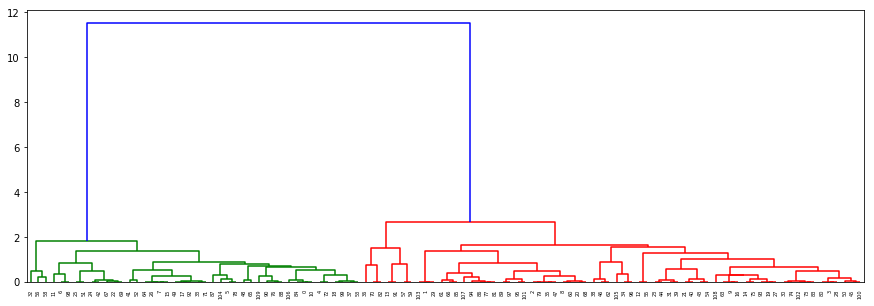

In [141]:
# hierachical clustering
svec = RohG[np.triu_indices(len(RohG),1)]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

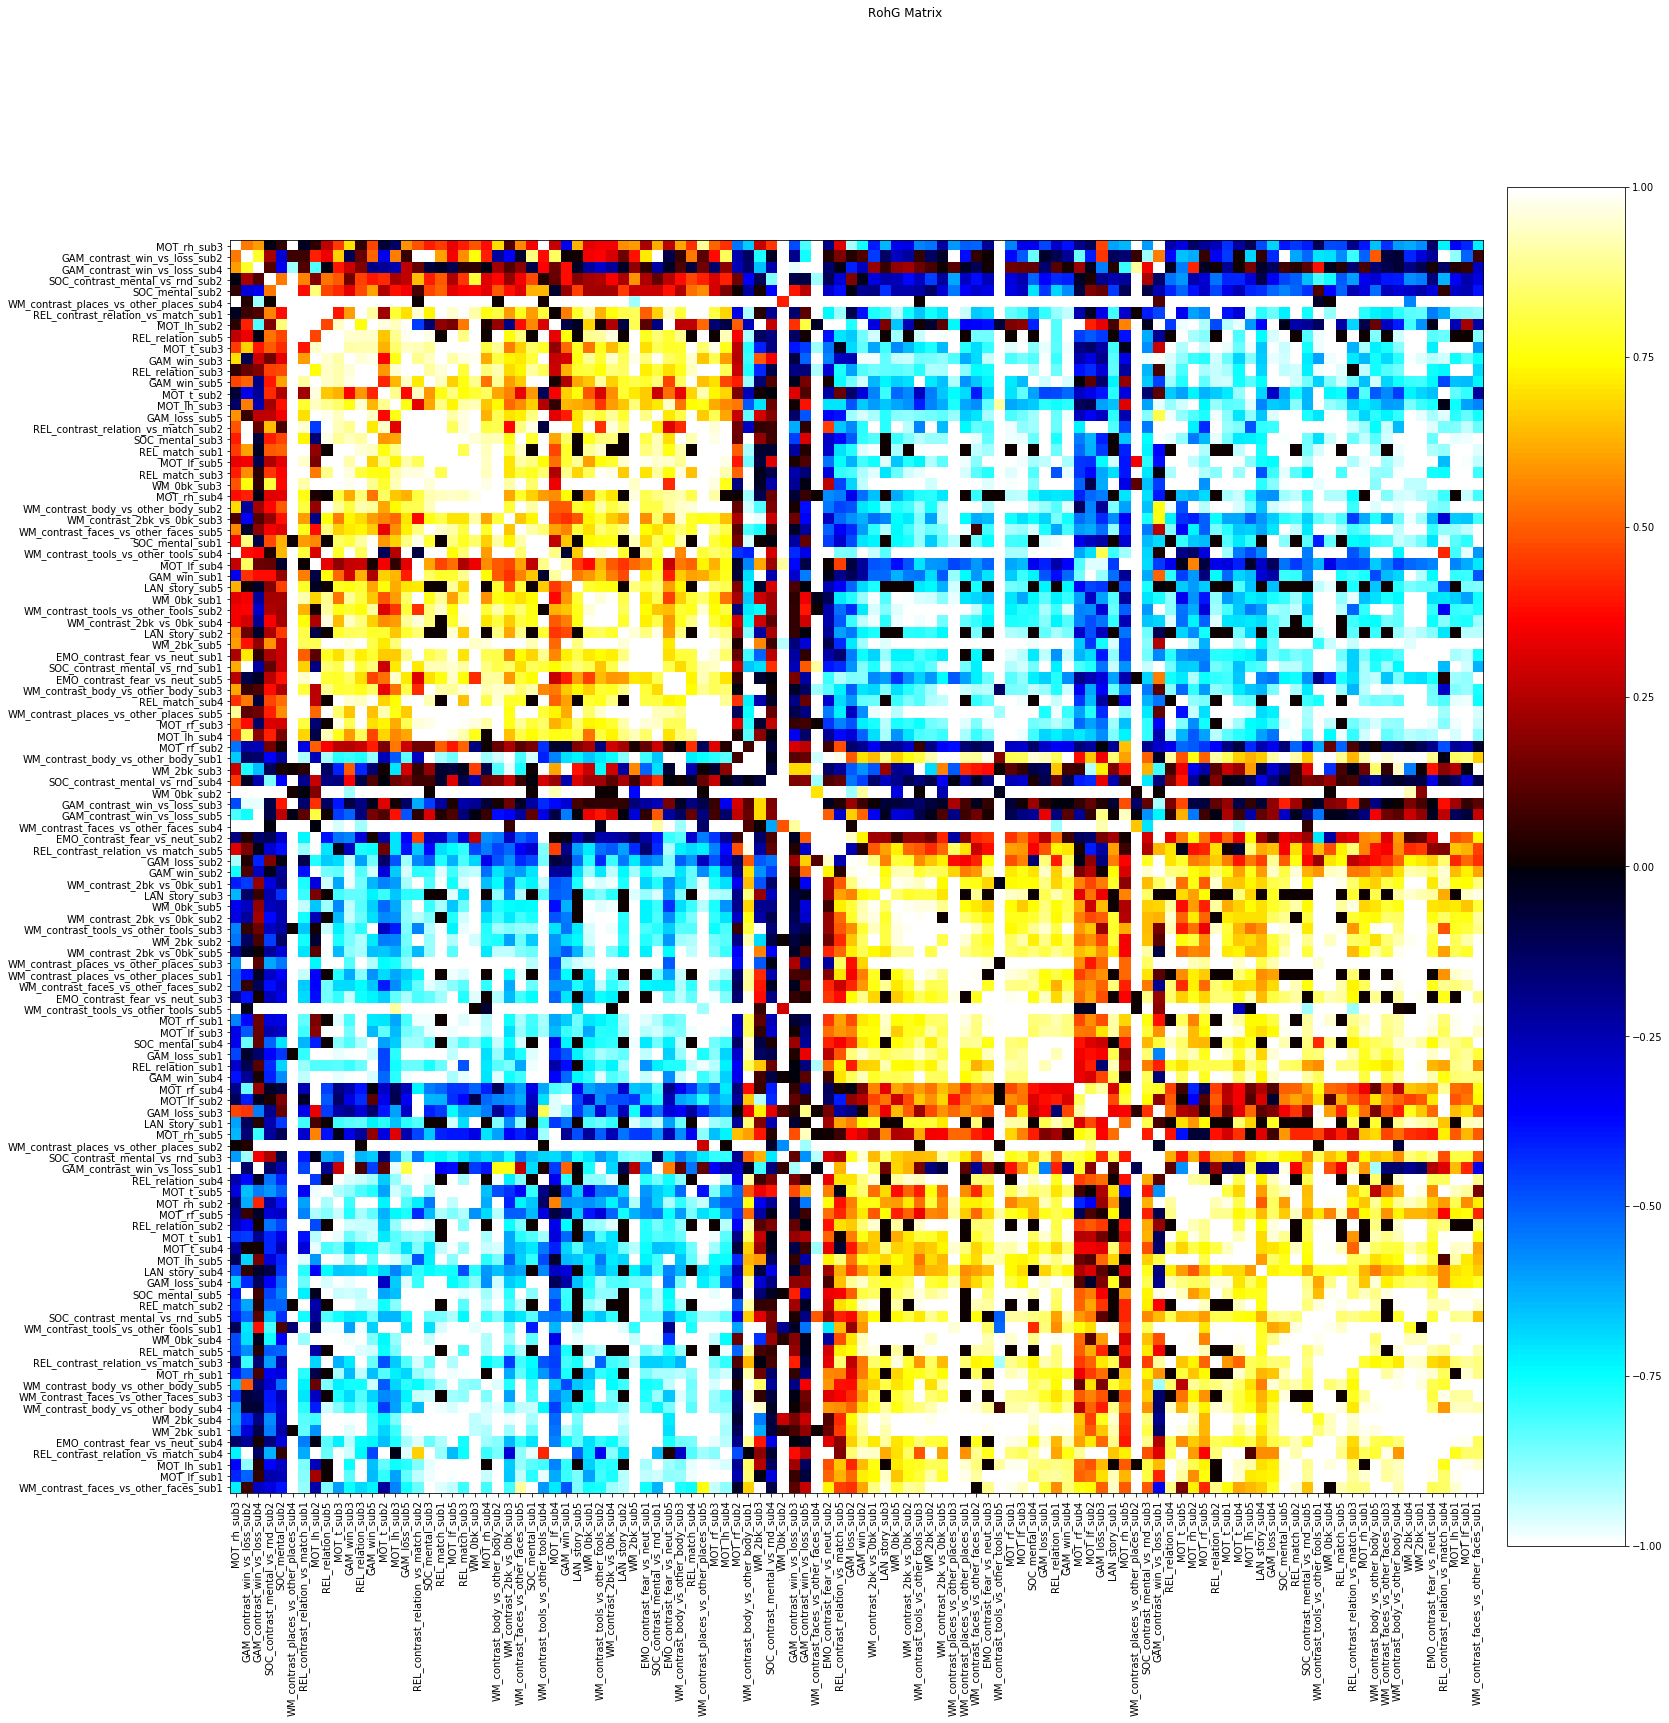

In [143]:
# Plot the RhoG matrix again, but now ordered by hierarchy
use_columns = pheno_stack_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohG[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohG Matrix')

In [144]:
# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]
RohG_p0_fd_clust = RohG_p0_fd[order, :][:, order]
RohG_p1_fd_clust = RohG_p1_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [145]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(RohG_clust, cuts, 2)
mat_fd0, cmat_fd0, lmat_fd0, ind_fd0 = make_boxes(RohG_p0_fd_clust, cuts, 2)
mat_fd1, cmat_fd1, lmat_fd1, ind_fd1 = make_boxes(RohG_p1_fd_clust, cuts, 2)

#### RhoG 

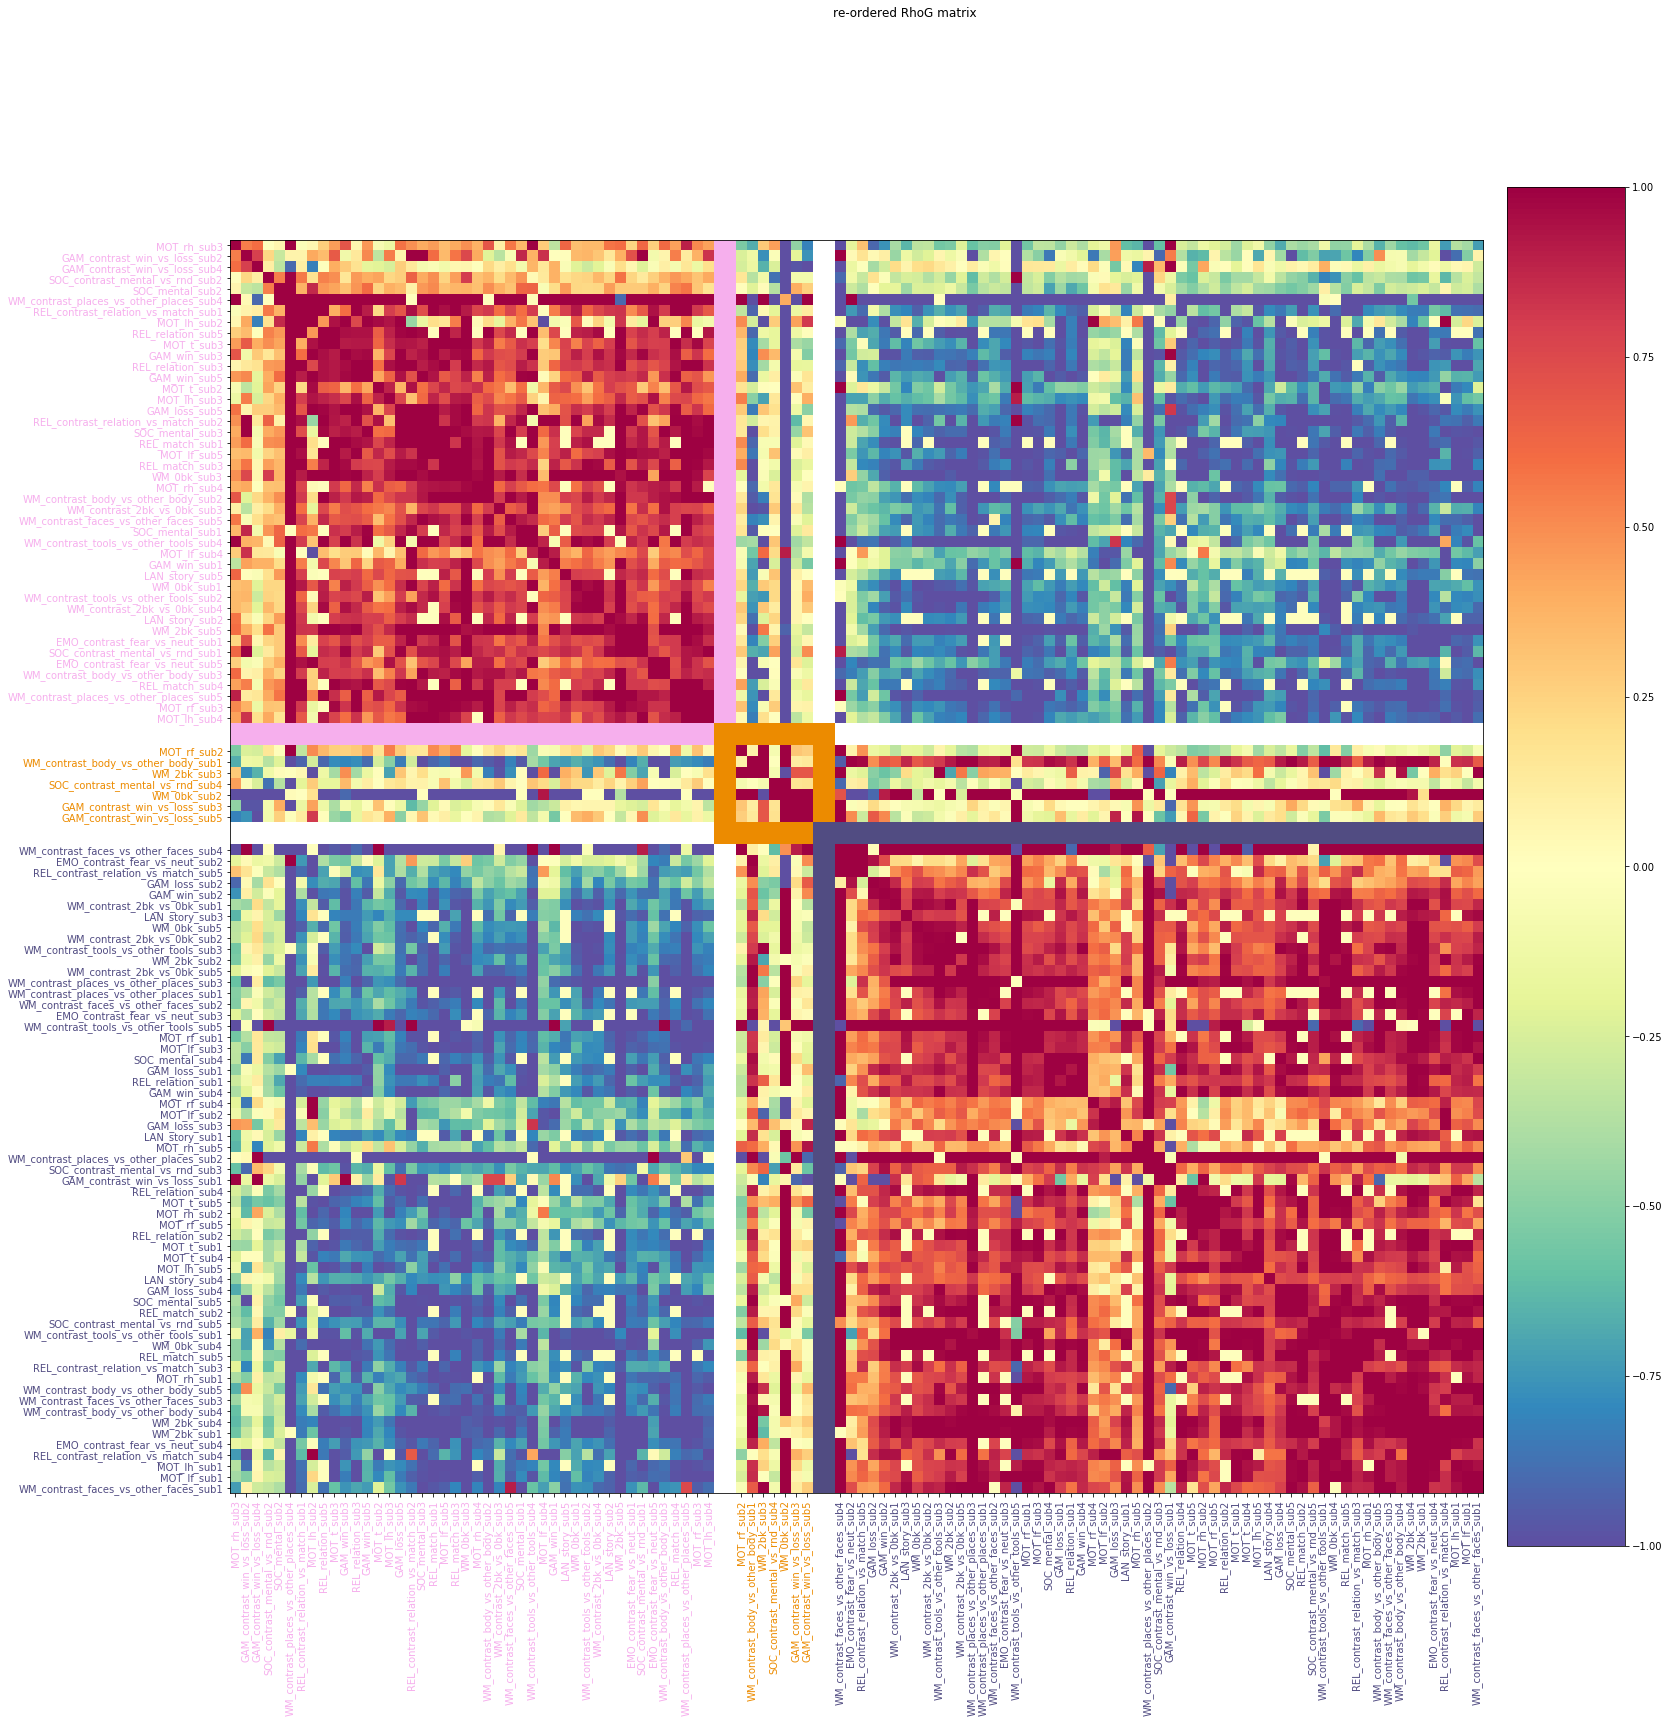

In [146]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoG matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval 0

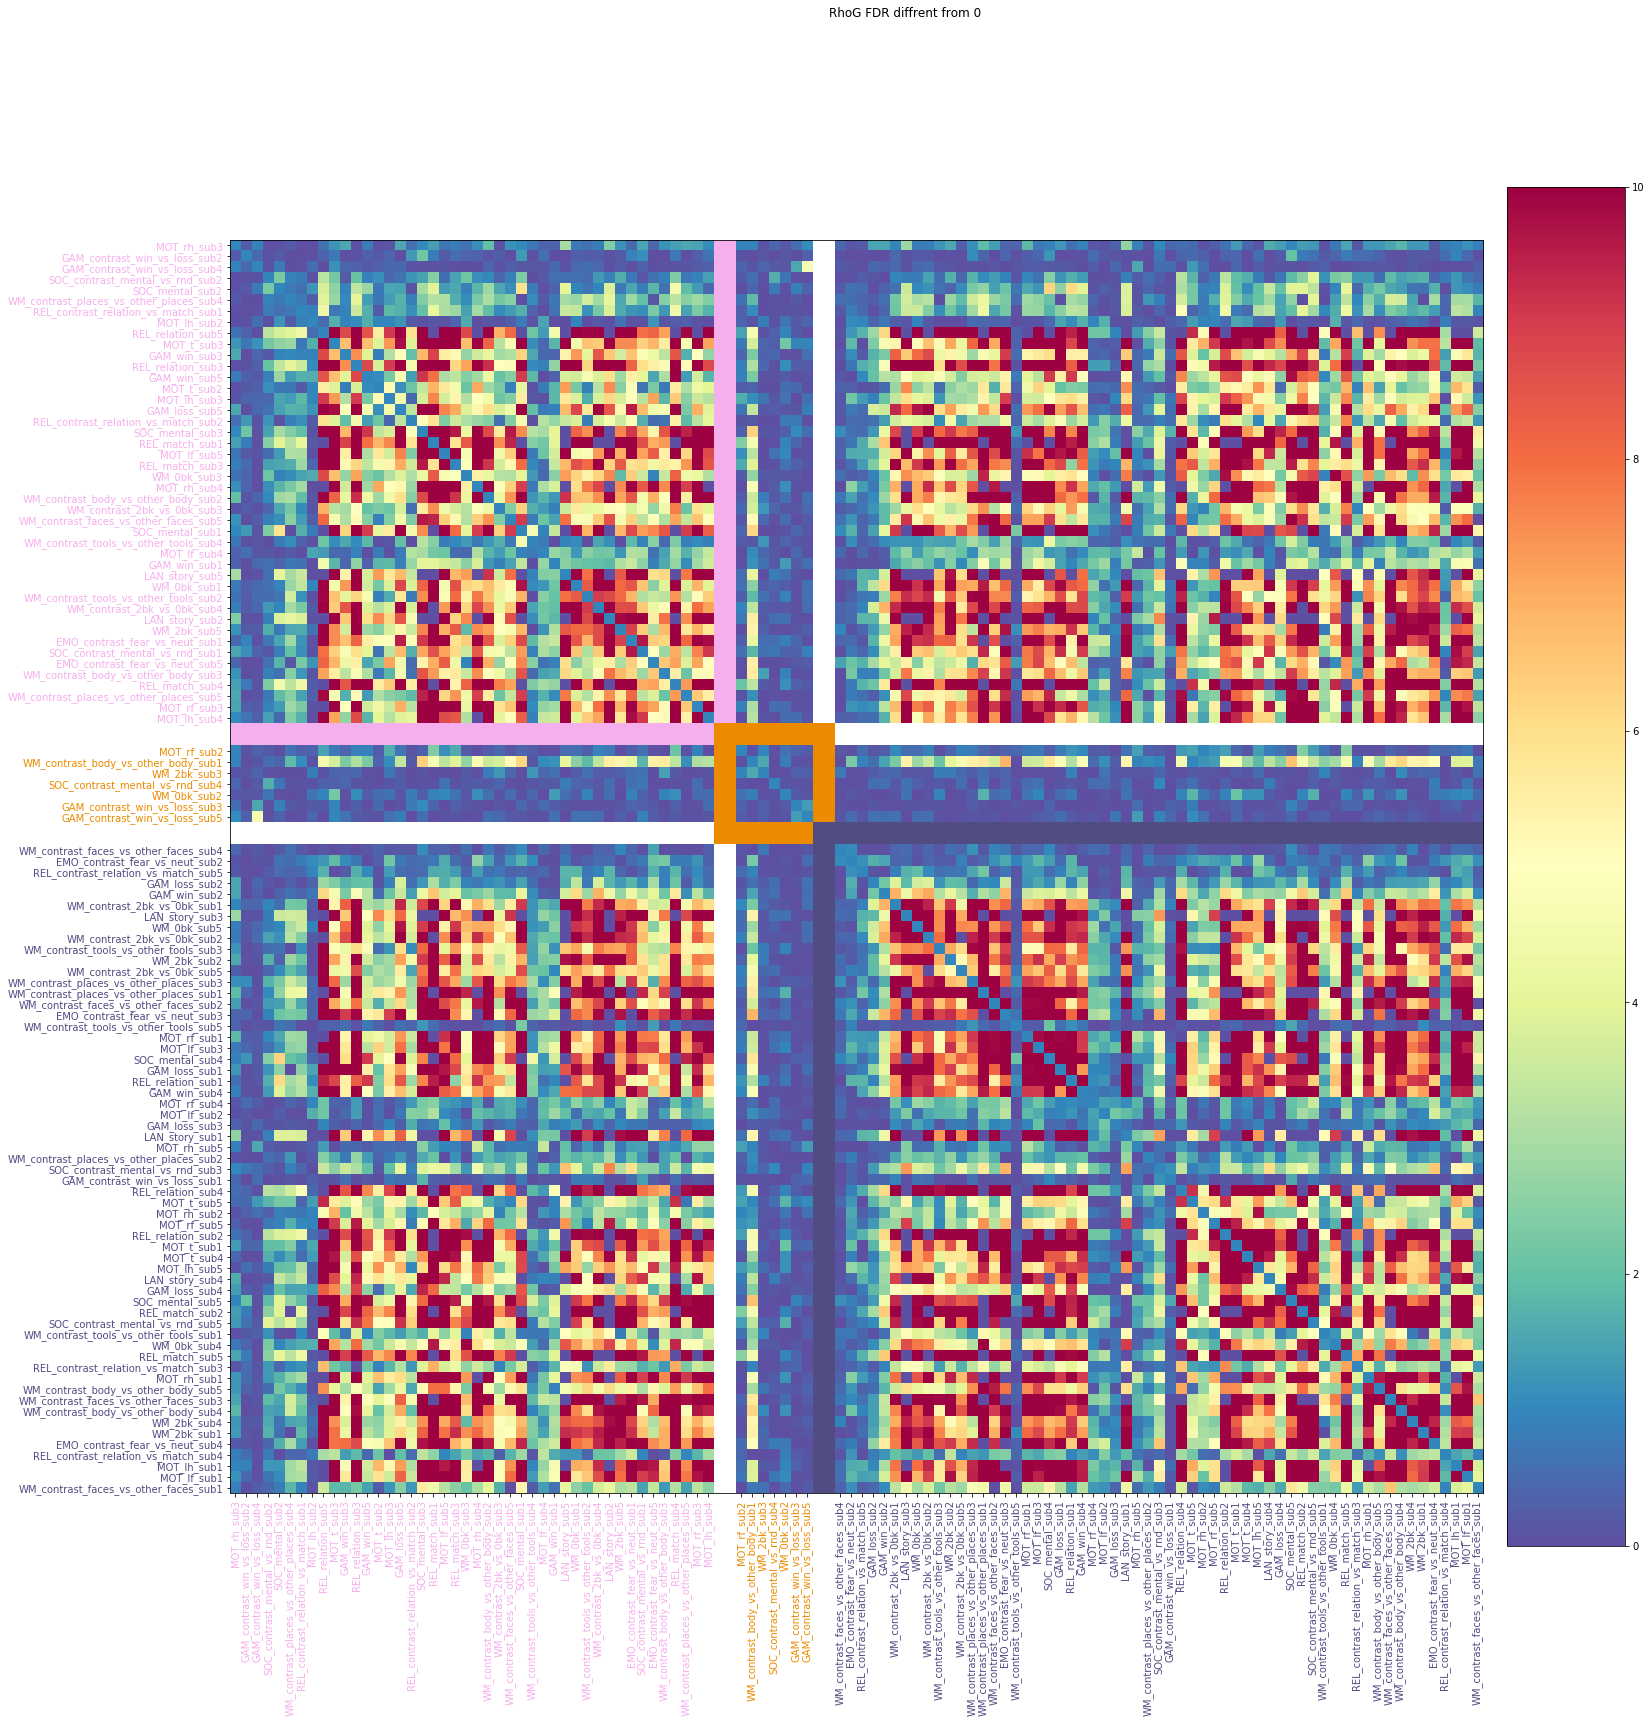

In [147]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd0, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd0, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind_fd0)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd0)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval 1

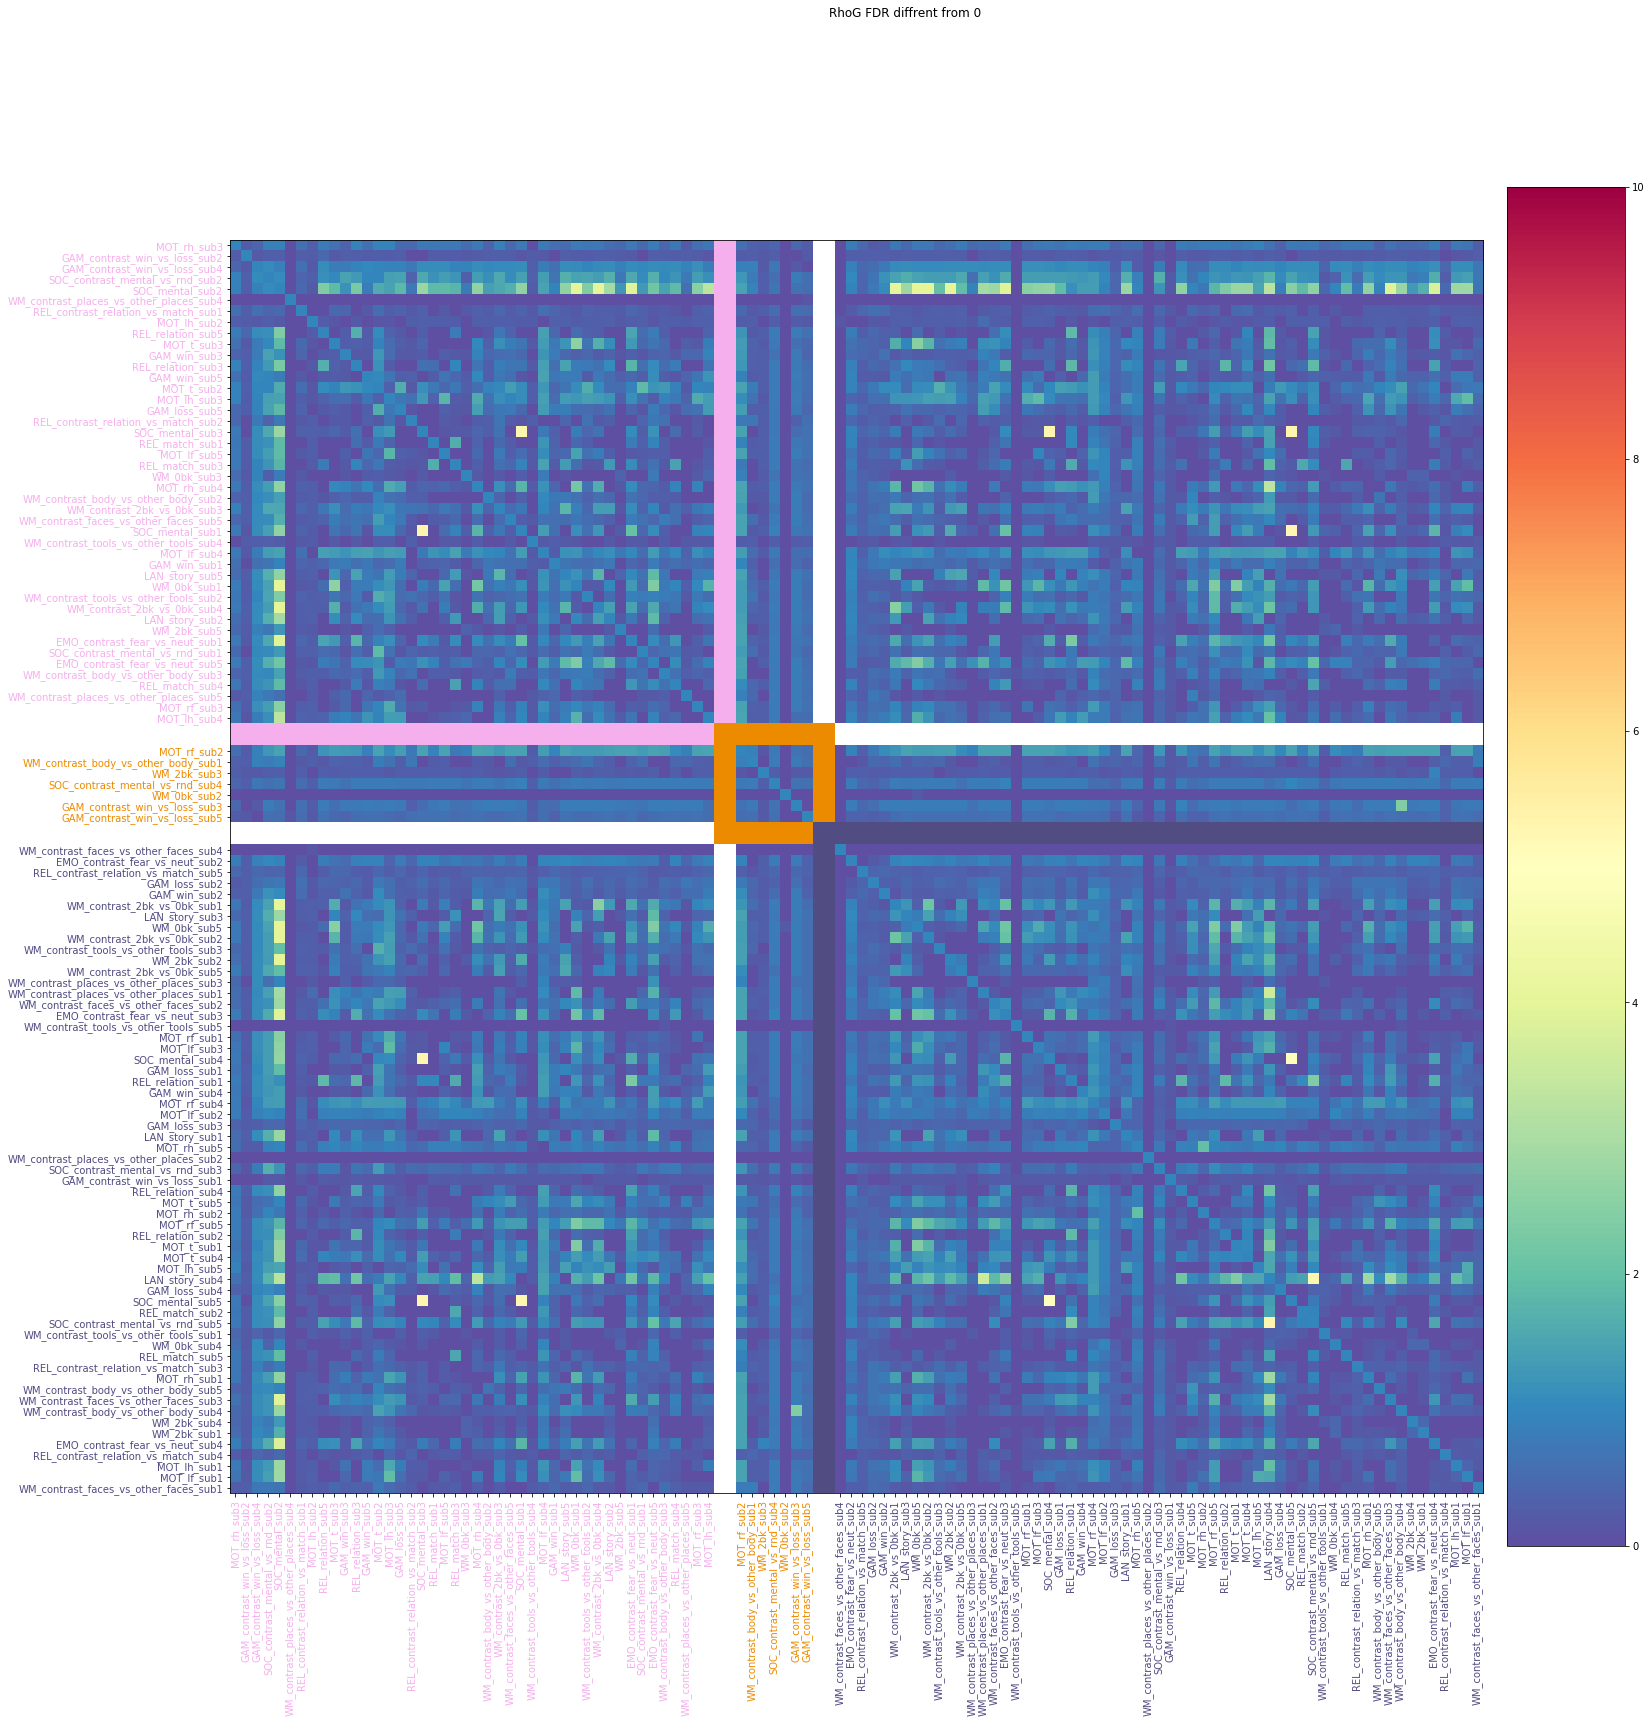

In [148]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd1, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd1, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind_fd1)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd1)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoE matrice

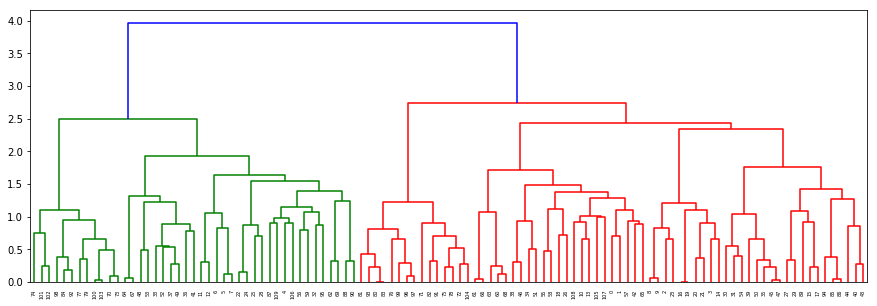

In [149]:
# hierachical clustering
svec = RohE[np.triu_indices(len(RohE),1)]
dist = 1 - svec
n_sbt = 3
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

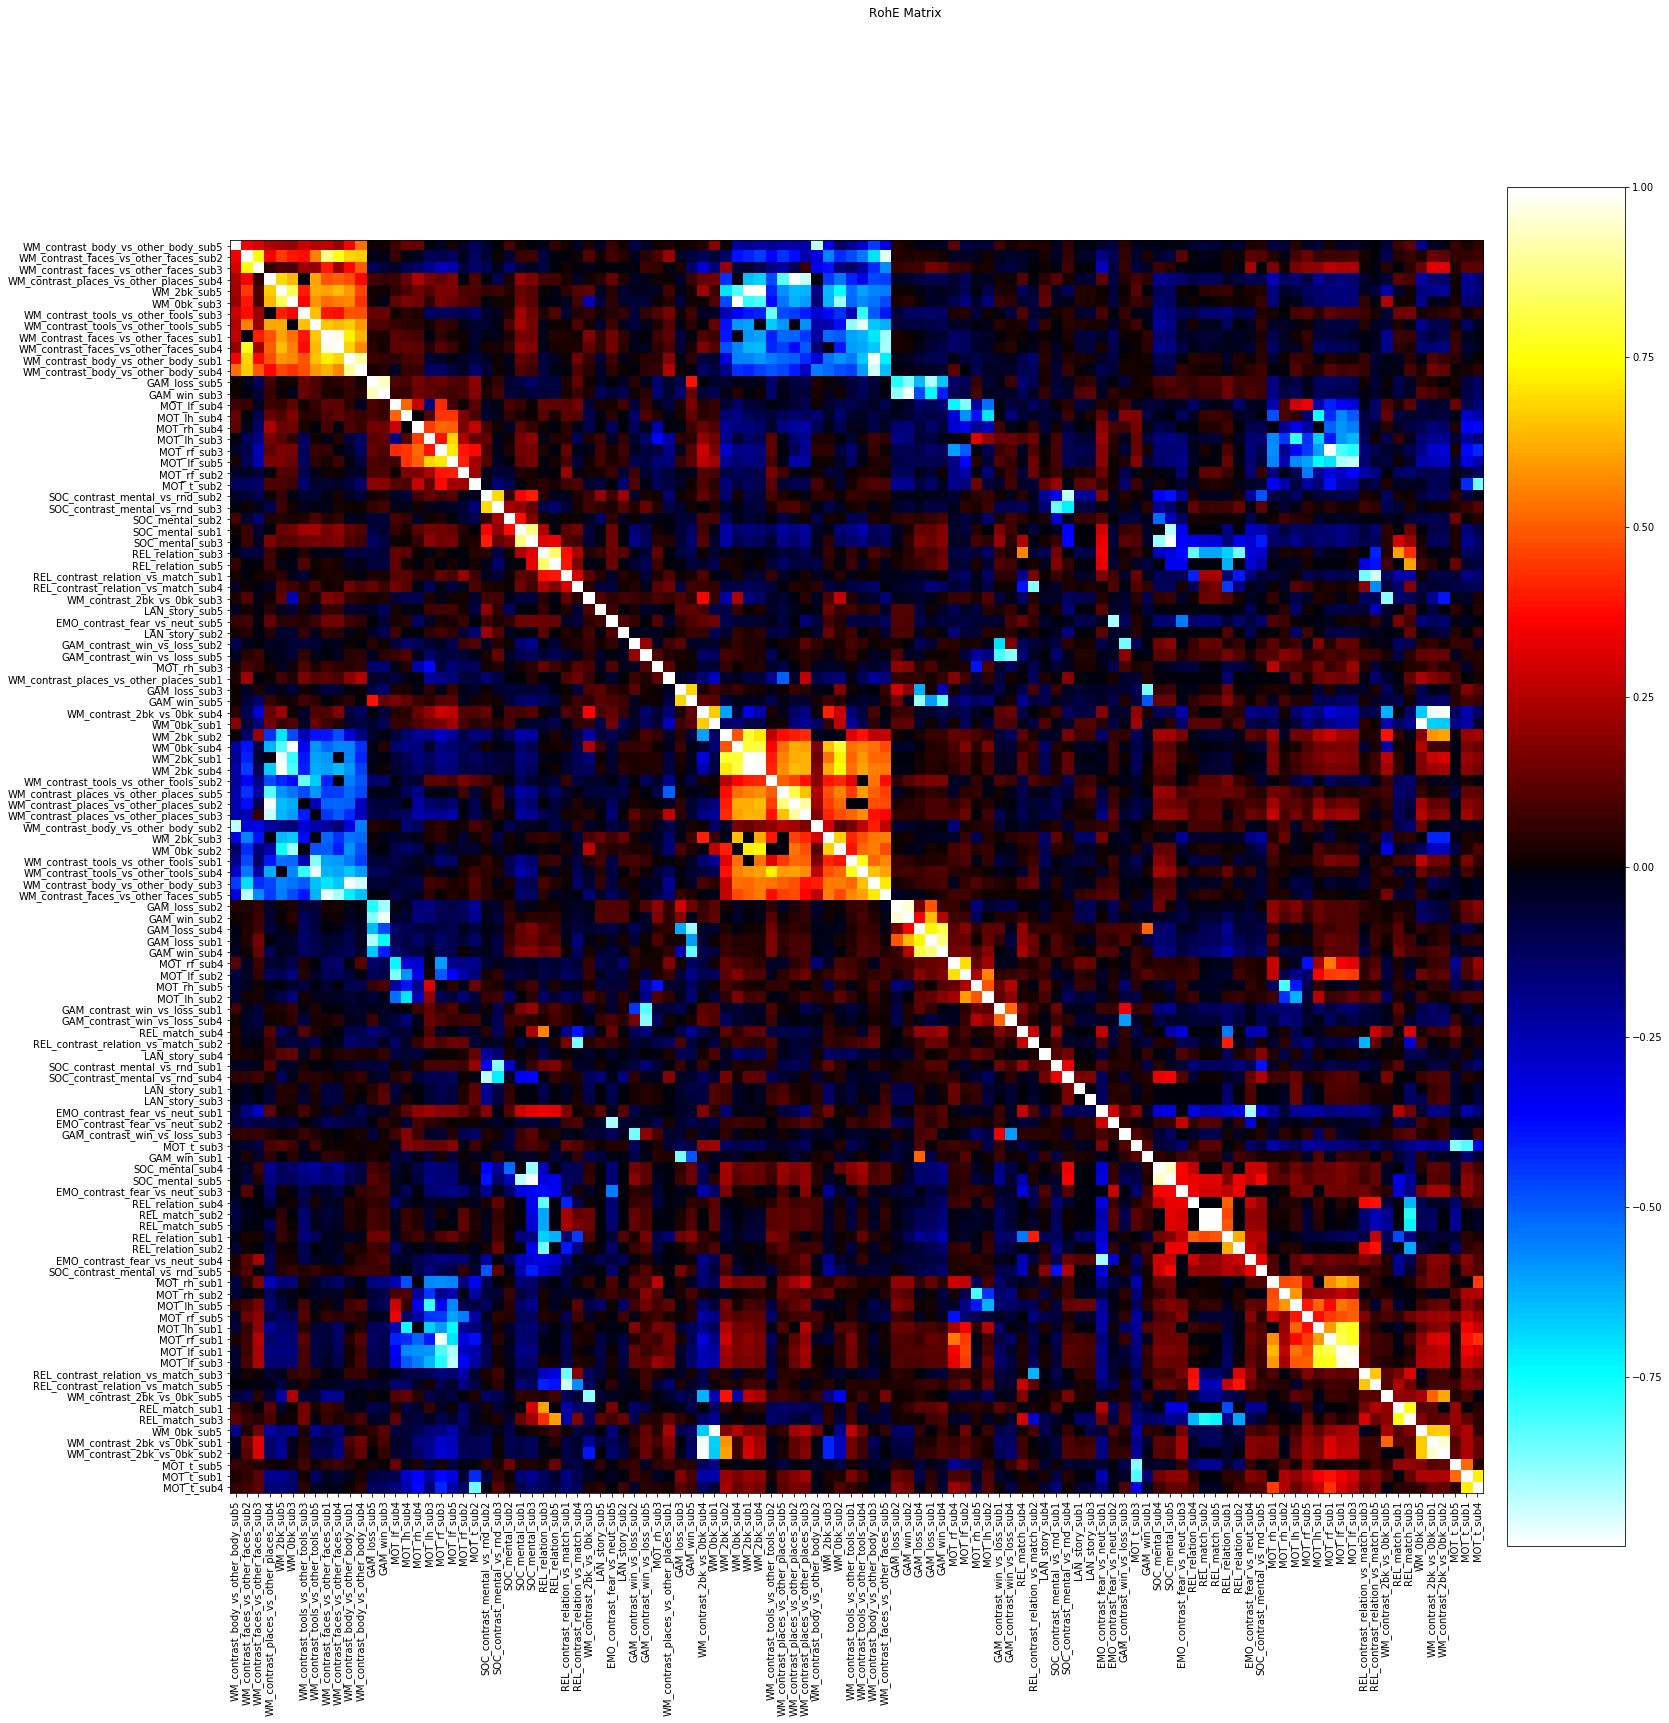

In [151]:
# Plot the RhoE matrix again, but now ordered by hierarchy
use_columns = pheno_stack_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohE[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohE Matrix')

In [152]:
# Order clustered correlation matrix
RohE_clust = RohE[order, :][:, order]
RohE_p_fd_clust = RohE_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [153]:
# Generate boxes
matE, cmatE, lmatE, indE = make_boxes(RohE_clust, cuts, 2)
matE_fd, cmatE_fd, lmatE_fd, indE_fd = make_boxes(RohE_p_fd_clust, cuts, 2)

#### RhoE 

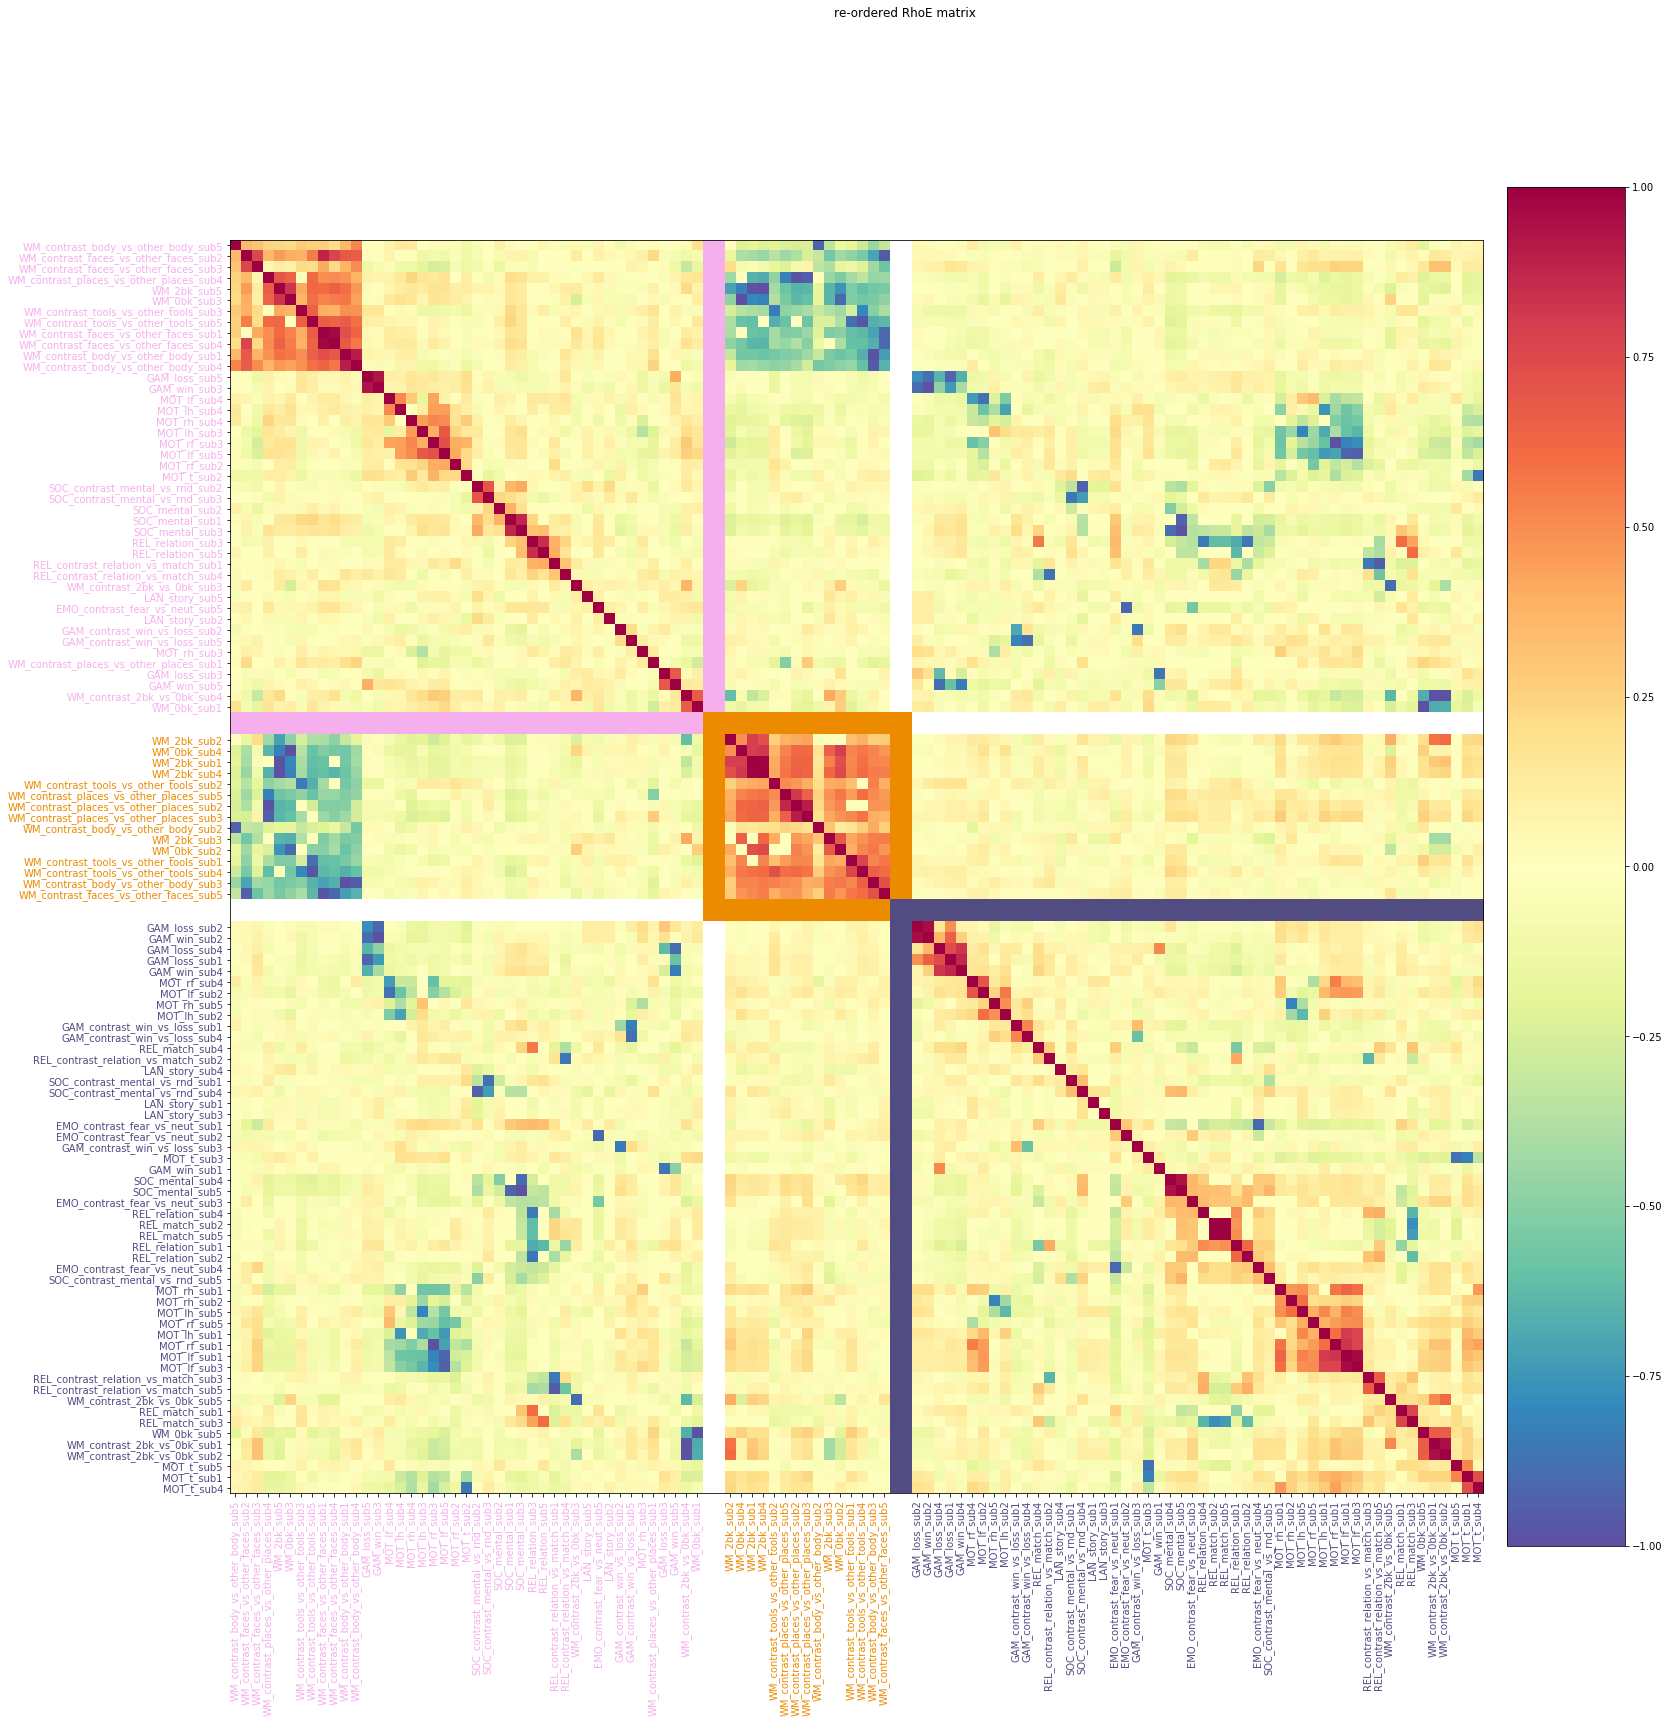

In [154]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indE)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoE matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoE pval

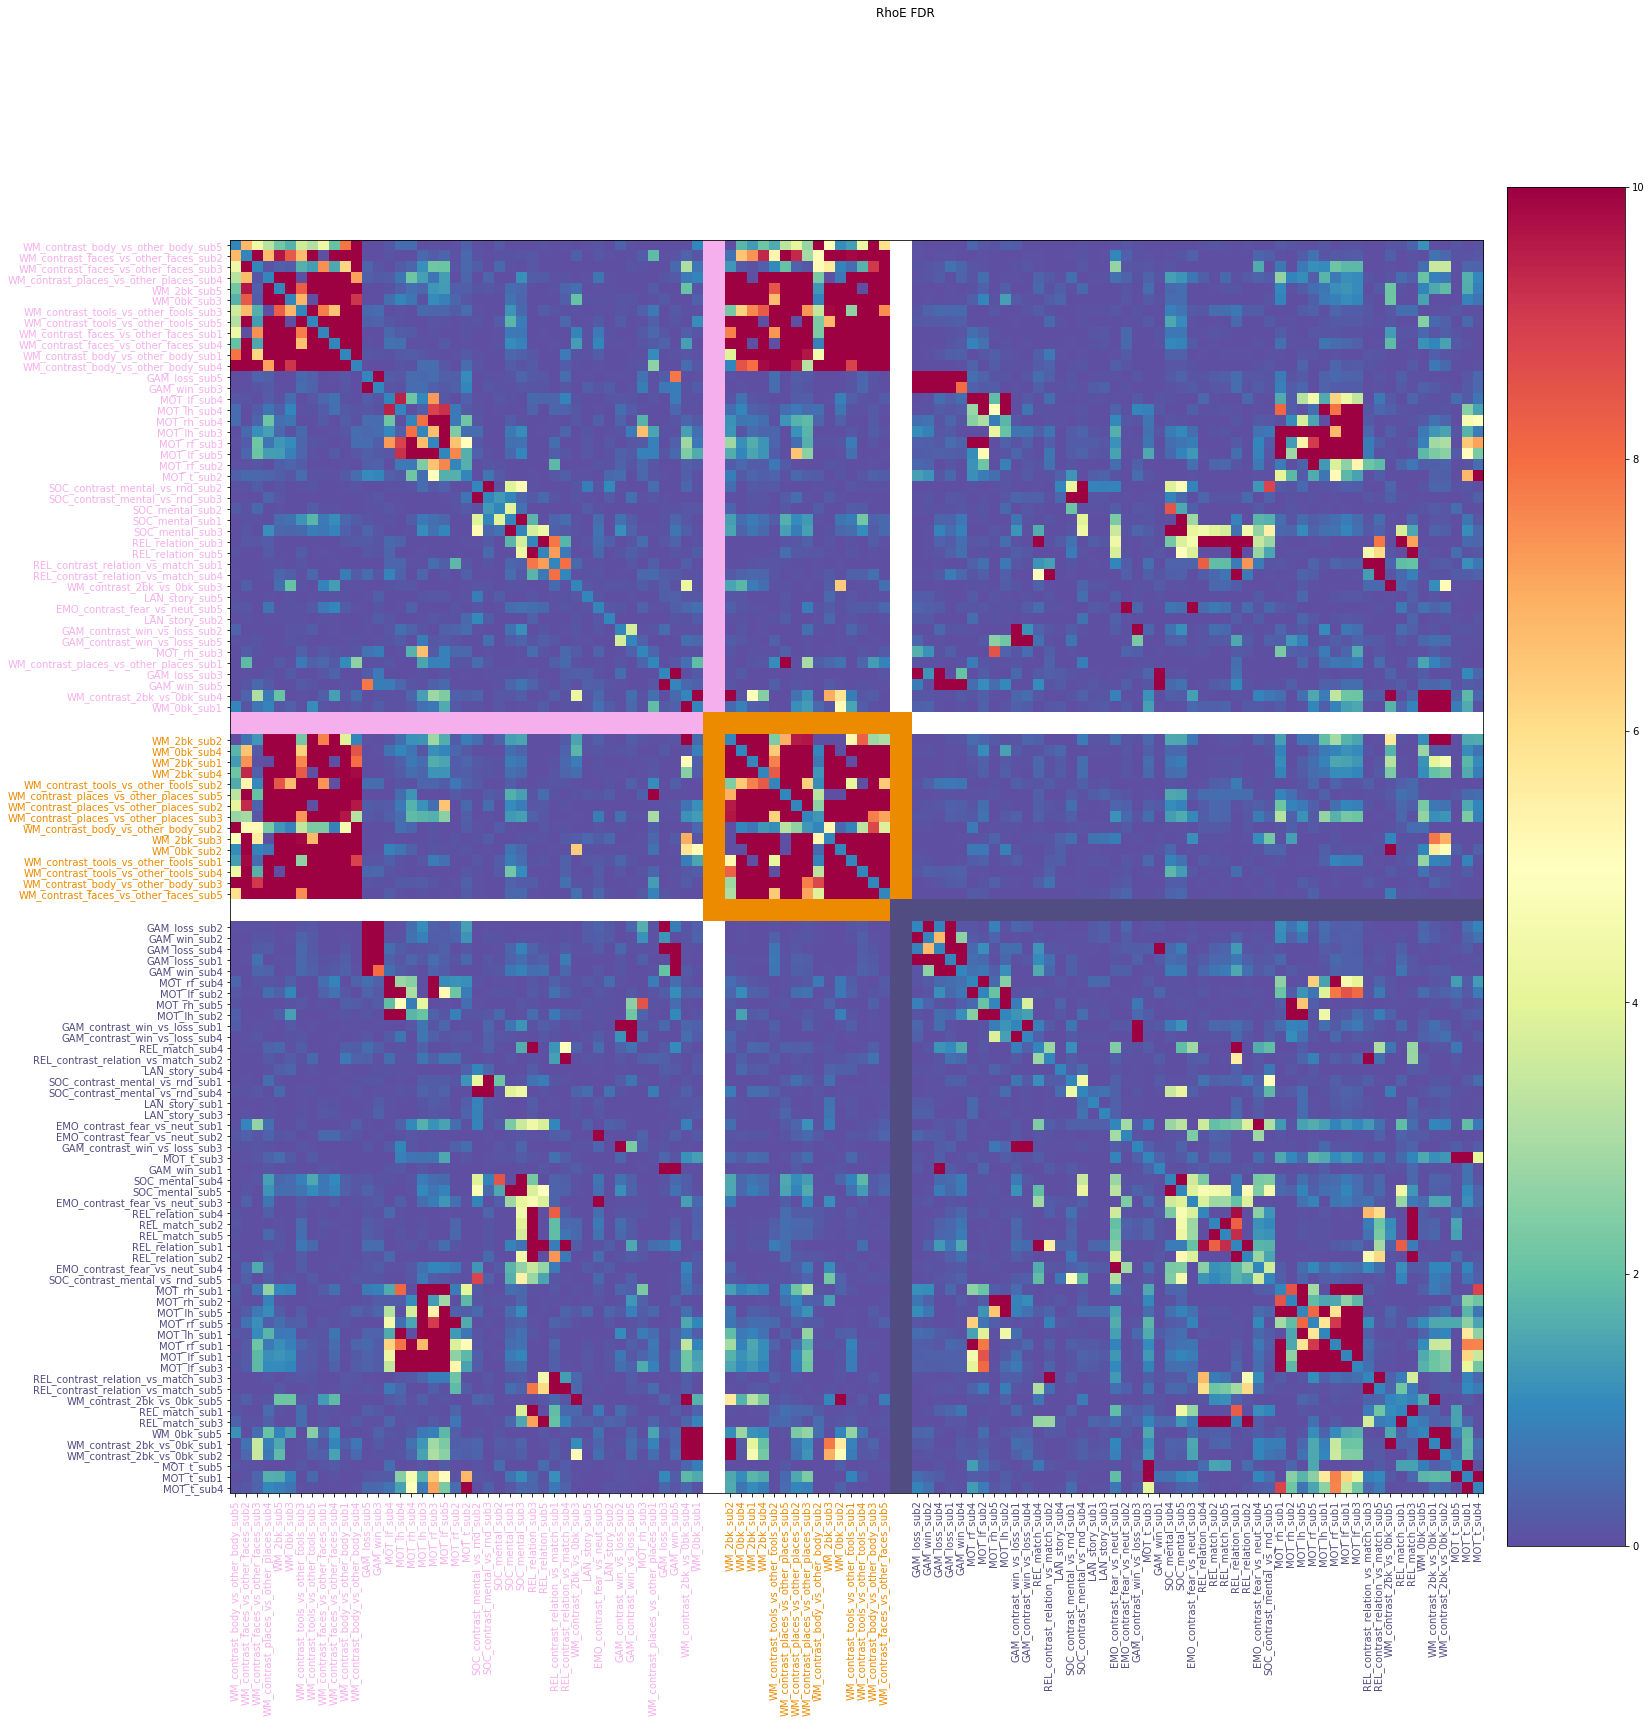

In [155]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE_fd, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indE_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoE FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoP matrice

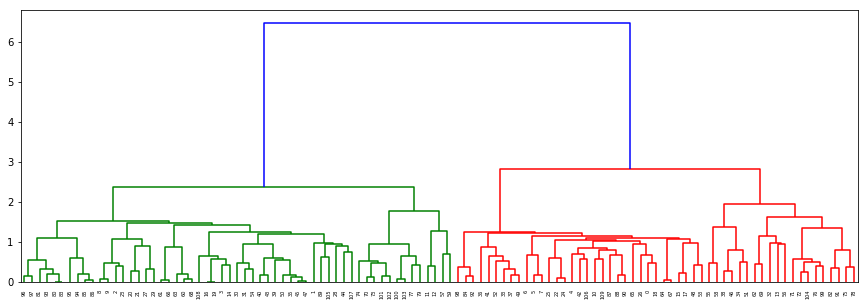

In [156]:
# hierachical clustering
svec = RohP[np.triu_indices(len(RohP),1)]
dist = 1 - svec
n_sbt = 3
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

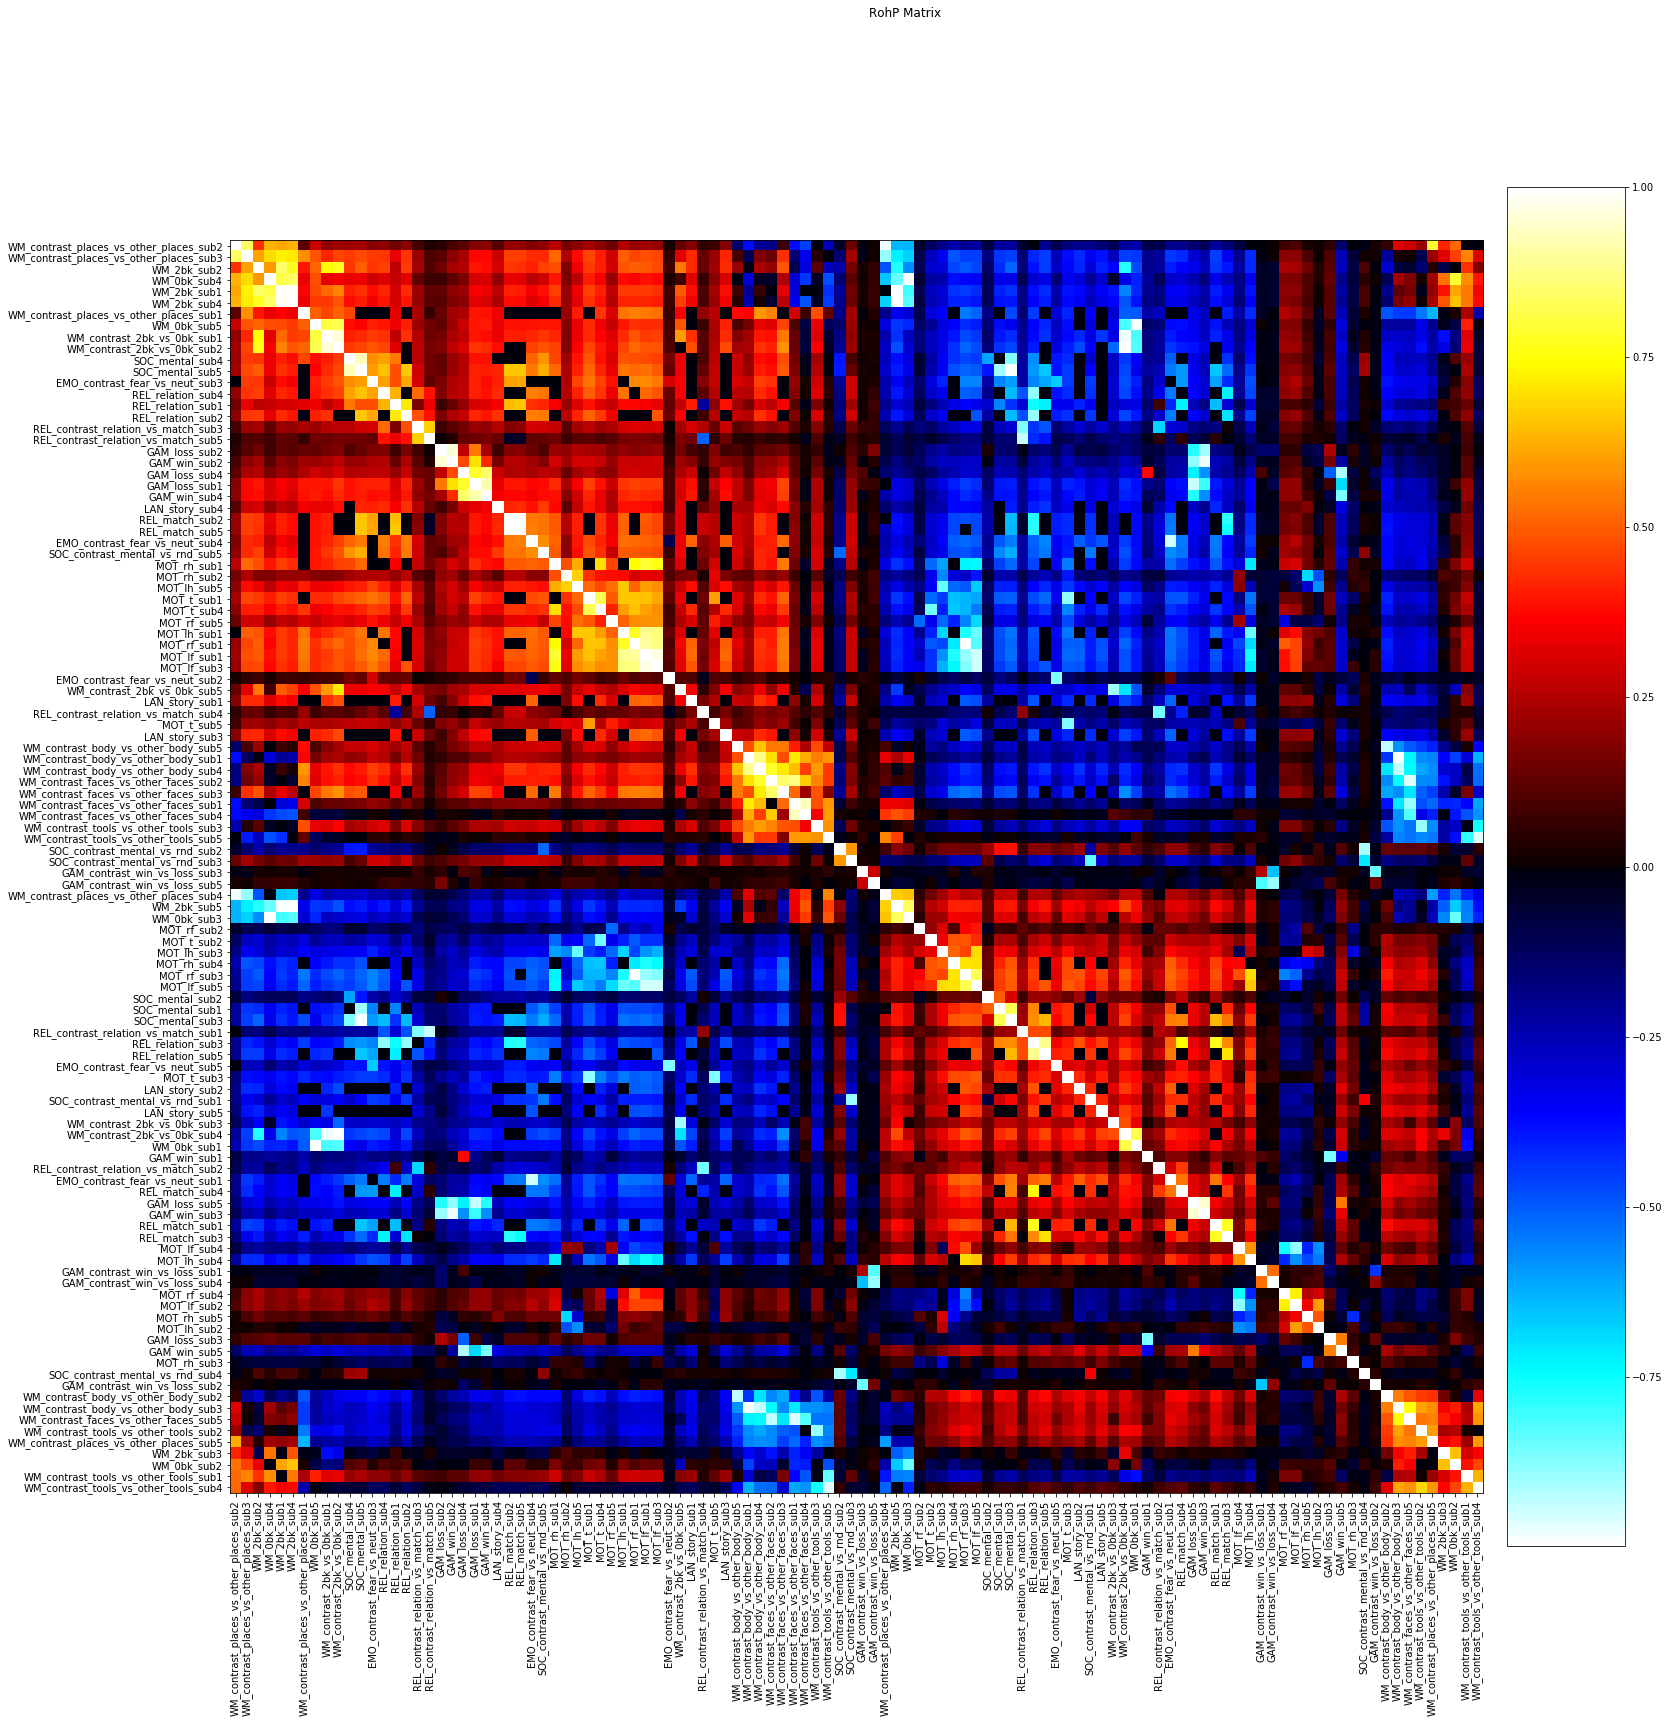

In [158]:
# Plot the RhoP matrix again, but now ordered by hierarchy
use_columns = pheno_stack_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohP[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohP Matrix')

In [159]:
# Order clustered correlation matrix
RohP_clust = RohP[order, :][:, order]
RohP_p_fd_clust = RohP_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [160]:
# Generate boxes
matP, cmatP, lmatP, indP = make_boxes(RohP_clust, cuts, 2)
matP_fd, cmatP_fd, lmatP_fd, indP_fd = make_boxes(RohP_p_fd_clust, cuts, 2)

#### RhoP 

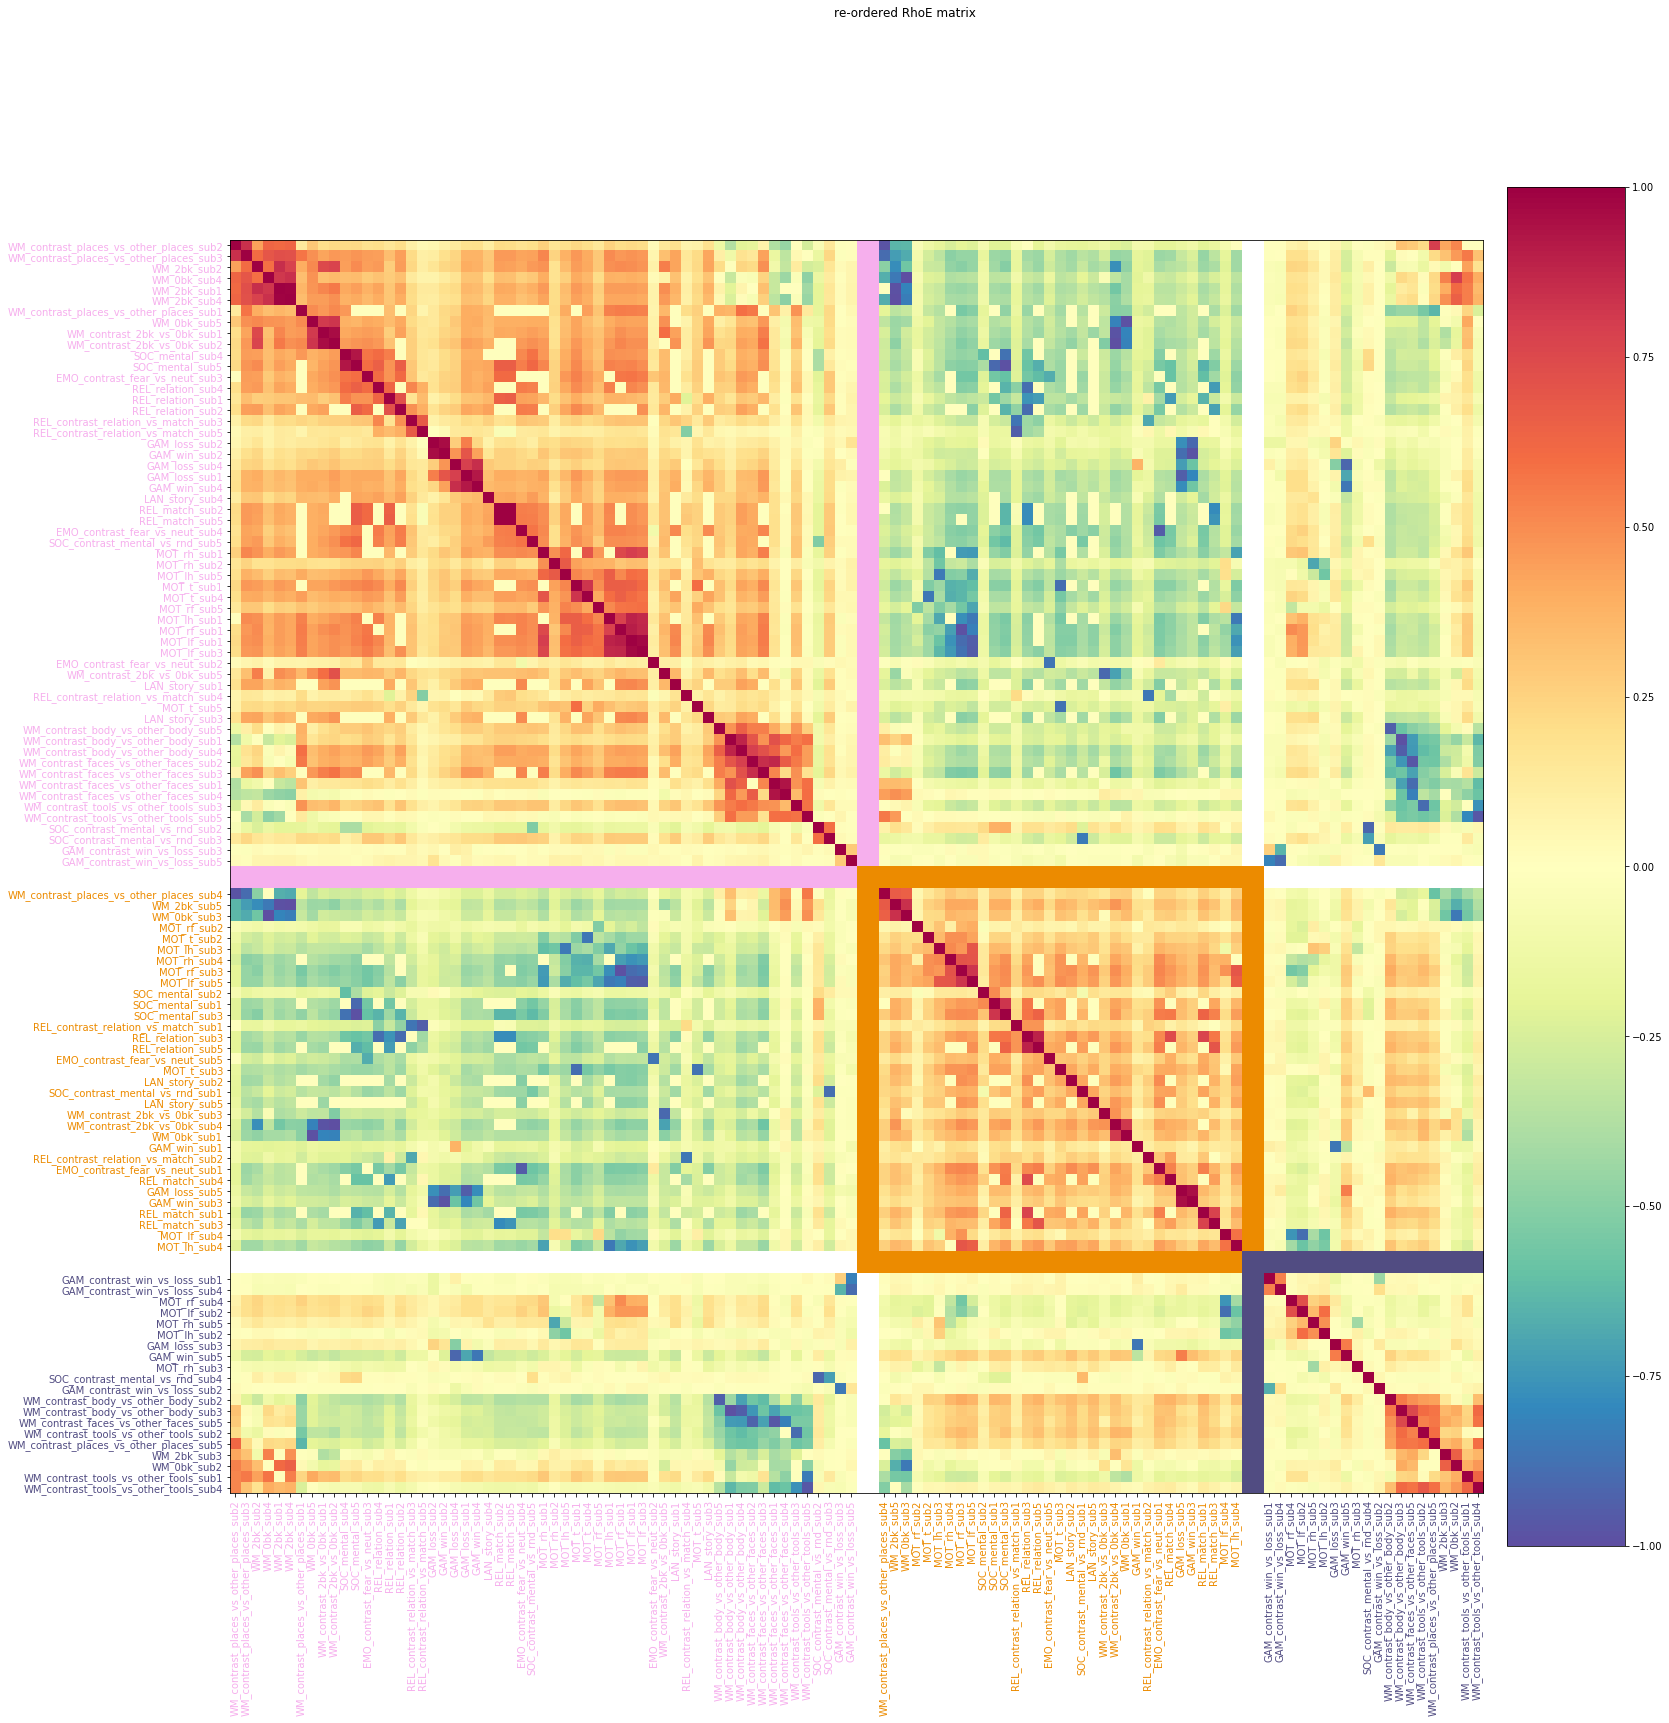

In [161]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatP, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indP)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoE matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoP pval

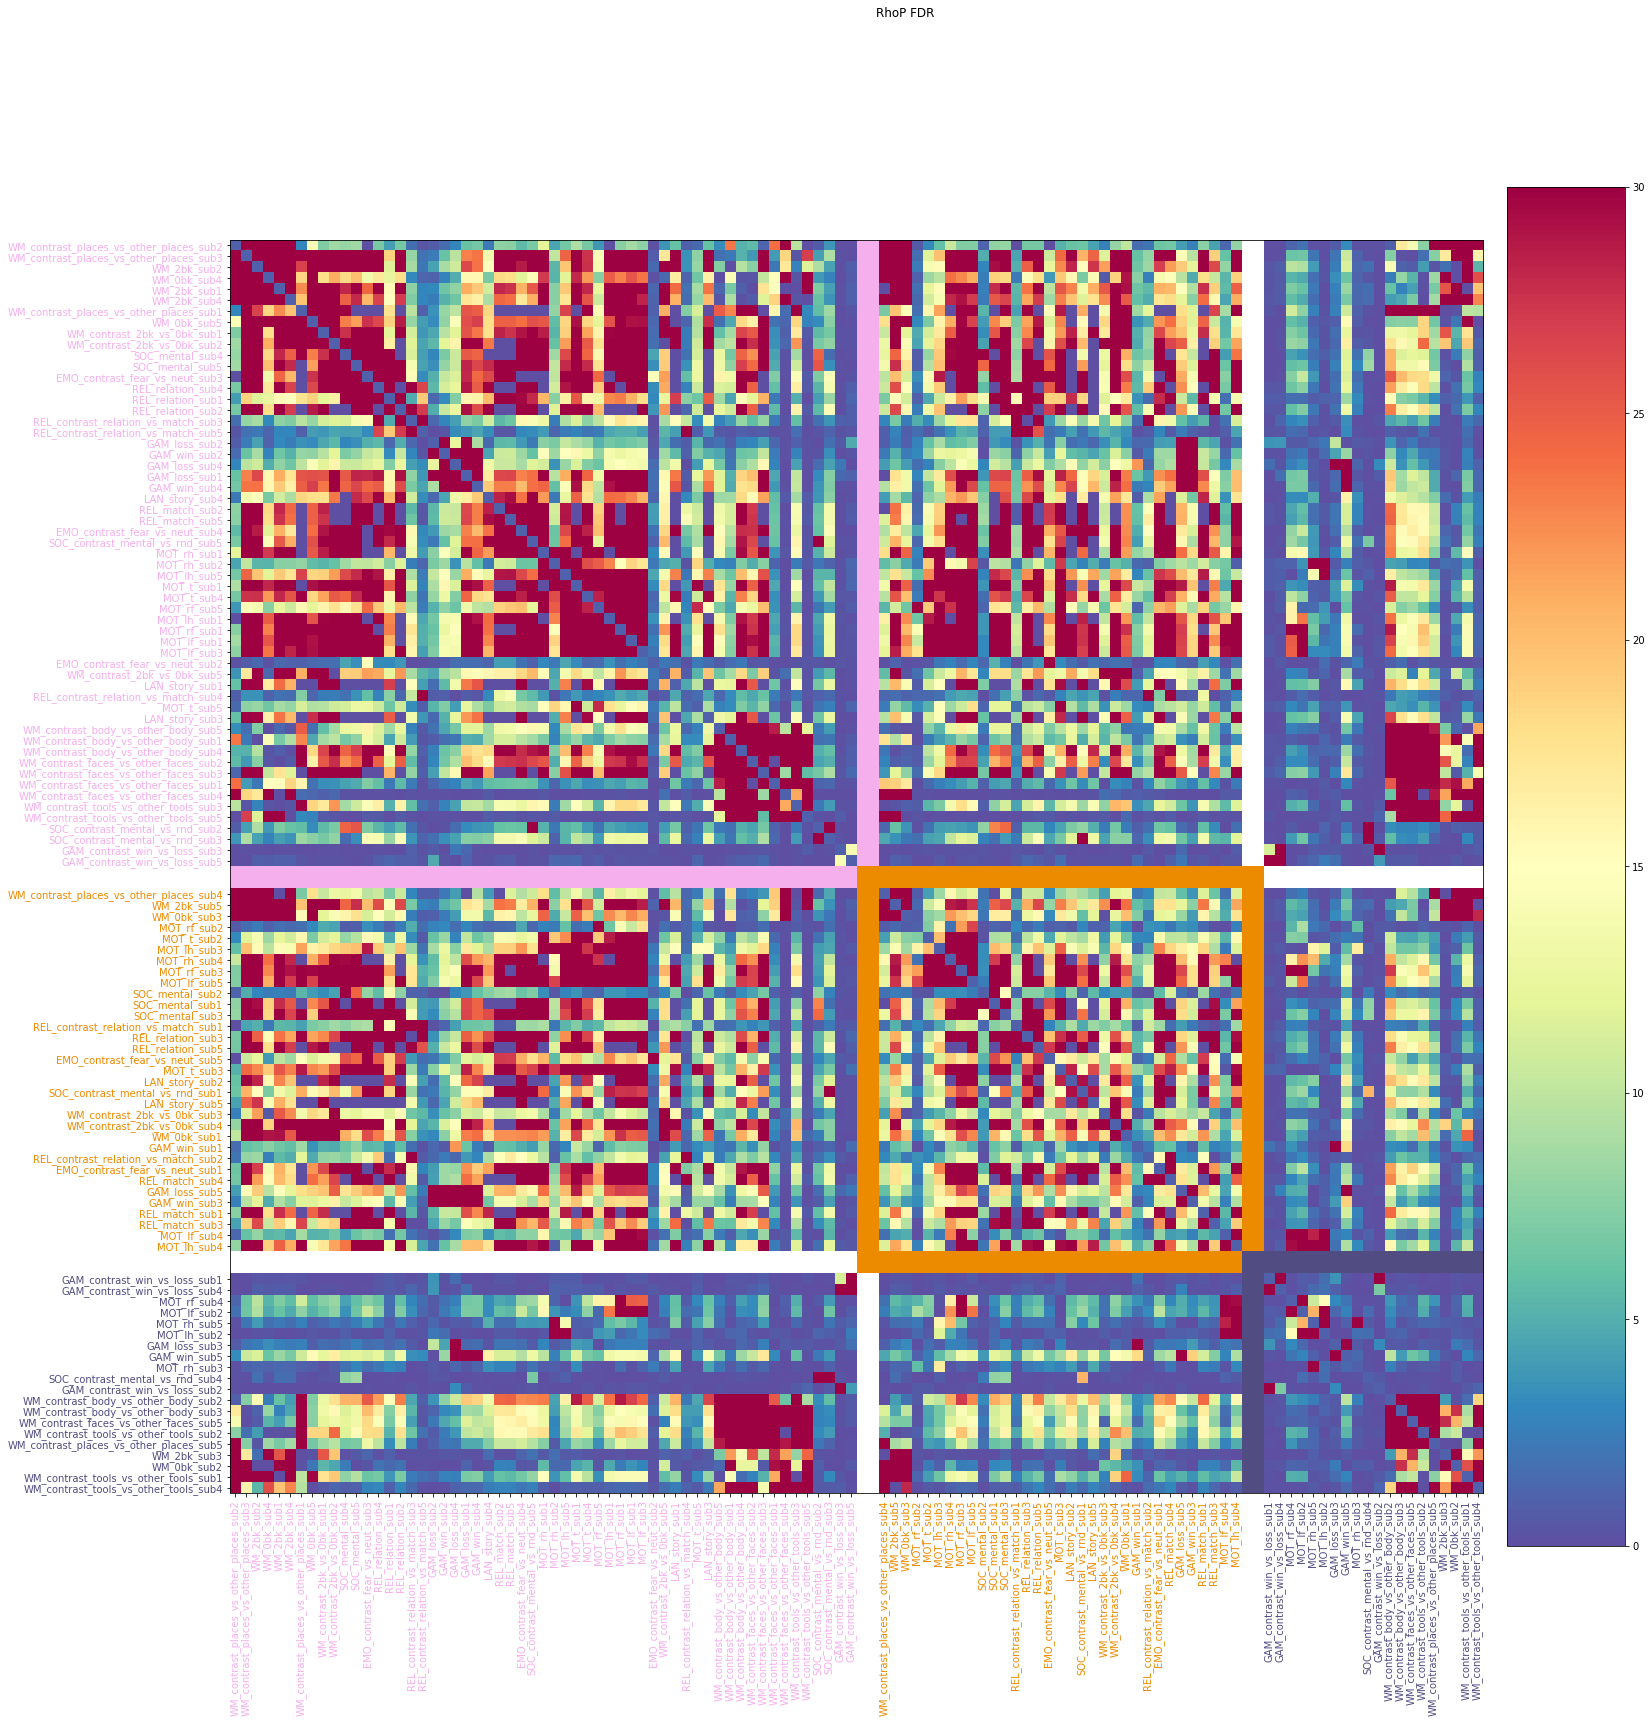

In [162]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=30)
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatP_fd, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indP_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoP FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))